In [248]:
import argparse
import os
import random
import time
import math

# deep learning
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import torchvision.utils as vutils

# machine learning
from sklearn.decomposition import PCA

# data
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# signal processing
from scipy import signal
from scipy.stats import entropy

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  999


In [249]:
import socket
myHostName = socket.gethostname()
print(myHostName)

wifi-staff-172-24-4-124.net.auckland.ac.nz


In [250]:
device = torch.device("mps")

# number of channels the signal has
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# number of signals per iteration
batch_size = 32

# Number of training epochs
num_epochs = 32

# Learning rate for optimizers
lr_g = 0.00002
lr_d = 0.00002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# type of gan
gans_type = "dcgans"

### Dataloader

Getting parameters such as data mean and sd for standardisation

In [251]:
# gw_df = pd.read_csv('../data/gw-raw-data/richers_1764.csv')

# # y-axis processing
# # distance = 3.086e22
# # gw_df = gw_df / distance

# gw_mean = gw_df.mean().mean()
# print('Dataset mean: ',  gw_mean)

# gw_std = gw_df.std().mean()
# print('Dataset std: ',  gw_std)

# gw_scaling_factor = 5
# print('Dataset scaling factor (to match noise in generator): ',  gw_scaling_factor)

In [252]:
class GWDataset(Dataset):
    def __init__(self, signals_csv, parameters_csv):
        self.parameters = pd.read_csv(parameters_csv)
        # choose only the most important parameters for parameter estimation
        # self.parameters = self.parameters[['beta1_IC_b', 'A(km)', 'omega_0(rad|s)']].astype('float32')
        # remove erroneous parameters
        keep_signals_idx = np.array(self.parameters[self.parameters['beta1_IC_b'] > 0].index)
        self.parameters = self.parameters.iloc[keep_signals_idx,:]
        self.parameters['beta1_IC_b_bins'] = pd.qcut(self.parameters['beta1_IC_b'], q=10, labels=False)
        self.parameters = self.parameters[['beta1_IC_b_bins']].astype('float32')

        # convert to numpy array
        self.parameters = self.parameters.values
        self.original_parameters = self.parameters
        self.augmented_parameters = np.empty(shape = (0, self.parameters.shape[1]))

        self.data = pd.read_csv(signals_csv).astype('float32')
        # drop corresponding signals which have erroneous parameter values
        self.data = self.data.iloc[:,keep_signals_idx]
        self.data = self.data.values
        self.original_data = self.data
        self.augmented_data = np.empty(shape = (self.data.shape[0], 0))


    def calc_stats(self):
        self.mean = self.data.mean()
        print('Dataset mean: ',  self.mean)
        self.std = np.std(self.data, axis=None)
        print('Dataset std: ',  self.std)
        self.scaling_factor = 5
        print('Dataset scaling factor (to match noise in generator): ',  self.scaling_factor)

    def get_common(self):
        self.common_ylim_signal = (self.data[:,:].min(), self.data[:,:].max())
        return self.common_ylim_signal

    # def pad_signals(self):
    #     desired_length = 512
    #     augmented_signals = np.empty((desired_length, self.data.shape[1]), dtype=int)

    #     for i in range(self.data.shape[1]):
    #         signal = self.data[:, i]
    #         signal = signal.reshape(1, -1)

    #         padding_left = (desired_length - len(signal[0])) // 2
    #         padding_right = desired_length - len(signal[0]) - padding_left

    #         signal_padded = np.pad(signal, ((0, 0), (padding_left, padding_right)), mode='edge')

    #         augmented_signals = np.insert(augmented_signals, augmented_signals.shape[1], signal_padded, axis=1)

    #     self.data = augmented_signals
    
    def standardize(self, signal):
        standardized_signal = (signal - self.mean) / self.std
        standardized_signal = standardized_signal / self.scaling_factor
        return standardized_signal

    def shift_augmentation(self, signal):
        shift = np.random.normal(0, 25, 1)
        shifted_signal = np.roll(signal, int(shift))
        
        return shifted_signal

    def scale_augmentation(self, signal):
        scale_factor = np.random.normal(10, 0.2, 1)
        scale_factor = np.maximum(scale_factor, 0)
        scaled_signal = scale_factor * signal
        return scaled_signal

    def jittering_augmentation(self, signal):
        # todo: add noise only after time of core bounce
        # noise_start_time = 203
        noise = np.random.normal(0, 1, signal.shape[1])
        jittered_signal = signal + noise
    
        return jittered_signal

    def mixture_augmentation(self, signal_1, signal_2):
        distance_multiplier = np.random.normal(0.5, 0.2, 1)
        # clip signal to range [0,1] as this is the multiplier by the normalised difference in signals
        distance_multiplier = np.clip(distance_multiplier, 0, 1)
        mixture_signal = signal_1 + distance_multiplier * (signal_2 - signal_1)

        return mixture_signal

    def window_warping_augmentation(self, signal):
        # take window size of 10% of the signal with a warping factor of 2 or 0.5 (from literature)
        warping_factor =  random.choice([0.5, 2])
        # warping_factor = 0.5

        window_size = math.floor(signal.shape[1] / 10)
        scaled_window_size = warping_factor * window_size

        # don't warp anything a little bit before the core-bounce - preserves core-bounce position
        window_min_idx = 203

        # find random reference position for start of window warping
        window_start_idx = np.random.randint(window_min_idx, signal.shape[1] - scaled_window_size*2)
        window_end_idx = window_start_idx + window_size

        # select between warping by factor 1/2 or 2
        if (warping_factor == 2):
            # extract values before, at and after the window
            # clip end of signal to make up for extra size due to window warping
            signal_before_window = signal[0][:window_start_idx]
            signal_window = signal[0][window_start_idx:window_end_idx]
            signal_after_window = signal[0][window_end_idx:int(signal.shape[1]-(window_size))]
            # print(signal_after_window)

            # time points
            t = np.arange(len(signal_window))
            warped_t = np.arange(0, len(signal_window), 0.5)

            # interpolation for window warping
            signal_window_warped = np.interp(warped_t, t, signal_window)

            # combine signals
            warped_signal = np.concatenate((signal_before_window, signal_window_warped, signal_after_window), axis=0)
        elif (warping_factor == 0.5):
            # extract values before, at and after the window
            # clip end of signal to make up for extra size due to window warping
            signal_before_window = signal[0][:window_start_idx]
            signal_window = signal[0][window_start_idx:window_end_idx]
            signal_after_window = signal[0][window_end_idx:]
            # add values to end of signal to make up for downsampled window
            signal_after_window = np.pad(signal_after_window, (0, int(window_size - scaled_window_size)), mode='edge')

            signal_window_warped = signal_window[::int(1/warping_factor)]

            warped_signal = np.concatenate((signal_before_window, signal_window_warped, signal_after_window), axis=0)
        else:
            warped_signal = signal

        return warped_signal

    def augmentation(self, desired_augmented_data_count):
        while self.data.shape[1] < desired_augmented_data_count:
            idx_1 = np.random.randint(0, self.data.shape[1])
            signal_1 = self.data[:, idx_1]
            signal_1 = signal_1.reshape(1, -1)

            # second signal used only used for mixture signals data augmentation
            # idx_2 = np.random.choice([x for x in range(0, self.data.shape[1]) if x != idx_1])
            # signal_2 = self.data[:, idx_2]
            # signal_2 = signal_2.reshape(1, -1)

            # call selected augmentation function here
            augmented_signal = self.window_warping_augmentation(signal_1)
            # augmented_signal = self.mixture_augmentation(signal_1, signal_2)

            self.augmented_data = np.insert(self.augmented_data, self.augmented_data.shape[1], augmented_signal, axis=1)
            self.data = np.insert(self.data, self.data.shape[1], augmented_signal, axis=1)

            # just sample parameters for now, haven't figured out a way to augment them to make consistent with signal augmentation
            augmented_parameter = self.parameters[idx_1, :]
            augmented_parameter = augmented_parameter.reshape(1, -1)

            self.augmented_parameters = np.insert(self.augmented_parameters, self.augmented_parameters.shape[0], augmented_parameter, axis=0)
            self.parameters = np.insert(self.parameters, self.parameters.shape[0], augmented_parameter, axis=0)

        print(self.data.shape)
        print(self.parameters.shape)

    def __len__(self):
        return self.data.shape[1]

    def __getitem__(self, idx):
        signal = self.data[:, idx]
        signal = signal.reshape(1, -1)

        parameter = self.parameters[idx,:]
        parameter = parameter.reshape(1, -1)

        # pad signals with edge values to be length 512
        desired_length = 512

        padding_left = (desired_length - len(signal[0])) // 2
        padding_right = desired_length - len(signal[0]) - padding_left

        signal_padded = np.pad(signal, ((0, 0), (padding_left, padding_right)), mode='edge')

        signal_standardized = self.standardize(signal_padded)

        return signal_standardized, parameter

In [253]:
# # for testing
# gw_df = pd.read_csv("../data/gw-raw-data/richers_1764.csv")
# params_df = pd.read_csv("../data/gw-raw-data/richers_1764_parameters.csv")
# params_df = params_df[['beta1_IC_b', 'A(km)', 'omega_0(rad|s)']]
# keep_idx = np.array(params_df[params_df['beta1_IC_b'] > 0].index)

# params_df = params_df.iloc[keep_idx,:]
# gw_df = gw_df.iloc[:,keep_idx]

(407, 6000)
(6000, 1)
Dataset mean:  -0.26416612
Dataset std:  32.23656
Dataset scaling factor (to match noise in generator):  5


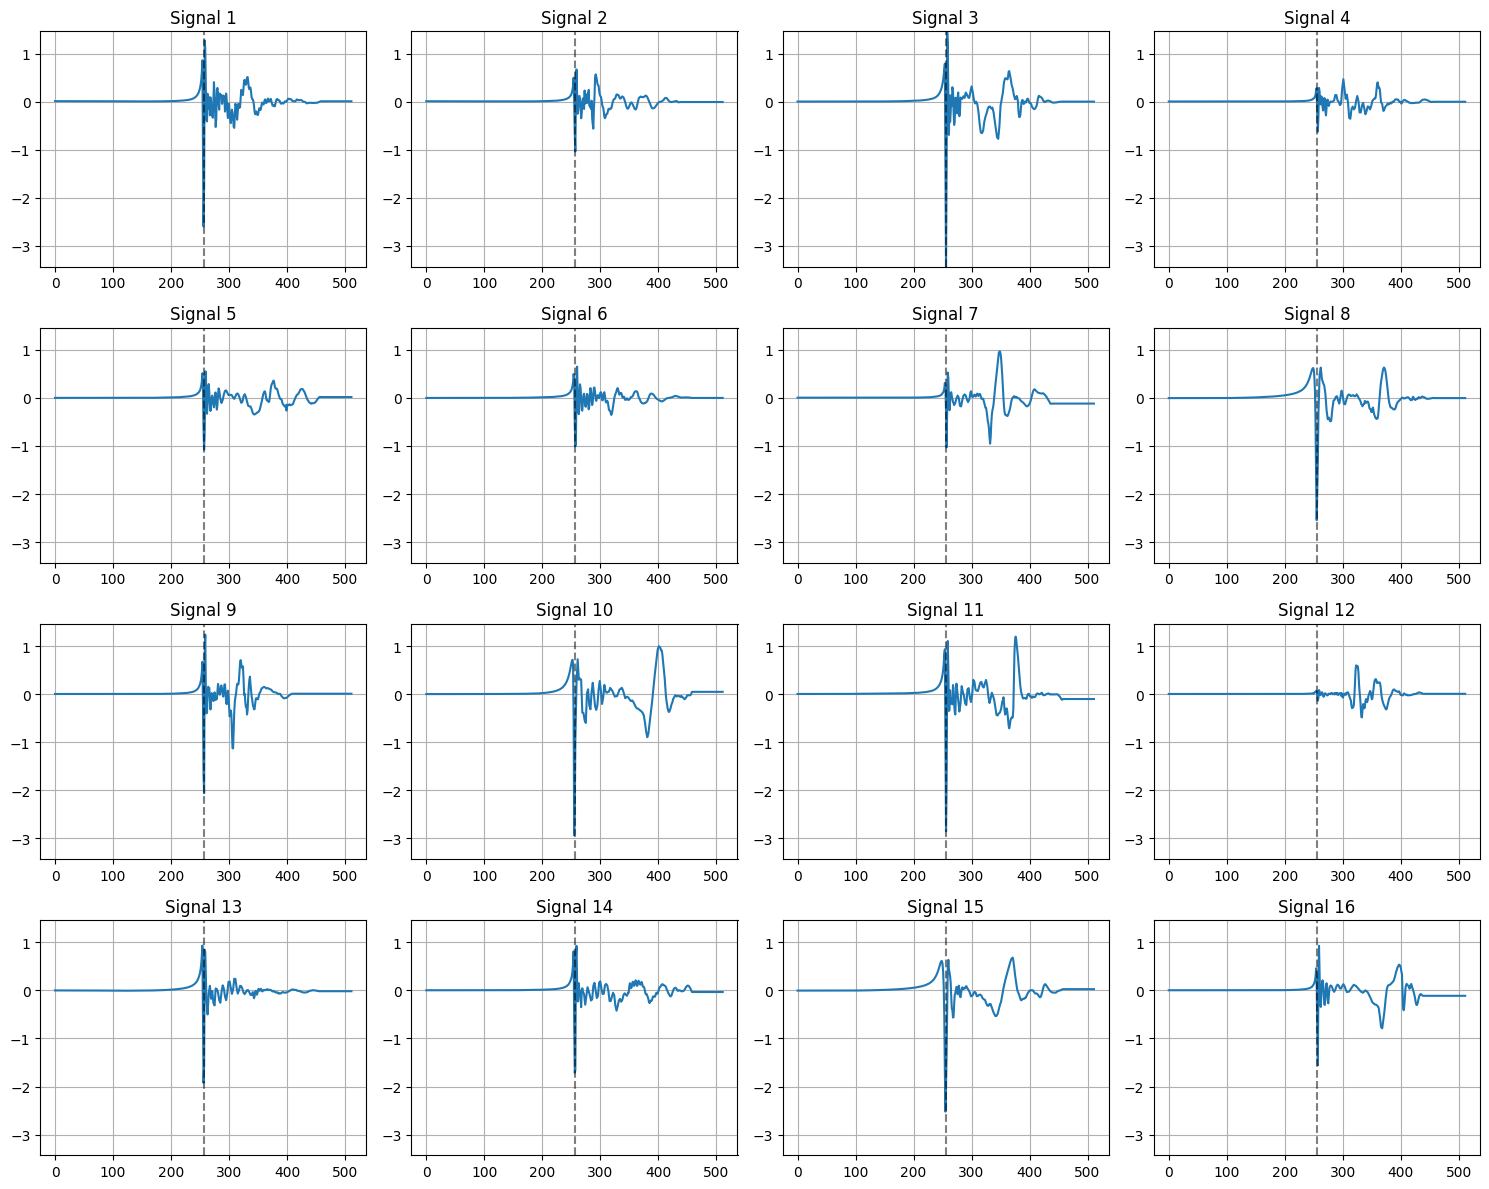

In [254]:
dataset = GWDataset("../data/gw-raw-data/richers_1764.csv", "../data/gw-raw-data/richers_1764_parameters.csv")
common_ylim_signal = dataset.get_common()
dataset.augmentation(6000)
dataset.calc_stats()
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

real_signals_batch, real_parameter_batch  = next(iter(dataloader))

common_ylim = (real_signals_batch[:,:,:].min(), real_signals_batch[:,:,:].max())
parameter_names = ['beta1_IC_b', 'A(km)', 'omega_0(rad|s)']

def plot_waveforms(real_signals_batch, real_parameter_batch):
    fig, axes = plt.subplots(4, 4, figsize=(15, 12))
    axes = axes.flatten()

    # Plot each signal on a separate subplot
    for i, ax in enumerate(axes):
        x = np.arange(real_signals_batch.size(dim=2))
        y = real_signals_batch[i, :, :].flatten()
        ax.plot(x, y)

        ax.axvline(x=256, color='black', linestyle='--', alpha=0.5)
        ax.set_title(f'Signal {i + 1}')
        ax.grid(True)
        ax.set_ylim(common_ylim)


        # Get parameter values as a NumPy array
        parameters = real_parameter_batch[i, :].numpy()[0]

        # Combine parameter names and values, format as a string
        # parameters_with_names = f'{parameter_names[0]}: {parameters[0]:.6f}\n{parameter_names[1]}: {parameters[1]:.2f}, {parameter_names[2]}: {parameters[2]:.2f}'
        # ax.set_xlabel(f'Parameters:\n{parameters_with_names}')

    for i in range(512, 8 * 4):
        fig.delaxes(axes[i])

    plt.tight_layout()

    plt.show()
    
plot_waveforms(real_signals_batch, real_parameter_batch)

In [255]:
dataset.__len__()

6000

### Evaluation Metrics for Data Augmentation

#### KL Distance

In [256]:
num_bins = 100

# Compute histograms of P and Q to represent their probability distributions
# density=True argument ensures that they represent probability distributions (i.e., the integral under each histogram sums to 1).
hist_P, bin_edges_P = np.histogram(dataset.augmented_data, bins=num_bins, density=True)
hist_Q, bin_edges_Q = np.histogram(dataset.original_data, bins=num_bins, density=True)

kl_divergence = entropy(hist_P, hist_Q)
print(kl_divergence)

inf


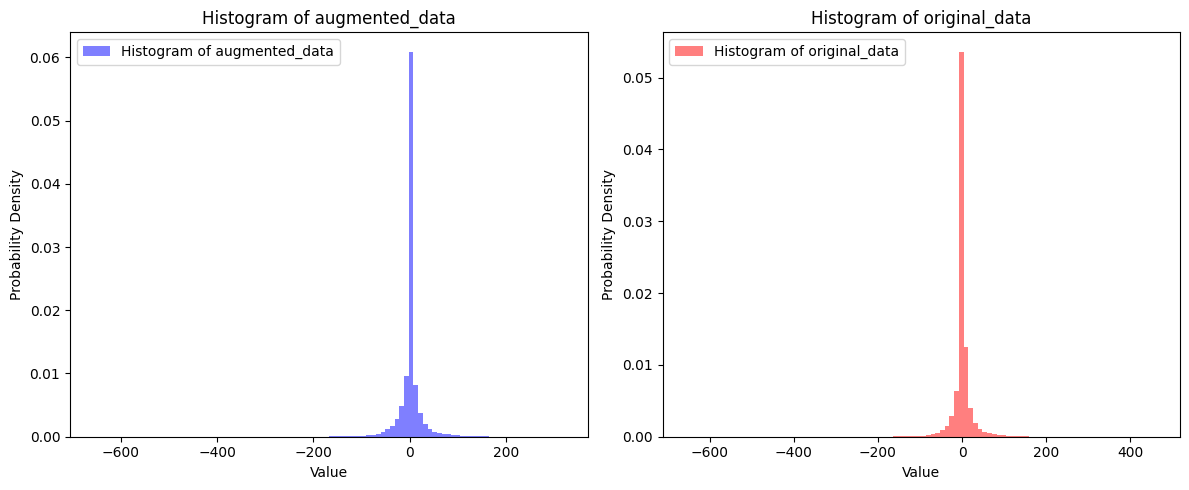

In [257]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].hist(bin_edges_P[:-1], bins=bin_edges_P, weights=hist_P, density=True, alpha=0.5, color='blue', label='Histogram of augmented_data')
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Probability Density')
axes[0].set_title('Histogram of augmented_data')
axes[0].legend(loc='best')

axes[1].hist(bin_edges_Q[:-1], bins=bin_edges_Q, weights=hist_Q, density=True, alpha=0.5, color='red', label='Histogram of original_data')
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Probability Density')
axes[1].set_title('Histogram of original_data')
axes[1].legend(loc='best')

plt.tight_layout()
plt.show()

Window warping appears to give quite a low KL distance, meaning that our original and augmented histogram of signal distributions are quite close. Jittering, scaling, and mixture augmentations appear to give infinite KL distances. This coukd be due to mainly altering the amplitude. Shifting gives low KL distances. Inconclusive on whether KL distance is a good metric or it's too sensitive to changes in the amplitude.

NOTE: This comparison is between the original data and ONLY the augmented data. The augmented and original data is combined to create the GAN training dataset.

#### PCA

In [258]:
# Assuming you have two datasets: dataset1 and dataset2
# Perform PCA on both datasets
pca = PCA(n_components=2)  # Choose the number of components
dataset1_pca = pca.fit_transform(dataset.original_data)
# dataset2_pca = pca.transform(dataset.augmented_data)
dataset2_pca = pca.fit_transform(dataset.data)

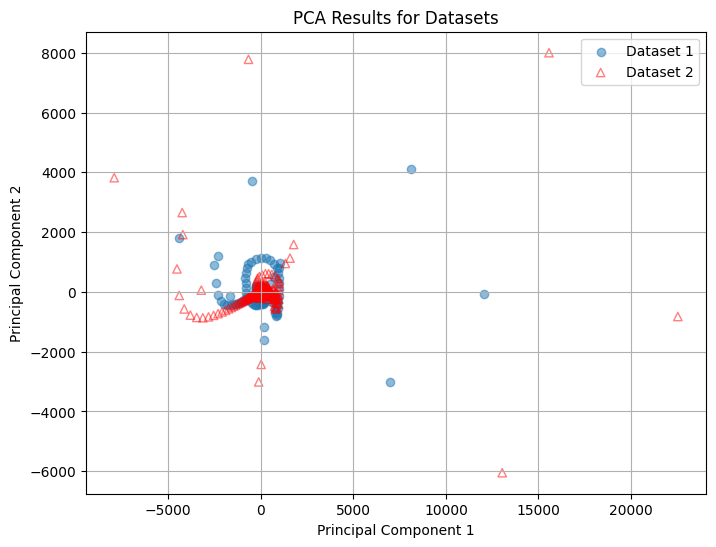

In [259]:

# Scatter plot for dataset1_pca with filled markers
plt.figure(figsize=(8, 6))
plt.scatter(dataset1_pca[:, 0], dataset1_pca[:, 1], label='Dataset 1', alpha=0.5, marker='o')  # 'o' represents filled circles

# Scatter plot for dataset2_pca with hollow markers
plt.scatter(dataset2_pca[:, 0], dataset2_pca[:, 1], label='Dataset 2', alpha=0.5, marker='^', facecolors='none', edgecolors='r')  # '^' represents unfilled triangles

plt.title('PCA Results for Datasets')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()

They look kinda similar??? Uh not sure what to say.

### Weight Initialisation (Random Noise)

In [260]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### Generator

In [261]:
if (gans_type == 'cdcgans'):
    class Generator(nn.Module):
        def __init__(self):
            super().__init__()
            self.z_reshape = nn.Sequential(
                nn.ConvTranspose1d(nz, ngf * 64, kernel_size=4, stride=1, padding=0, bias=False),
                # nn.BatchNorm1d(ngf * 64),
                nn.LeakyReLU(True)
            )
        
            self.y_reshape = nn.Sequential(
                # presuming that 10 is the number of class labels?
                nn.ConvTranspose1d(10, ngf * 64, kernel_size=4, stride=1, padding=0, bias=False),
                # nn.BatchNorm1d(ngf * 64),
                nn.LeakyReLU(True)
            )

            self.main = nn.Sequential(
                nn.ConvTranspose1d(ngf * 128, ngf * 64, kernel_size=4, stride=1, padding=0, bias=False),
                nn.BatchNorm1d(ngf * 64),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 64, ngf * 32, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf * 32),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 32, ngf * 16, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf * 16),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 16, ngf * 8, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf * 8),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 8, ngf * 4, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf * 4),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 4, ngf * 2, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf * 2),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 2, ngf, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf, nc, kernel_size=4, stride=2, padding=1, bias=False),
            )

        def forward(self, z, y):
            print(z.shape)
            print(y.shape)
            z = self.z_reshape(z)
            y = self.y_reshape(y)
            z = torch.cat([z, y], 1)
            z = self.main(z)
            return z

if gans_type == 'dcgans':
    class Generator(nn.Module):
        def __init__(self):
            super().__init__()
            self.main = nn.Sequential(
                nn.ConvTranspose1d(nz, ngf * 64, kernel_size=4, stride=1, padding=0, bias=False),
                nn.BatchNorm1d(ngf * 64),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 64, ngf * 32, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf * 32),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 32, ngf * 16, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf * 16),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 16, ngf * 8, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf * 8),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 8, ngf * 4, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf * 4),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 4, ngf * 2, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf * 2),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 2, ngf, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf, nc, kernel_size=4, stride=2, padding=1, bias=False),
            )

        def forward(self, z):
            z = self.main(z)
            return z
        
if gans_type == 'gans':
    class Generator(nn.Module):
        def __init__(self):
            super(Generator, self).__init__()
            self.main = nn.Sequential(
                nn.Linear(nz, ngf),
                nn.BatchNorm1d(ngf),
                nn.LeakyReLU(0.2, inplace=True),

                nn.Linear(ngf, ngf * 2),
                nn.BatchNorm1d(ngf * 2),
                nn.LeakyReLU(0.2, inplace=True),

                nn.Linear(ngf * 2, ngf * 4),
                nn.BatchNorm1d(ngf * 4),
                nn.LeakyReLU(0.2, inplace=True),

                nn.Linear(ngf * 4, ngf * 8),
                nn.BatchNorm1d(ngf * 8),
                nn.LeakyReLU(0.2, inplace=True),

                nn.Linear(ngf * 8, 512),
                # nn.Tanh()  # Tanh activation function for generating values between -1 and 1
            )

        def forward(self, z):
            z = z.view(z.size(0), -1)  # Flatten the tensor
            z = self.main(z)
            z = z.view(z.size(0), 1, 512)
            return z



In [262]:
netG = Generator().to(device)
netG.apply(weights_init)

print(netG)

if (gans_type == 'cdcgans'):
    model = Generator()
    summary(netG, input_size=[(nz, 1), (1, 1)])
if gans_type == 'dcgans' or gans_type == 'gans':
    model = Generator()
    summary(model, input_size=(nz, 1))

Generator(
  (main): Sequential(
    (0): ConvTranspose1d(100, 4096, kernel_size=(4,), stride=(1,), bias=False)
    (1): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=True)
    (3): ConvTranspose1d(4096, 2048, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (4): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=True)
    (6): ConvTranspose1d(2048, 1024, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (7): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=True)
    (9): ConvTranspose1d(1024, 512, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (10): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=True)
    (12): ConvTranspose1d(512, 256, kernel_size=(4,), stride=(2,), padding=(1,), b

### Discriminator

In [263]:
if (gans_type == "cdcgans"):
    class Discriminator(nn.Module):
        def __init__(self):
            super().__init__()

            self.x_reshape = nn.Sequential(
                nn.Conv1d(nc, ndf, kernel_size=4, stride=2, padding=1, bias=False),
                nn.LeakyReLU(0.2),
            )

            self.y_reshape = nn.Sequential(
                nn.Embedding(10, 50),
                nn.Conv1d(10, ndf, kernel_size=4, stride=2, padding=1, bias=False),
                nn.LeakyReLU(0.2),
            )

            self.main = nn.Sequential(
                # nn.Conv1d(nc, ndf, kernel_size=4, stride=2, padding=1, bias=False),
                # nn.LeakyReLU(0.2, inplace=True),
                # nn.Dropout(0.2),

                nn.Conv1d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 2),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.2),

                nn.Conv1d(ndf * 2, ndf * 4, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 4),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.2),

                nn.Conv1d(ndf * 4, ndf * 8, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 8),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.2),

                nn.Conv1d(ndf * 8, ndf * 16, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 16),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.2),

                nn.Conv1d(ndf * 16, ndf * 32, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 32),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.2),

                nn.Conv1d(ndf * 32, ndf * 64, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 64),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.2),
                
                nn.Conv1d(ndf * 64, nc, kernel_size=4,
                        stride=2, padding=0, bias=False)
            )

            self.fc = nn.Sequential(
                nn.Dropout(0.2),
                nn.Sigmoid()
            )

        def forward(self, x, y):
            x = self.x_reshape(x)
            print(x.shape)
            y = self.y_reshape(y)
            x = torch.cat([x, y], 1)
            x = self.main(x)
            x = x.view(x.shape[0], -1)  # Flatten the tensor
            x = self.fc(x)
            return x

elif (gans_type == "dcgans"):
    class Discriminator(nn.Module):
        def __init__(self):
            super(Discriminator, self).__init__()
            self.main = nn.Sequential(
                nn.Conv1d(nc, ndf, kernel_size=4, stride=2, padding=1, bias=False),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout2d(0.2),

                nn.Conv1d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 2),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout2d(0.2),

                nn.Conv1d(ndf * 2, ndf * 4, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 4),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout2d(0.2),

                nn.Conv1d(ndf * 4, ndf * 8, kernel_size=4,
                        stride=2, padding=1, bias=False),
                # nn.BatchNorm1d(ndf * 8),
                # nn.LeakyReLU(0.2, inplace=True),
                # nn.Dropout2d(0.2),

                # nn.Conv1d(ndf * 8, ndf * 16, kernel_size=4,
                #         stride=2, padding=1, bias=False),
                # nn.BatchNorm1d(ndf * 16),
                # nn.LeakyReLU(0.2, inplace=True),
                # nn.Dropout2d(0.2),

                # nn.Conv1d(ndf * 16, ndf * 32, kernel_size=4,
                #         stride=2, padding=1, bias=False),
                # nn.BatchNorm1d(ndf * 32),
                # nn.LeakyReLU(0.2, inplace=True),
                # nn.Dropout2d(0.2),

                # nn.Conv1d(ndf * 32, ndf * 64, kernel_size=4,
                #         stride=2, padding=1, bias=False),
                # nn.BatchNorm1d(ndf * 64),
                # nn.LeakyReLU(0.2, inplace=True),
                # nn.Dropout2d(0.2),
                
                # nn.Conv1d(ndf * 64, nc, kernel_size=4,
                #         stride=2, padding=0, bias=False)
            )

            self.fc = nn.Sequential(
                nn.Linear(ndf * 256, 1),
                nn.Dropout(0.2),
                nn.Sigmoid()
            )

        def forward(self, x):
            x = self.main(x)
            x = x.view(x.shape[0], -1)  # Flatten the tensor
            x = self.fc(x)
            return x

elif (gans_type == "gans"):
    class Discriminator(nn.Module):
        def __init__(self):
            super(Discriminator, self).__init__()
            self.main = nn.Sequential(
                nn.Linear(512, 256),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.2),

                nn.Linear(256, 128),
                # nn.BatchNorm1d(128),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.2),

                nn.Linear(128, 64),
                # nn.BatchNorm1d(64),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.2),

                nn.Linear(64, 32),
                # nn.BatchNorm1d(32),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.2),

                nn.Linear(32, 16),
                # nn.BatchNorm1d(16),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.2)
            )

            self.fc = nn.Sequential(
                nn.Linear(16, 1),
                nn.Sigmoid()
            )

        def forward(self, x):
            x = x.view(x.size(0), -1)  # Flatten the tensor
            x = self.main(x)
            x = self.fc(x)
            return x


In [264]:
netD = Discriminator().to(device)
netD.apply(weights_init)

print(netD)

if (gans_type == "cdcgans"):
    model = Discriminator()
    summary(model, input_size=[(1, 512), (1, 1)])
if gans_type == 'dcgans' or gans_type == 'gans':
    model = Discriminator()
    summary(model, input_size=(1, 512))

Discriminator(
  (main): Sequential(
    (0): Conv1d(1, 64, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout2d(p=0.2, inplace=False)
    (3): Conv1d(64, 128, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Dropout2d(p=0.2, inplace=False)
    (7): Conv1d(128, 256, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (8): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Dropout2d(p=0.2, inplace=False)
    (11): Conv1d(256, 512, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=16384, out_features=1, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): Sigmoid()
  )
)
---------------------

/Users/tarineccleston/Documents/software-ds/gravitational-waves/gw-env/lib/python3.9/site-packages/torch/nn/functional.py:1338: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn("dropout2d: Received a 3D input to dropout2d and assuming that channel-wise "


### Loss functions and Optimisers

In [265]:
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
# the progression of the generator
fixed_noise = torch.randn(batch_size, nz, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.0
fake_label = 0.0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr_d, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr_g, betas=(beta1, 0.999))

# learning-rate decay scheduler
schedulerD = lr_scheduler.LinearLR(optimizerD, start_factor=1.0, end_factor=0.5, total_iters=30)
schedulerG = lr_scheduler.LinearLR(optimizerG, start_factor=1.0, end_factor=0.5, total_iters=30)

### Training

Starting Training Loop...
[0/32][0/188]	Loss_D: 1.4271	Loss_G: 0.7429	D(x): 0.5003	D(G(z)): 0.4867 / 0.5181
[0/32][50/188]	Loss_D: 0.7893	Loss_G: 1.1817	D(x): 0.2026	D(G(z)): 0.6609 / 0.6621
[0/32][100/188]	Loss_D: 0.7757	Loss_G: 1.5884	D(x): 0.1984	D(G(z)): 0.6851 / 0.7683
[0/32][150/188]	Loss_D: 0.7701	Loss_G: 1.9186	D(x): 0.1954	D(G(z)): 0.7367 / 0.7861
Epoch 0: SGD Discriminator lr 0.0000200 -> 0.0000197
Epoch 0: SGD Generator lr 0.0000200 -> 0.0000197


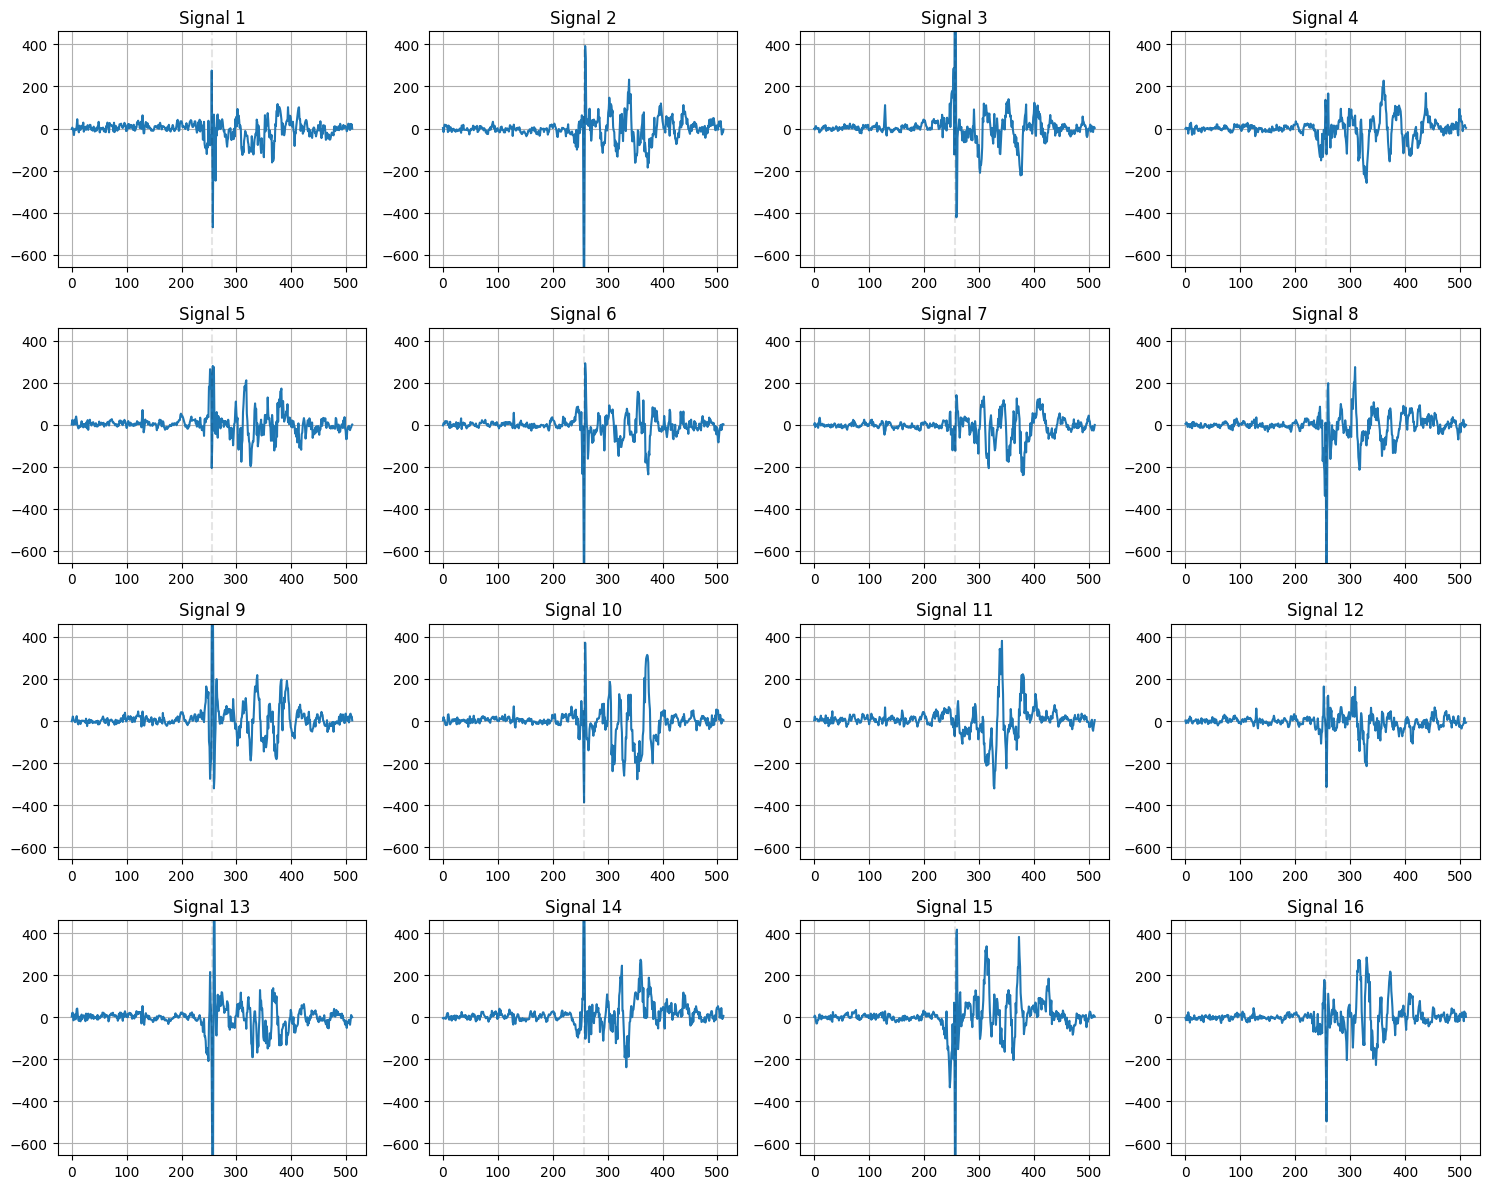

[1/32][0/188]	Loss_D: 0.7202	Loss_G: 1.3357	D(x): 0.1722	D(G(z)): 0.7206 / 0.6964
[1/32][50/188]	Loss_D: 0.7456	Loss_G: 1.2852	D(x): 0.1898	D(G(z)): 0.6953 / 0.6537
[1/32][100/188]	Loss_D: 0.7739	Loss_G: 1.5179	D(x): 0.2098	D(G(z)): 0.7343 / 0.6992
[1/32][150/188]	Loss_D: 0.6632	Loss_G: 1.8241	D(x): 0.1330	D(G(z)): 0.7331 / 0.7788
Epoch 1: SGD Discriminator lr 0.0000197 -> 0.0000193
Epoch 1: SGD Generator lr 0.0000197 -> 0.0000193


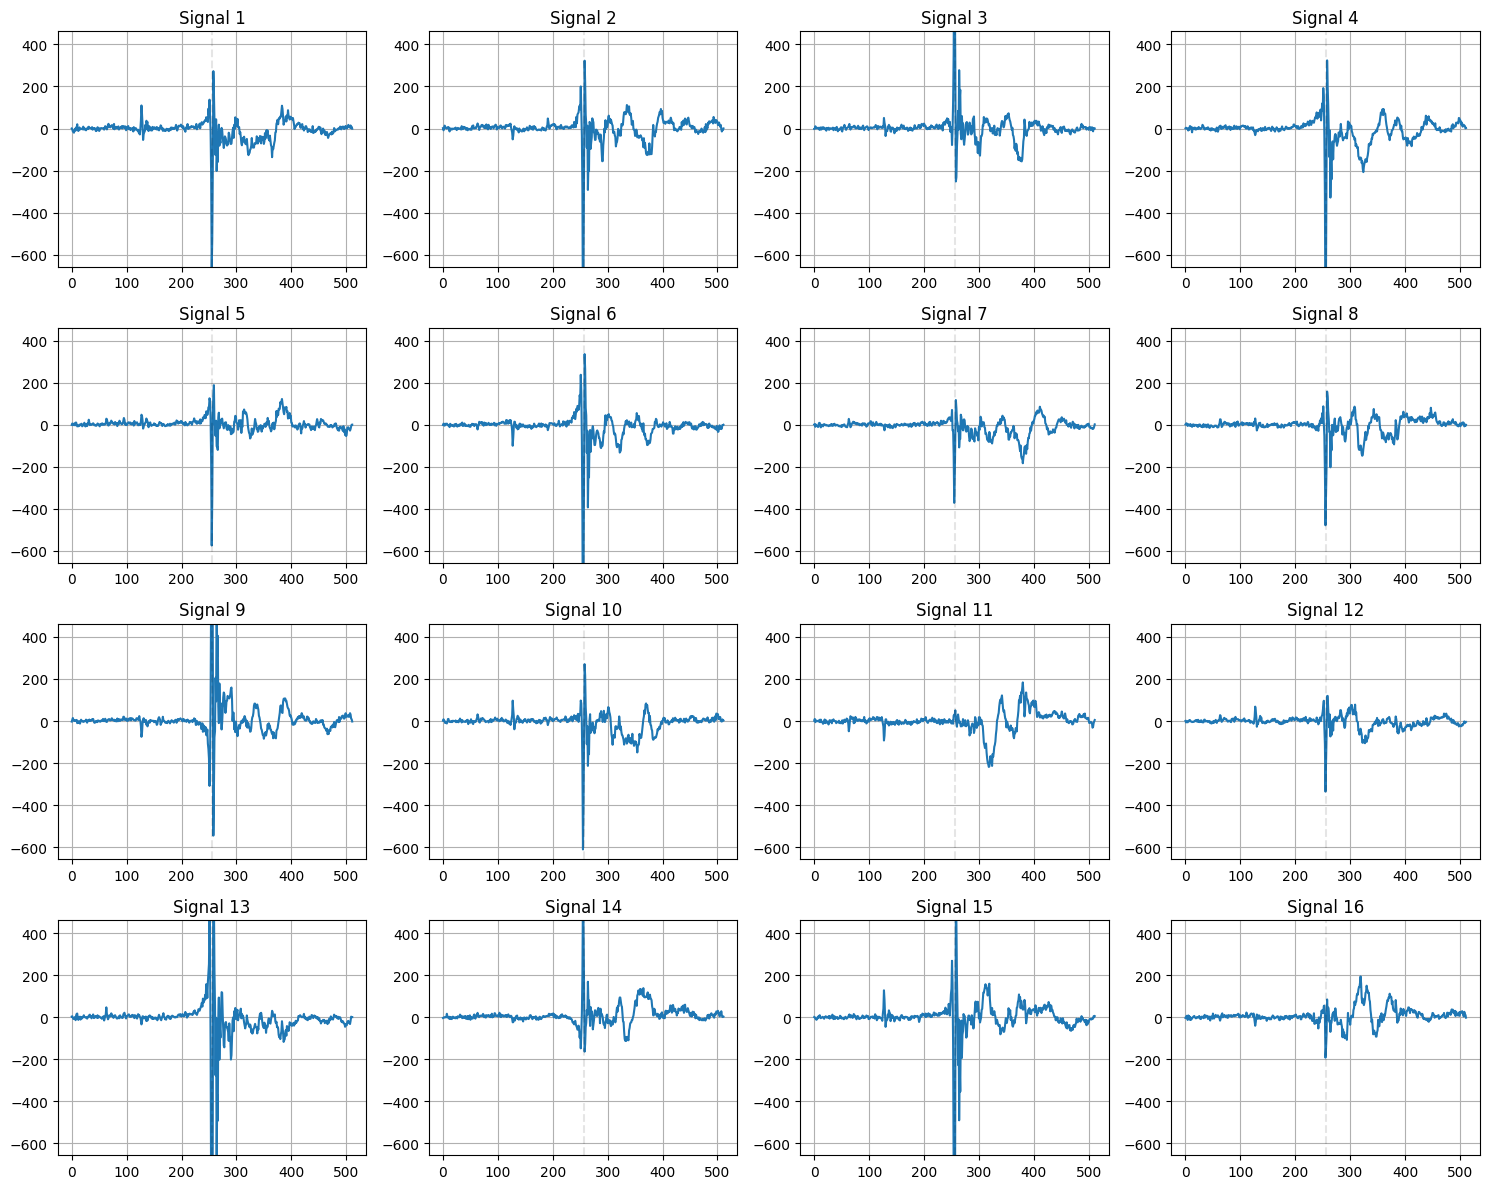

[2/32][0/188]	Loss_D: 0.7012	Loss_G: 1.8794	D(x): 0.1444	D(G(z)): 0.7537 / 0.7961
[2/32][50/188]	Loss_D: 0.5884	Loss_G: 1.9021	D(x): 0.0954	D(G(z)): 0.8706 / 0.7913
[2/32][100/188]	Loss_D: 0.6553	Loss_G: 1.8734	D(x): 0.1371	D(G(z)): 0.7408 / 0.8091
[2/32][150/188]	Loss_D: 0.6948	Loss_G: 1.4176	D(x): 0.1293	D(G(z)): 0.7404 / 0.7118
Epoch 2: SGD Discriminator lr 0.0000193 -> 0.0000190
Epoch 2: SGD Generator lr 0.0000193 -> 0.0000190


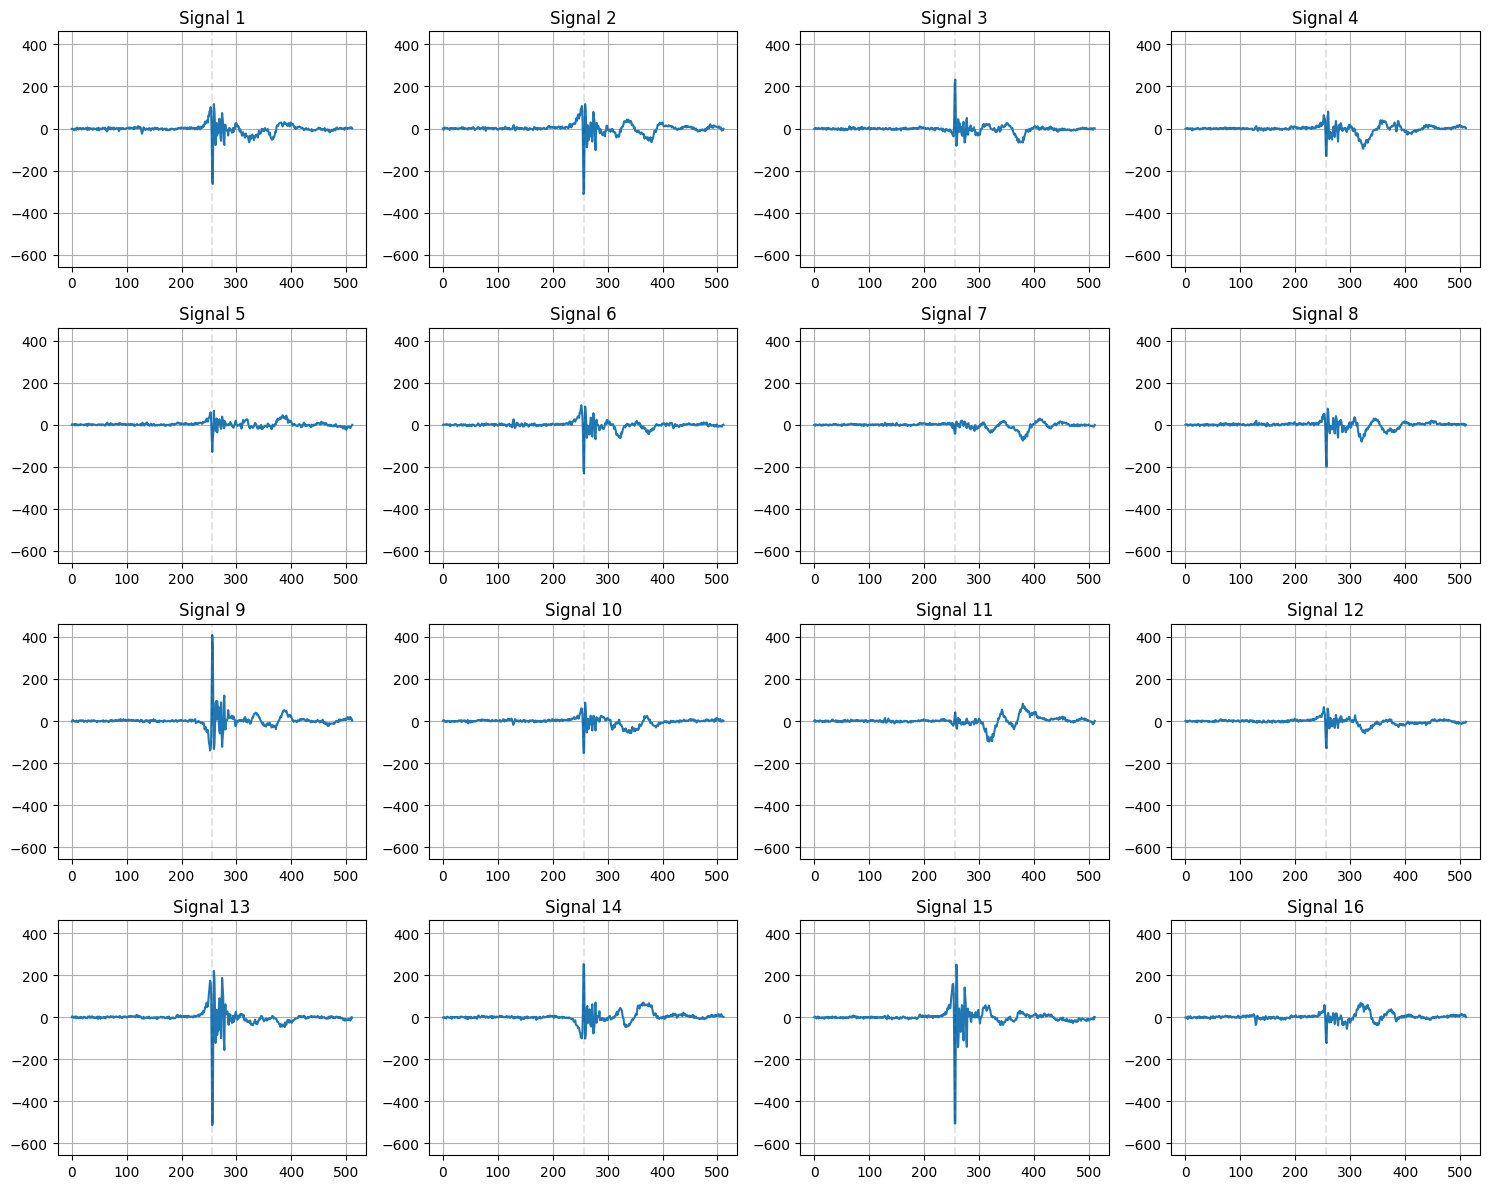

[3/32][0/188]	Loss_D: 0.6540	Loss_G: 2.0533	D(x): 0.1810	D(G(z)): 0.8494 / 0.8415
[3/32][50/188]	Loss_D: 0.7463	Loss_G: 2.0911	D(x): 0.1665	D(G(z)): 0.7532 / 0.7958
[3/32][100/188]	Loss_D: 0.6616	Loss_G: 2.6006	D(x): 0.0990	D(G(z)): 0.8937 / 0.8530
[3/32][150/188]	Loss_D: 0.6174	Loss_G: 1.6477	D(x): 0.1055	D(G(z)): 0.7722 / 0.7420
Epoch 3: SGD Discriminator lr 0.0000190 -> 0.0000187
Epoch 3: SGD Generator lr 0.0000190 -> 0.0000187


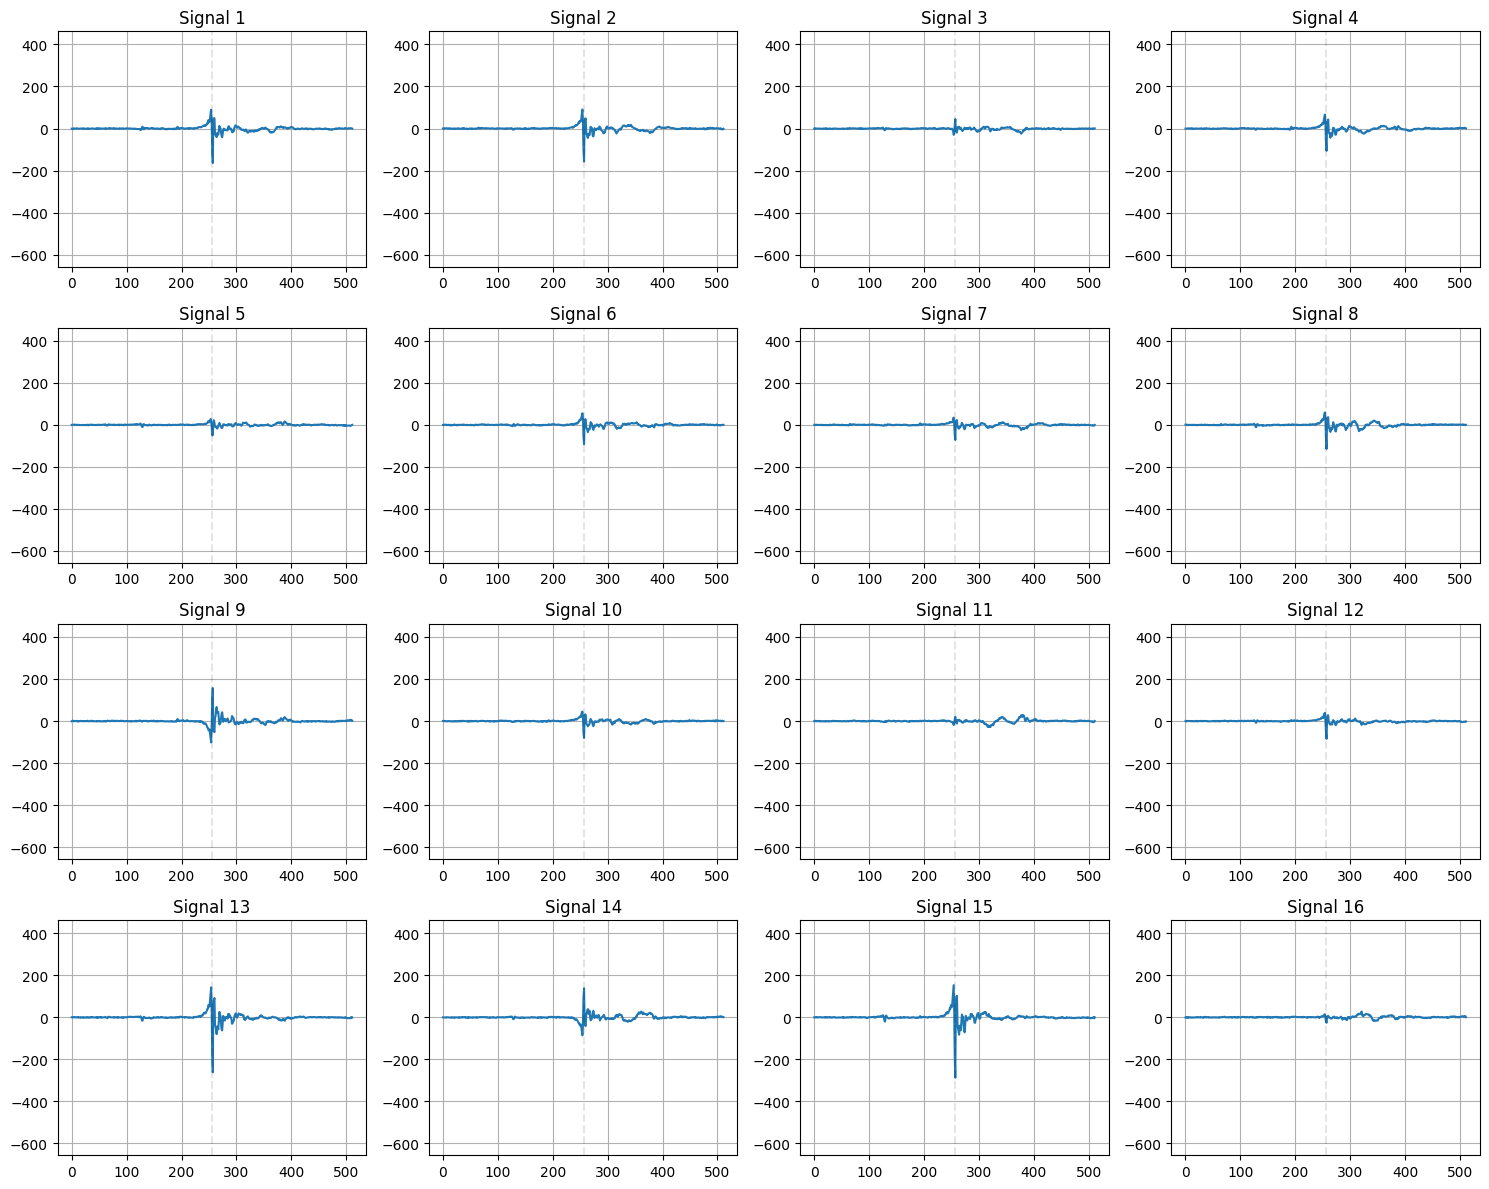

[4/32][0/188]	Loss_D: 0.7172	Loss_G: 2.1154	D(x): 0.1412	D(G(z)): 0.7587 / 0.8135
[4/32][50/188]	Loss_D: 0.6379	Loss_G: 1.9587	D(x): 0.1292	D(G(z)): 0.8518 / 0.8091
[4/32][100/188]	Loss_D: 0.5786	Loss_G: 1.7343	D(x): 0.0873	D(G(z)): 0.7774 / 0.7723
[4/32][150/188]	Loss_D: 0.7899	Loss_G: 2.3212	D(x): 0.1470	D(G(z)): 0.8283 / 0.8275
Epoch 4: SGD Discriminator lr 0.0000187 -> 0.0000183
Epoch 4: SGD Generator lr 0.0000187 -> 0.0000183


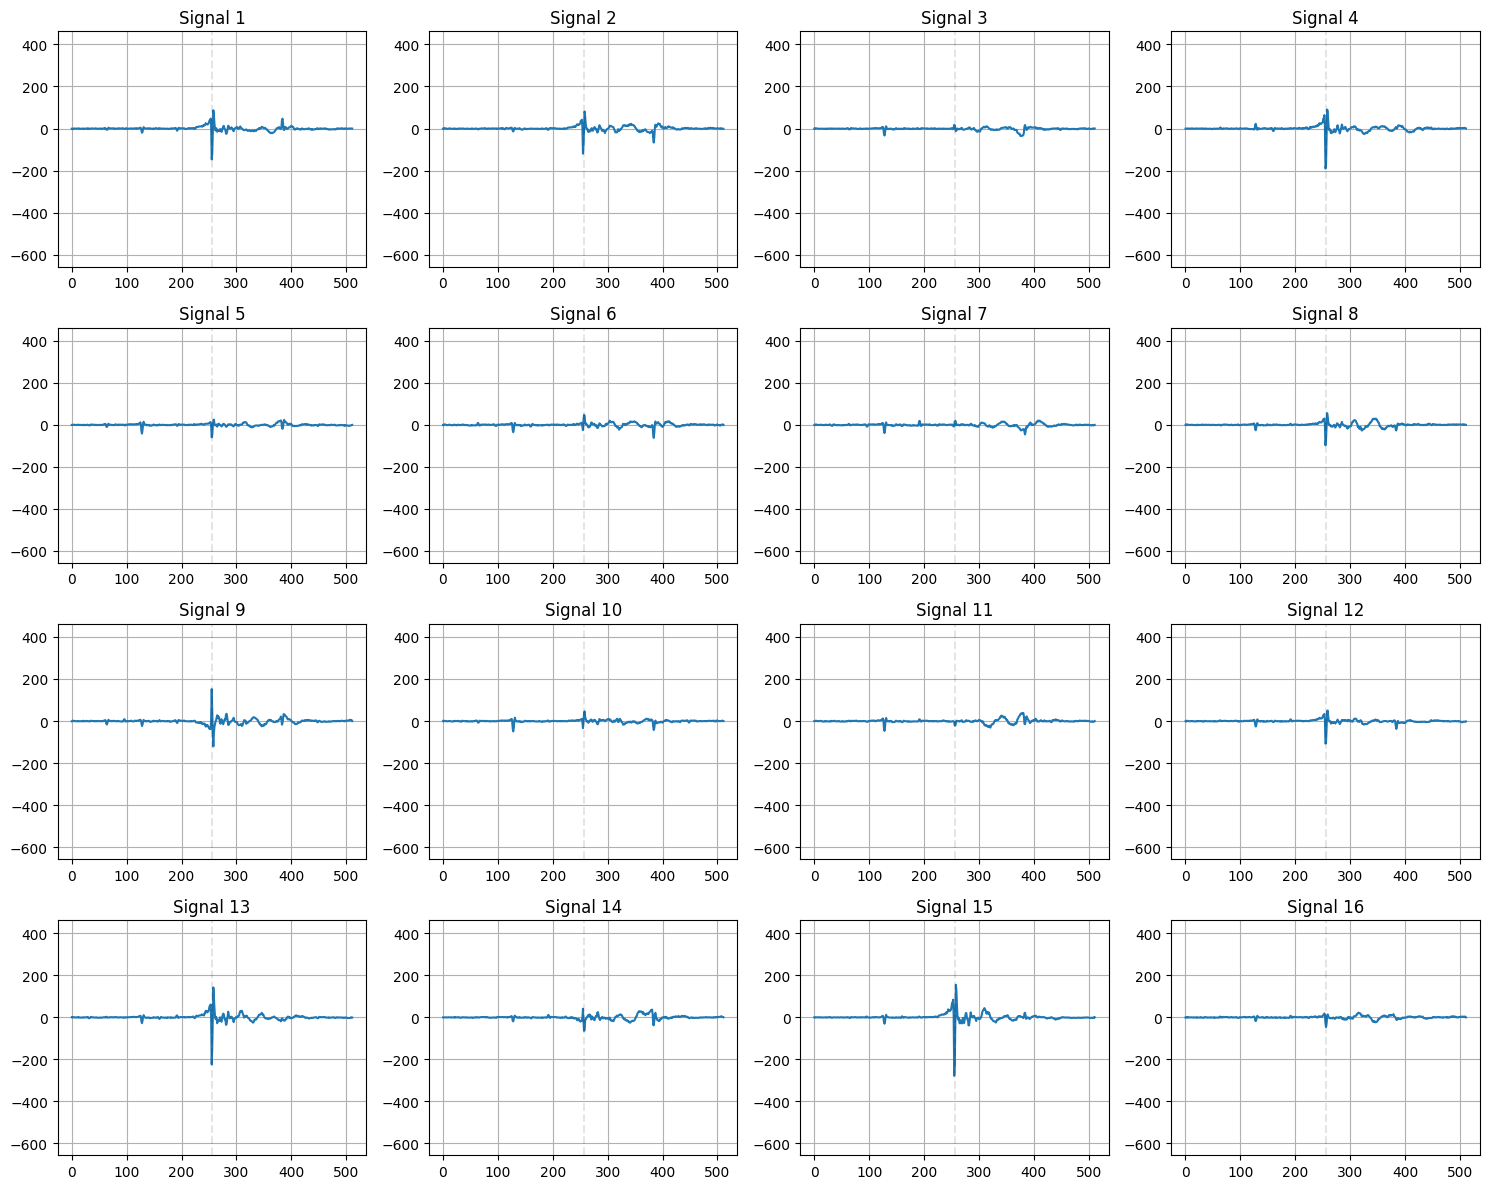

[5/32][0/188]	Loss_D: 0.6069	Loss_G: 1.7463	D(x): 0.1028	D(G(z)): 0.7887 / 0.7671
[5/32][50/188]	Loss_D: 0.6710	Loss_G: 1.9889	D(x): 0.1105	D(G(z)): 0.7754 / 0.7716
[5/32][100/188]	Loss_D: 0.6284	Loss_G: 2.6206	D(x): 0.1042	D(G(z)): 0.8342 / 0.8489
[5/32][150/188]	Loss_D: 0.6817	Loss_G: 2.1673	D(x): 0.1475	D(G(z)): 0.7329 / 0.8089
Epoch 5: SGD Discriminator lr 0.0000183 -> 0.0000180
Epoch 5: SGD Generator lr 0.0000183 -> 0.0000180


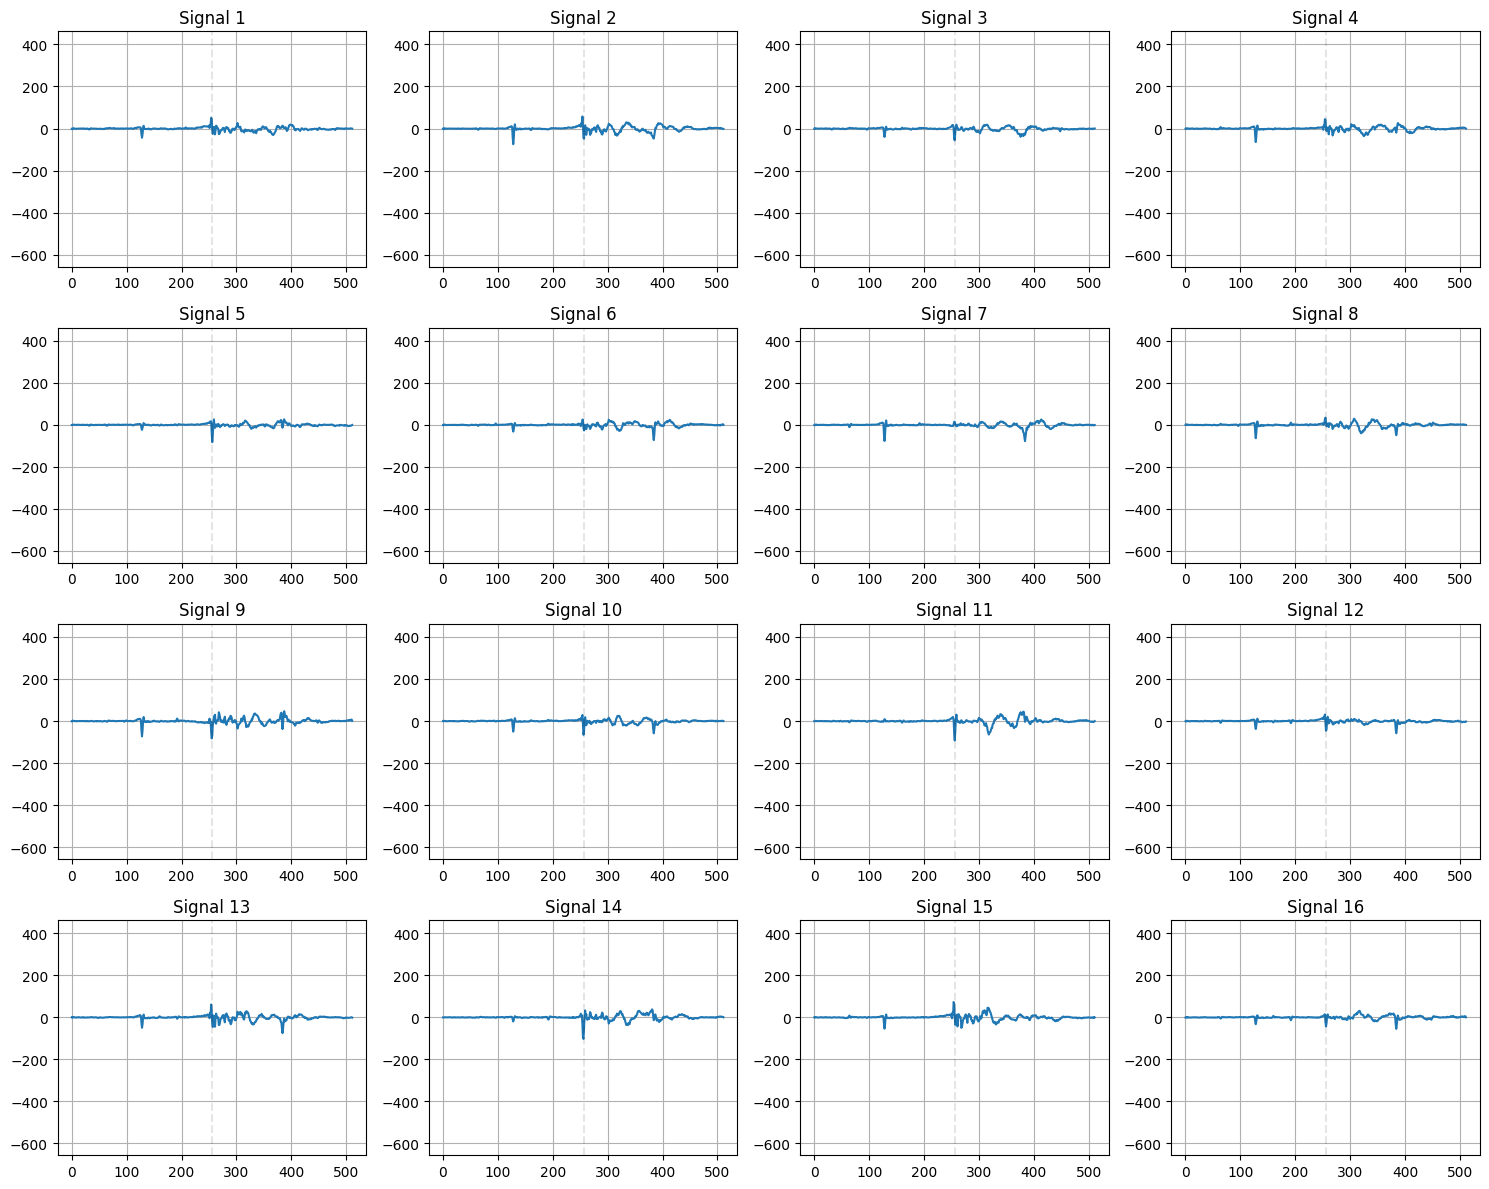

[6/32][0/188]	Loss_D: 0.6972	Loss_G: 2.3548	D(x): 0.1204	D(G(z)): 0.7835 / 0.7950
[6/32][50/188]	Loss_D: 0.7182	Loss_G: 2.2010	D(x): 0.1414	D(G(z)): 0.7732 / 0.8096
[6/32][100/188]	Loss_D: 0.5956	Loss_G: 1.8316	D(x): 0.1162	D(G(z)): 0.7701 / 0.7802
[6/32][150/188]	Loss_D: 0.7167	Loss_G: 1.9820	D(x): 0.1757	D(G(z)): 0.7595 / 0.7883
Epoch 6: SGD Discriminator lr 0.0000180 -> 0.0000177
Epoch 6: SGD Generator lr 0.0000180 -> 0.0000177


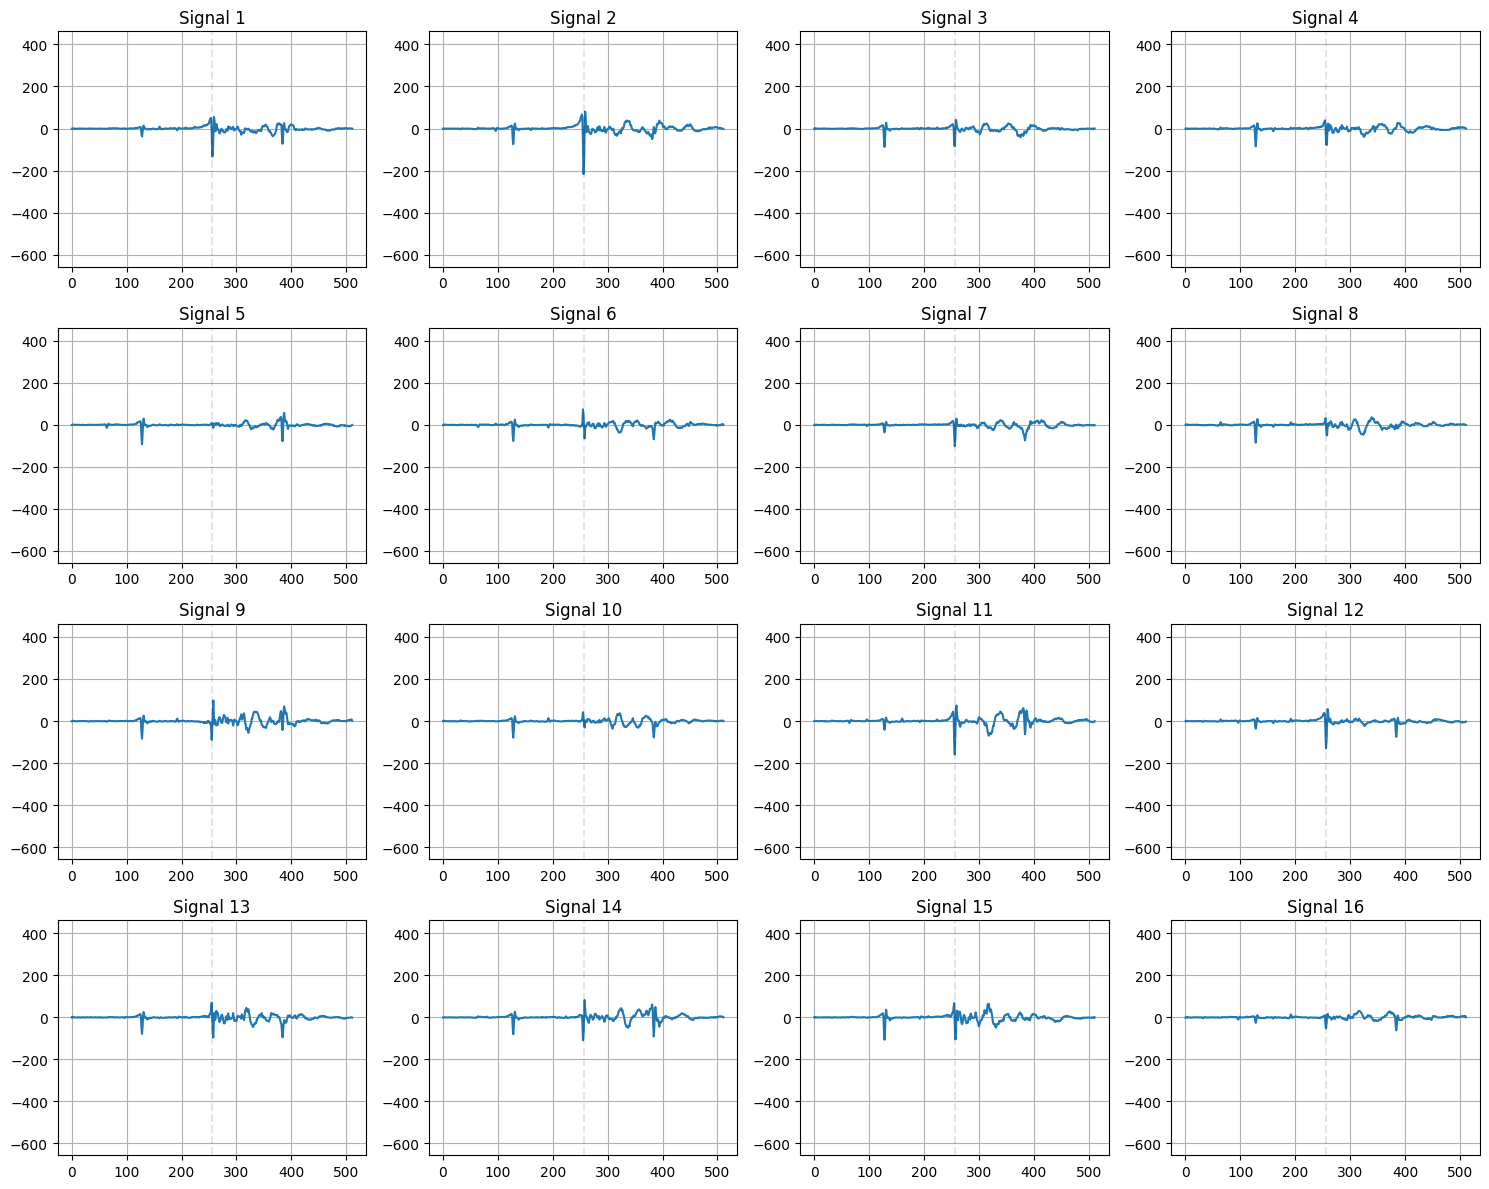

[7/32][0/188]	Loss_D: 0.6458	Loss_G: 1.7315	D(x): 0.0946	D(G(z)): 0.7637 / 0.7295
[7/32][50/188]	Loss_D: 0.6158	Loss_G: 1.7923	D(x): 0.0806	D(G(z)): 0.7611 / 0.7570
[7/32][100/188]	Loss_D: 0.7482	Loss_G: 2.2683	D(x): 0.1229	D(G(z)): 0.6672 / 0.8311
[7/32][150/188]	Loss_D: 0.4931	Loss_G: 2.1467	D(x): 0.0508	D(G(z)): 0.8769 / 0.7801
Epoch 7: SGD Discriminator lr 0.0000177 -> 0.0000173
Epoch 7: SGD Generator lr 0.0000177 -> 0.0000173


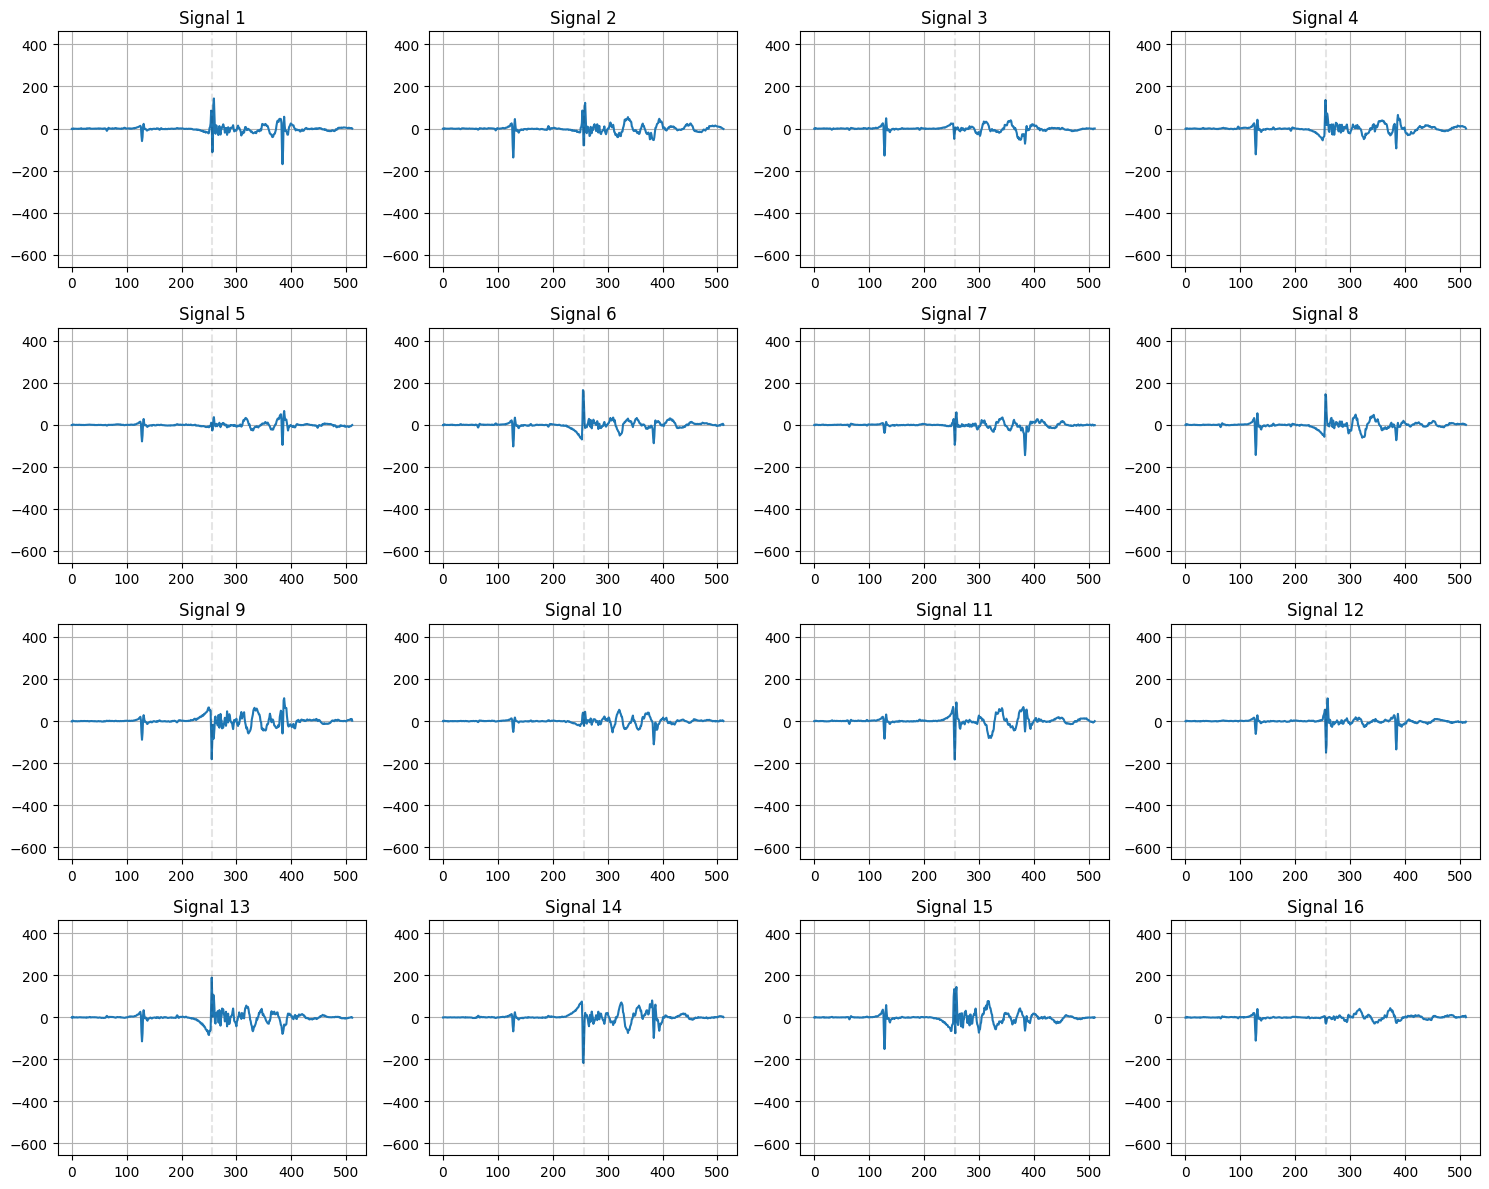

[8/32][0/188]	Loss_D: 0.7780	Loss_G: 2.1613	D(x): 0.1633	D(G(z)): 0.7222 / 0.7955
[8/32][50/188]	Loss_D: 0.6801	Loss_G: 1.8204	D(x): 0.1053	D(G(z)): 0.8078 / 0.7770
[8/32][100/188]	Loss_D: 0.7556	Loss_G: 2.3521	D(x): 0.1820	D(G(z)): 0.7271 / 0.8280
[8/32][150/188]	Loss_D: 0.7054	Loss_G: 1.6659	D(x): 0.1084	D(G(z)): 0.6369 / 0.7438
Epoch 8: SGD Discriminator lr 0.0000173 -> 0.0000170
Epoch 8: SGD Generator lr 0.0000173 -> 0.0000170


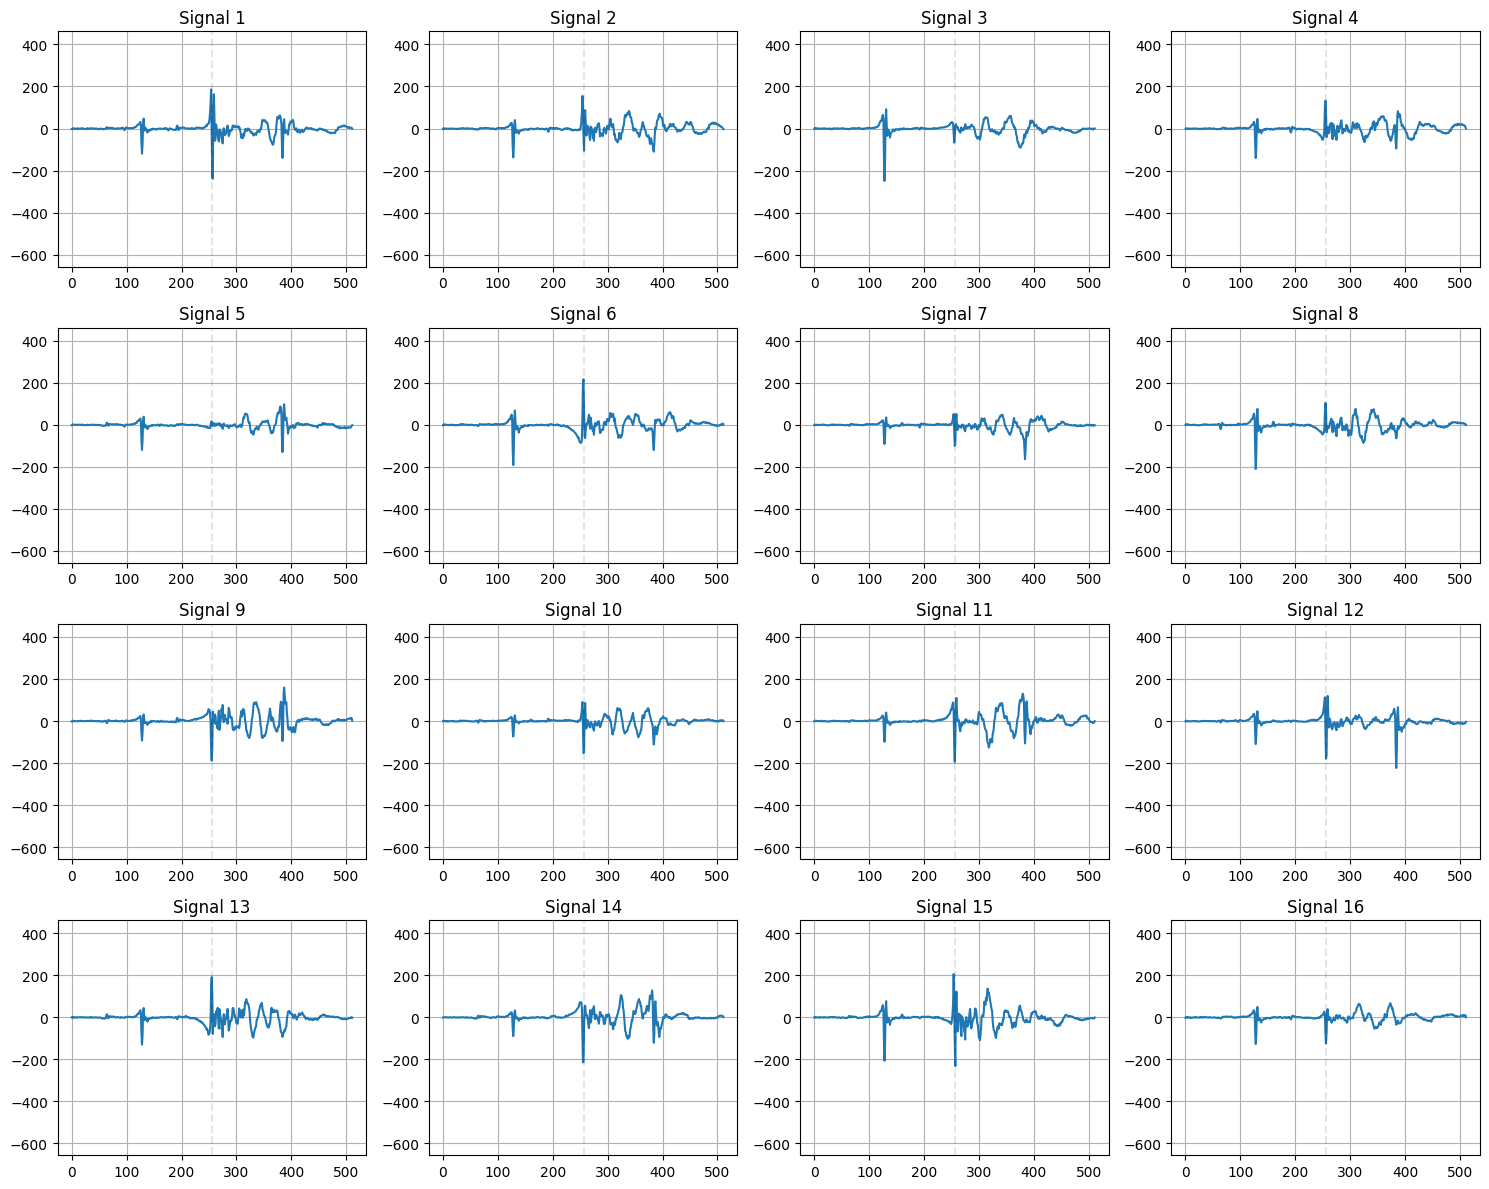

[9/32][0/188]	Loss_D: 0.7129	Loss_G: 1.4671	D(x): 0.1226	D(G(z)): 0.6335 / 0.6954
[9/32][50/188]	Loss_D: 0.5861	Loss_G: 2.0328	D(x): 0.1157	D(G(z)): 0.8604 / 0.7767
[9/32][100/188]	Loss_D: 0.6497	Loss_G: 2.0918	D(x): 0.1168	D(G(z)): 0.7453 / 0.8038
[9/32][150/188]	Loss_D: 0.7378	Loss_G: 1.8856	D(x): 0.1577	D(G(z)): 0.7541 / 0.7950
Epoch 9: SGD Discriminator lr 0.0000170 -> 0.0000167
Epoch 9: SGD Generator lr 0.0000170 -> 0.0000167


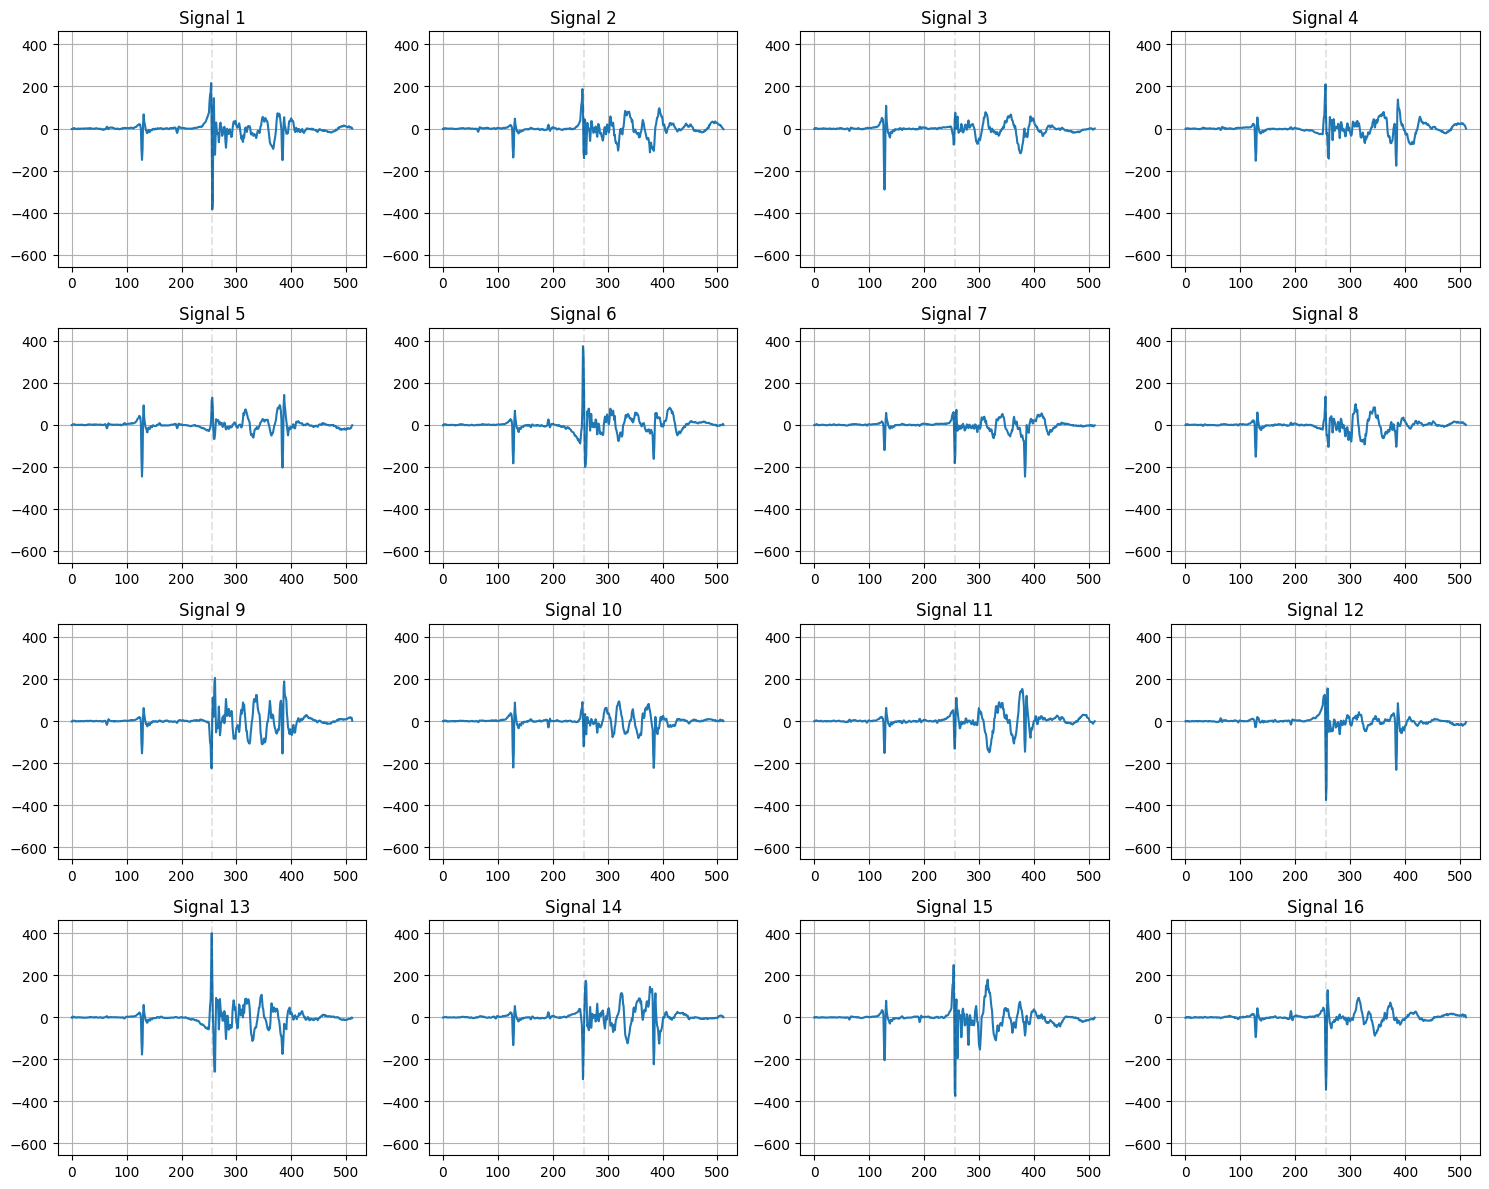

[10/32][0/188]	Loss_D: 0.6765	Loss_G: 1.8949	D(x): 0.1281	D(G(z)): 0.7494 / 0.7664
[10/32][50/188]	Loss_D: 0.6066	Loss_G: 1.8422	D(x): 0.1261	D(G(z)): 0.8339 / 0.7576
[10/32][100/188]	Loss_D: 0.6759	Loss_G: 1.8401	D(x): 0.1653	D(G(z)): 0.7928 / 0.7780
[10/32][150/188]	Loss_D: 0.6584	Loss_G: 2.2543	D(x): 0.1026	D(G(z)): 0.8376 / 0.8186
Epoch 10: SGD Discriminator lr 0.0000167 -> 0.0000163
Epoch 10: SGD Generator lr 0.0000167 -> 0.0000163


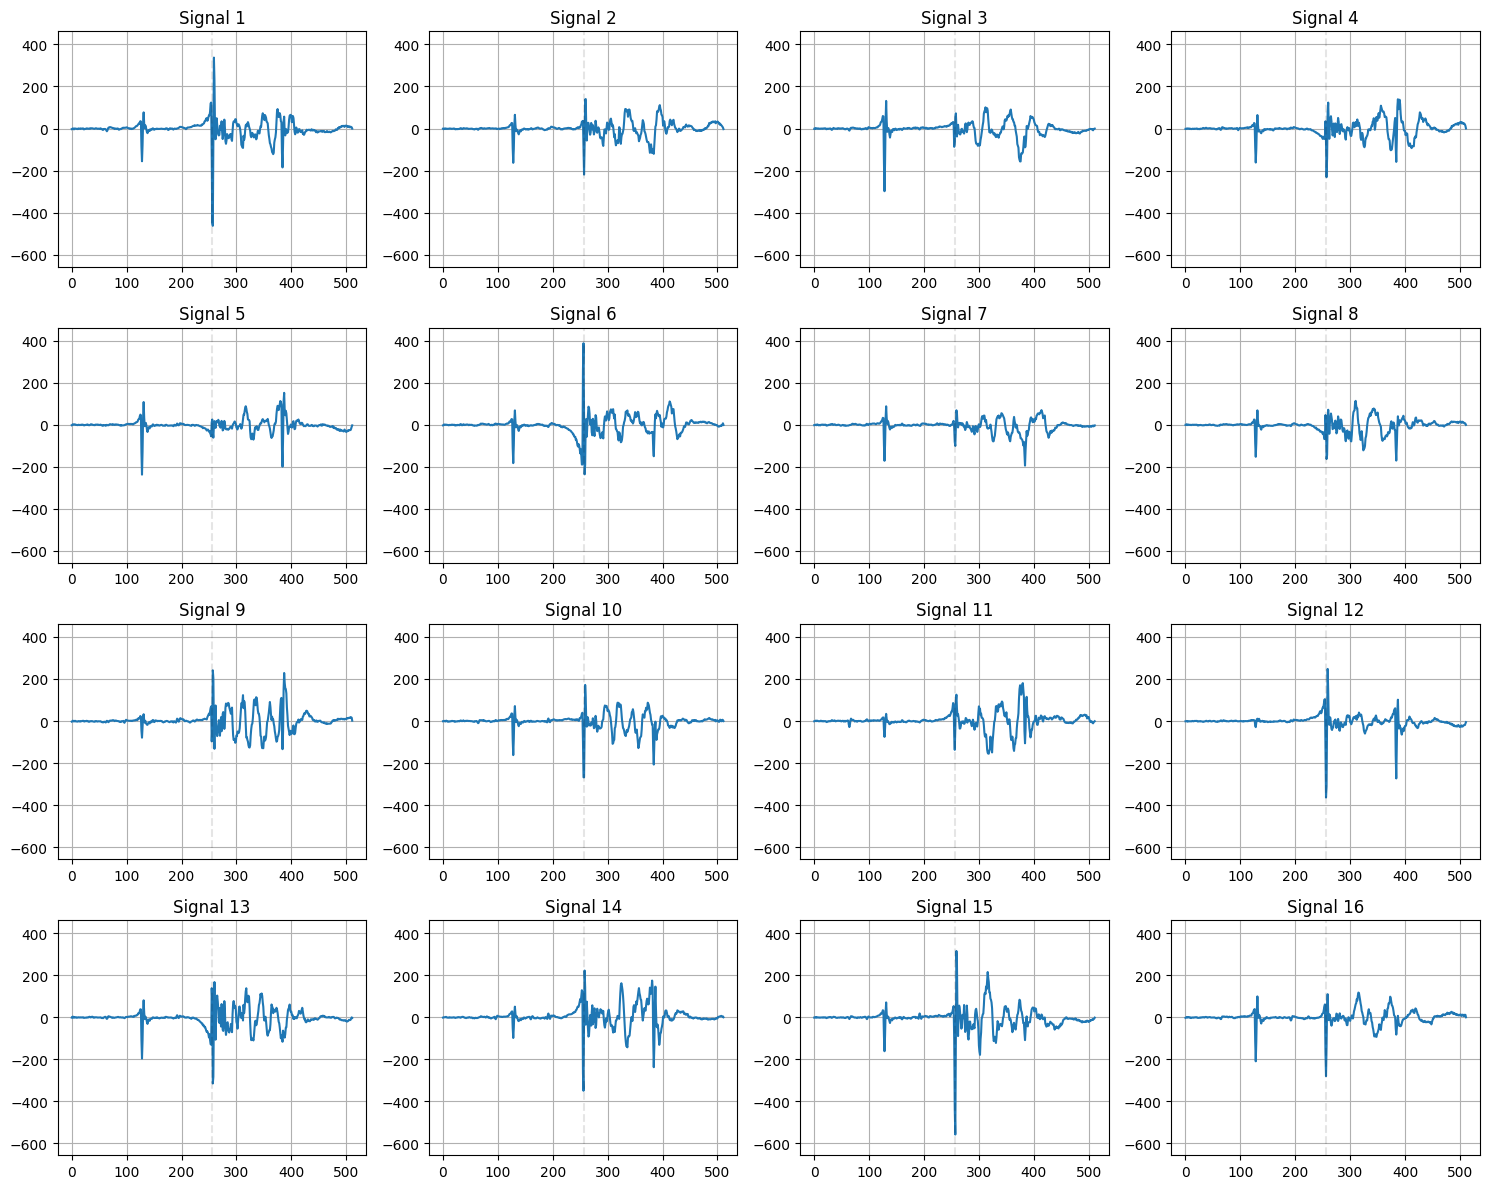

[11/32][0/188]	Loss_D: 0.6674	Loss_G: 2.3134	D(x): 0.1134	D(G(z)): 0.8066 / 0.8370
[11/32][50/188]	Loss_D: 0.6553	Loss_G: 1.7640	D(x): 0.1254	D(G(z)): 0.7504 / 0.7506
[11/32][100/188]	Loss_D: 0.7520	Loss_G: 1.7839	D(x): 0.1698	D(G(z)): 0.7207 / 0.7655
[11/32][150/188]	Loss_D: 0.6308	Loss_G: 1.7476	D(x): 0.1147	D(G(z)): 0.7361 / 0.7791
Epoch 11: SGD Discriminator lr 0.0000163 -> 0.0000160
Epoch 11: SGD Generator lr 0.0000163 -> 0.0000160


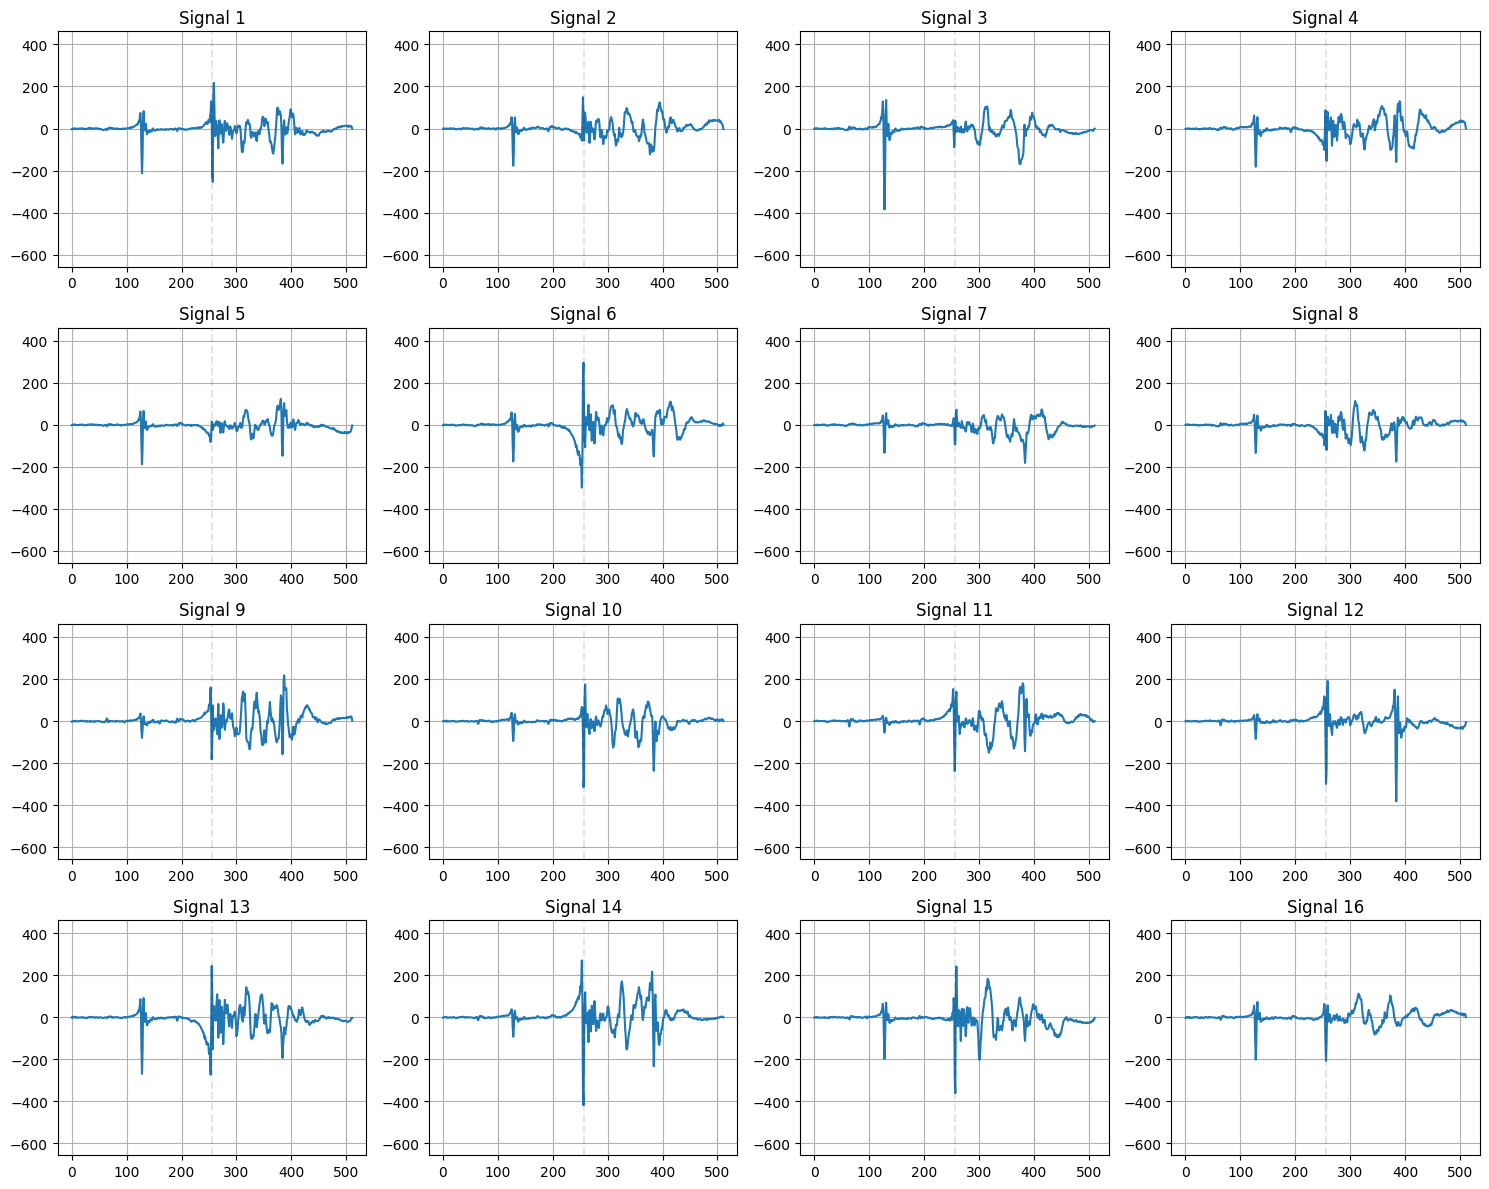

[12/32][0/188]	Loss_D: 0.6981	Loss_G: 2.0724	D(x): 0.1649	D(G(z)): 0.8033 / 0.7972
[12/32][50/188]	Loss_D: 0.7132	Loss_G: 2.0580	D(x): 0.1167	D(G(z)): 0.7375 / 0.8079
[12/32][100/188]	Loss_D: 0.6339	Loss_G: 1.7949	D(x): 0.1198	D(G(z)): 0.7804 / 0.7613
[12/32][150/188]	Loss_D: 0.6433	Loss_G: 2.3556	D(x): 0.1407	D(G(z)): 0.8375 / 0.8377
Epoch 12: SGD Discriminator lr 0.0000160 -> 0.0000157
Epoch 12: SGD Generator lr 0.0000160 -> 0.0000157


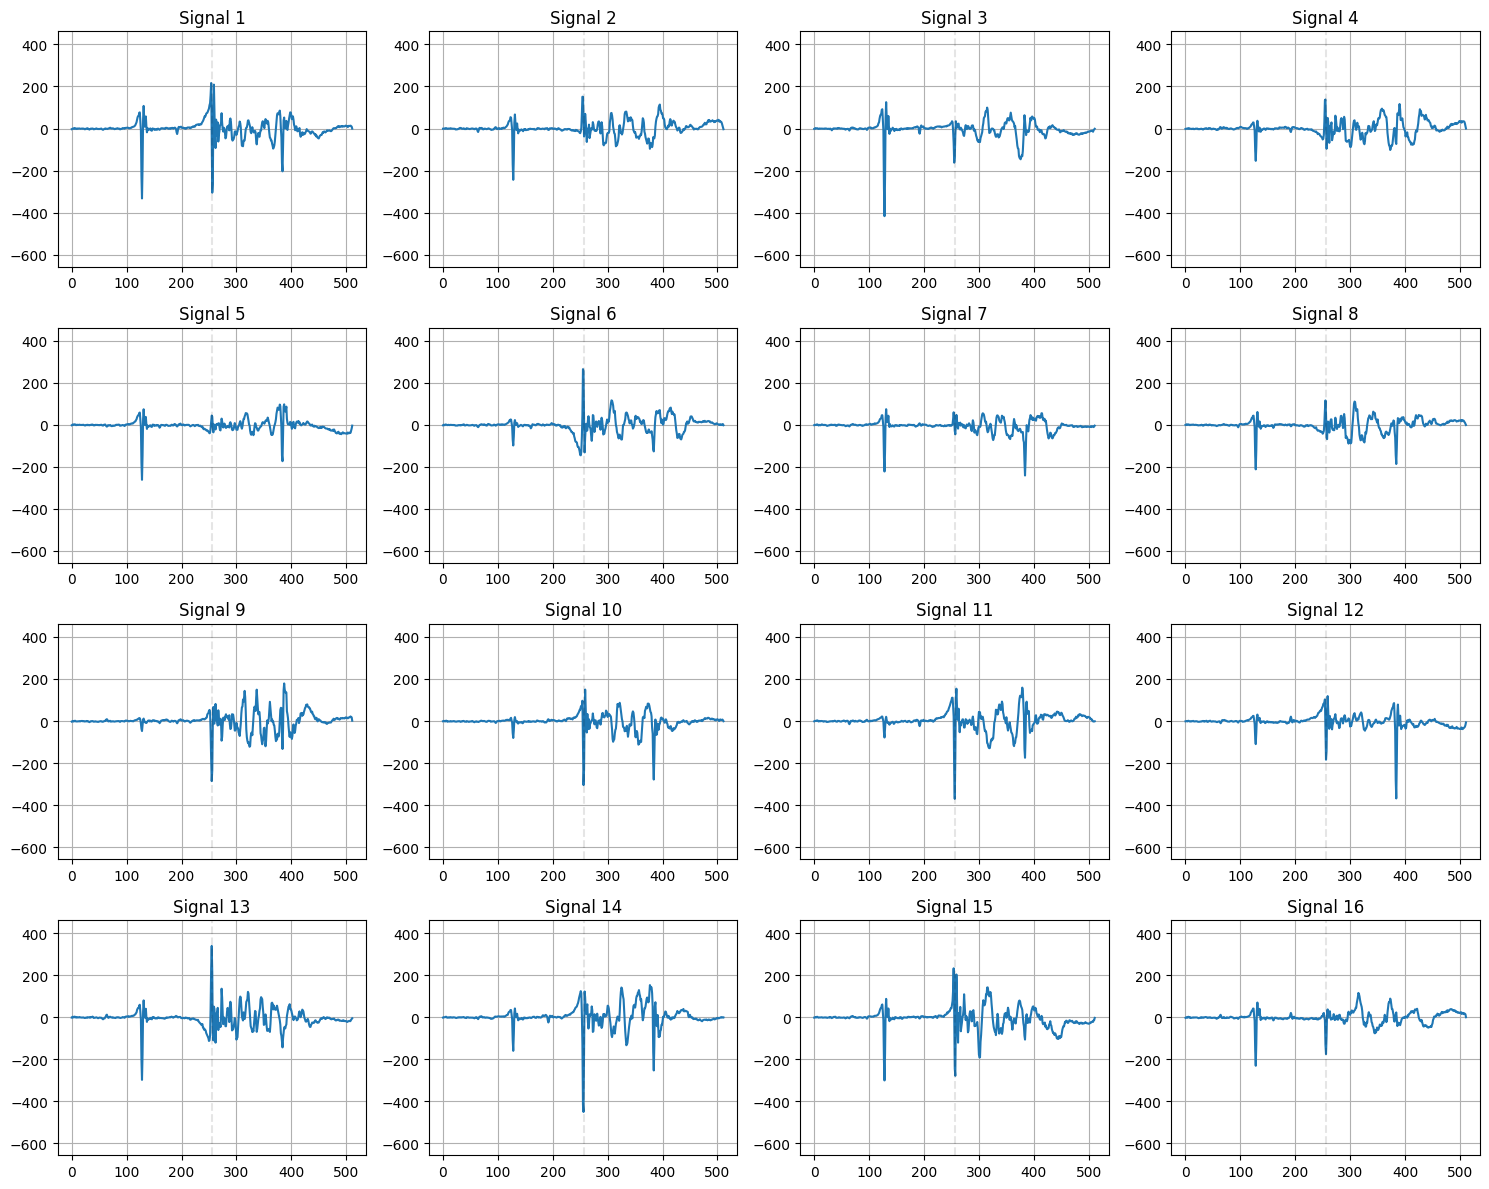

[13/32][0/188]	Loss_D: 0.5775	Loss_G: 1.8953	D(x): 0.0959	D(G(z)): 0.8068 / 0.7783
[13/32][50/188]	Loss_D: 0.7042	Loss_G: 1.8470	D(x): 0.0931	D(G(z)): 0.7154 / 0.7801
[13/32][100/188]	Loss_D: 0.6392	Loss_G: 1.3342	D(x): 0.1054	D(G(z)): 0.7158 / 0.6931
[13/32][150/188]	Loss_D: 0.5451	Loss_G: 1.5296	D(x): 0.0499	D(G(z)): 0.8347 / 0.7139
Epoch 13: SGD Discriminator lr 0.0000157 -> 0.0000153
Epoch 13: SGD Generator lr 0.0000157 -> 0.0000153


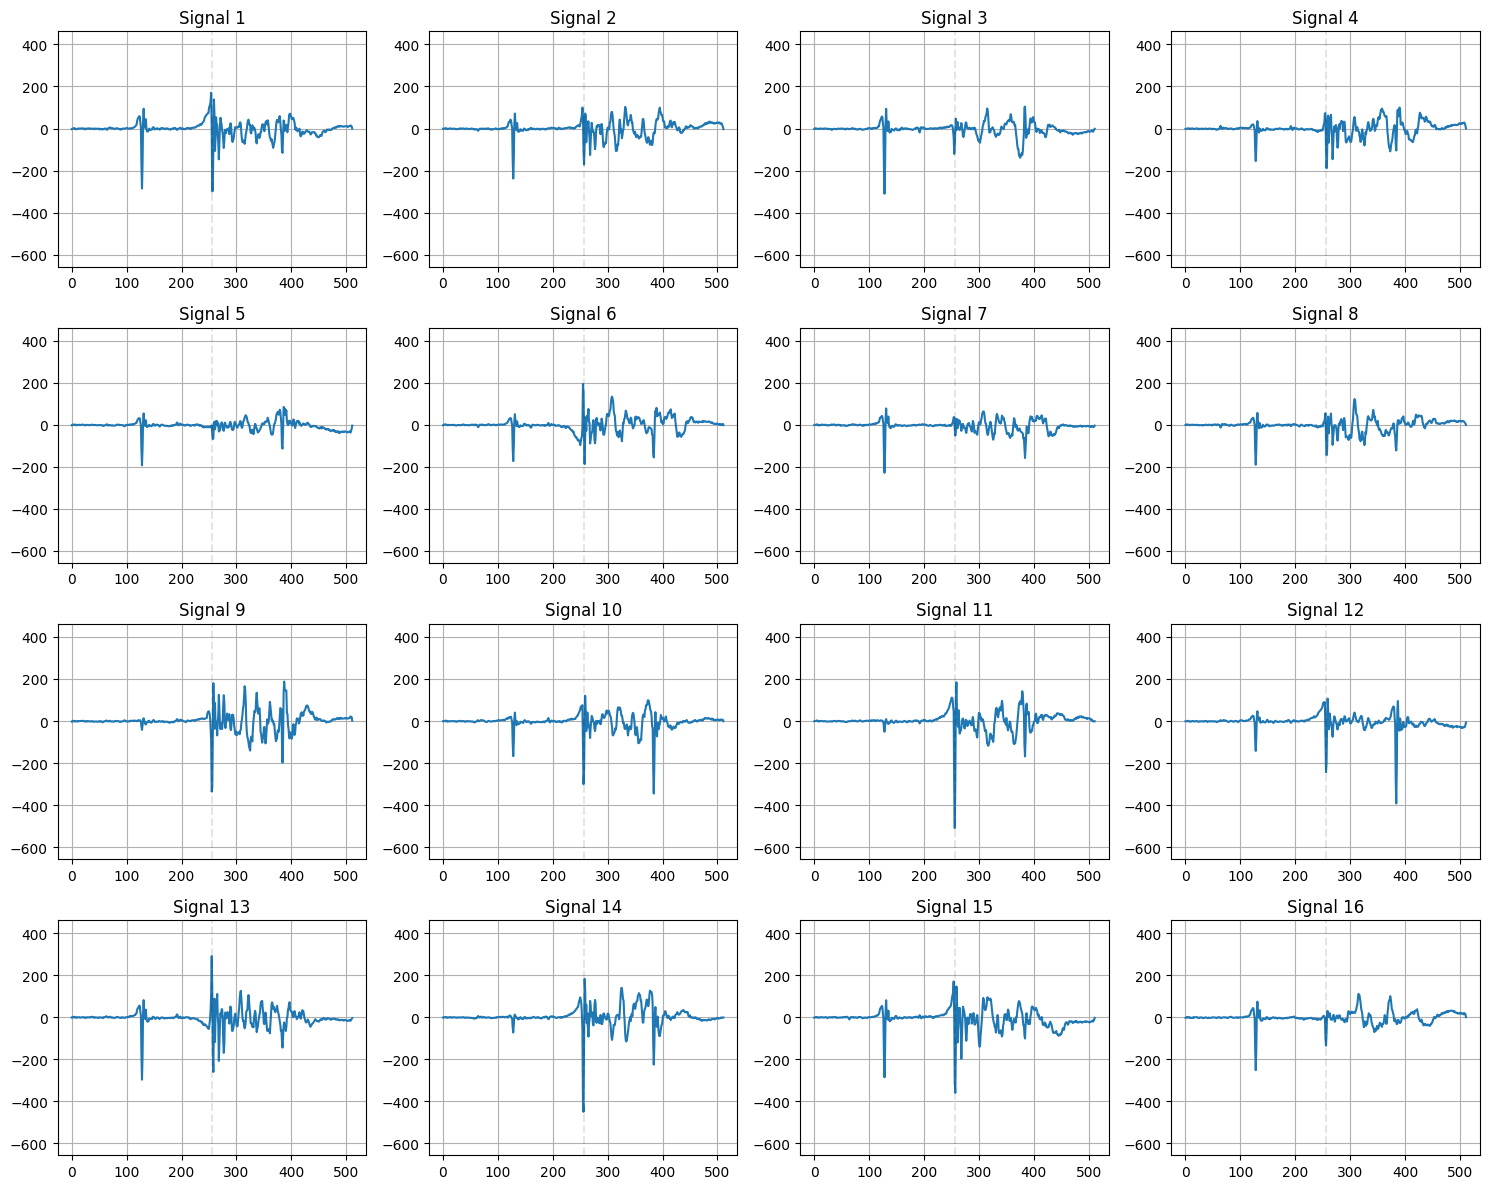

[14/32][0/188]	Loss_D: 0.7166	Loss_G: 1.7958	D(x): 0.1277	D(G(z)): 0.6808 / 0.7343
[14/32][50/188]	Loss_D: 0.6179	Loss_G: 1.5578	D(x): 0.1023	D(G(z)): 0.7322 / 0.7167
[14/32][100/188]	Loss_D: 0.5997	Loss_G: 2.0327	D(x): 0.0890	D(G(z)): 0.7782 / 0.8114
[14/32][150/188]	Loss_D: 0.5463	Loss_G: 1.6886	D(x): 0.0554	D(G(z)): 0.7688 / 0.7507
Epoch 14: SGD Discriminator lr 0.0000153 -> 0.0000150
Epoch 14: SGD Generator lr 0.0000153 -> 0.0000150


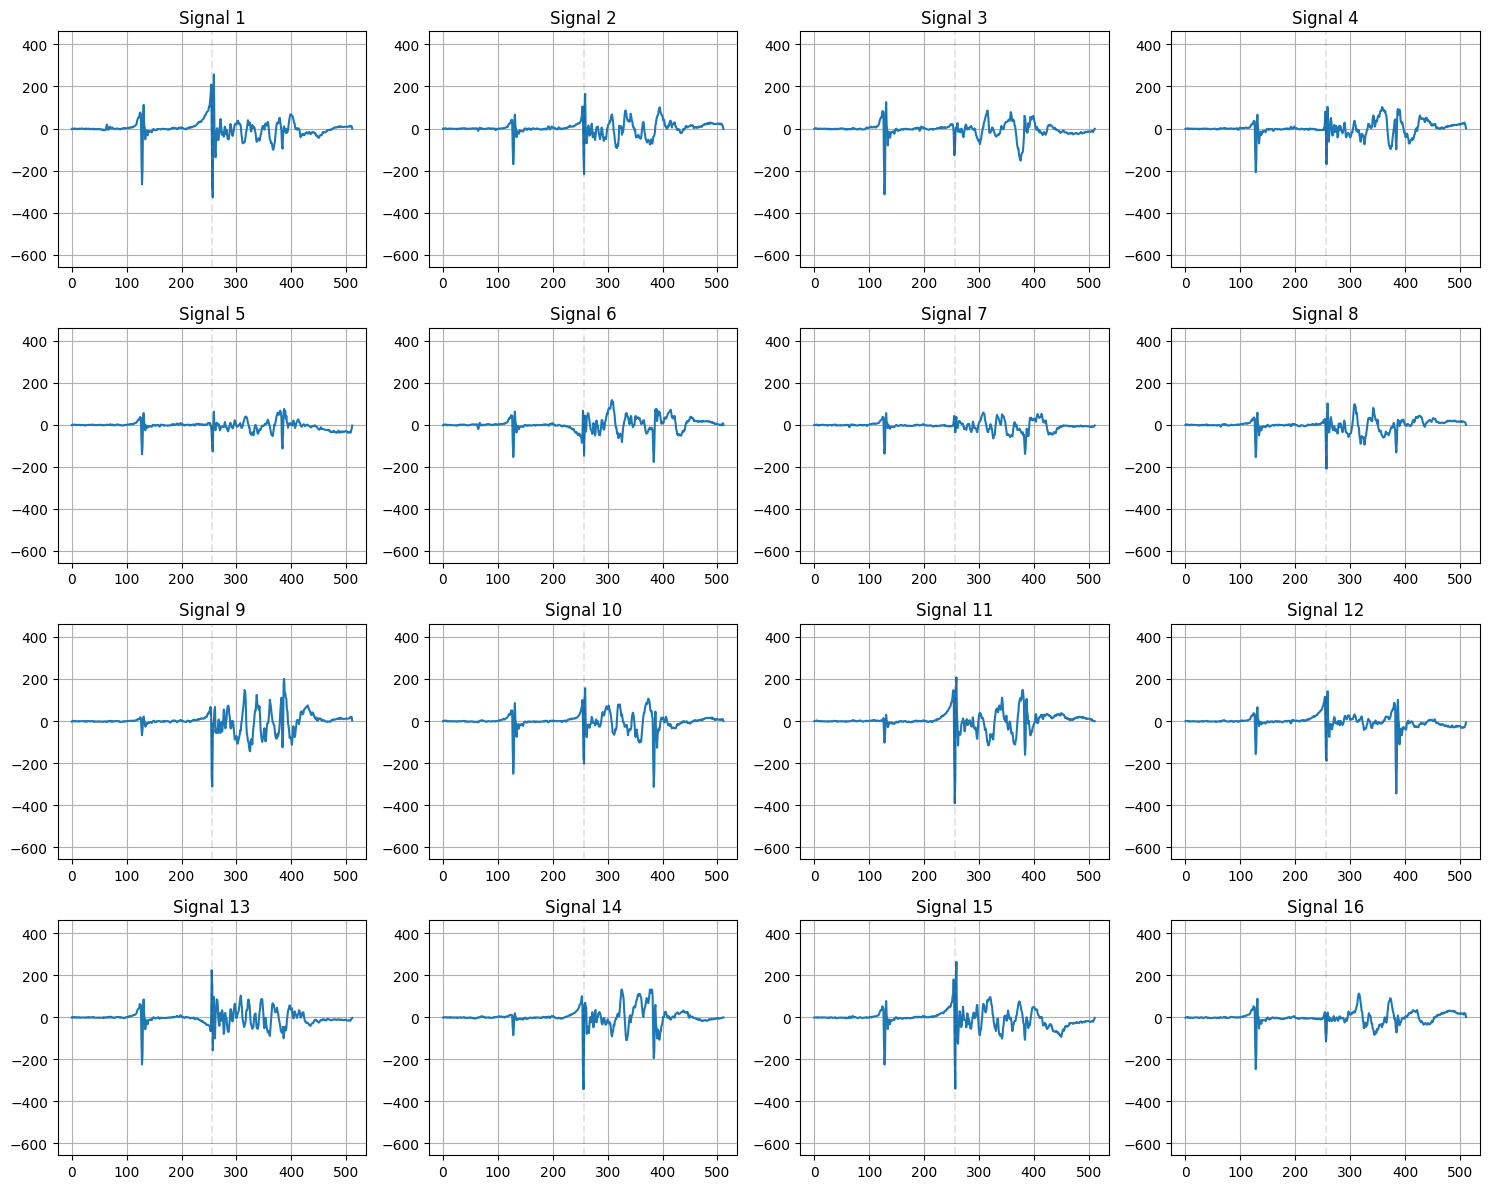

[15/32][0/188]	Loss_D: 0.6495	Loss_G: 1.4196	D(x): 0.1043	D(G(z)): 0.6847 / 0.7044
[15/32][50/188]	Loss_D: 0.5916	Loss_G: 2.1487	D(x): 0.0907	D(G(z)): 0.7682 / 0.8146
[15/32][100/188]	Loss_D: 0.8160	Loss_G: 2.3399	D(x): 0.2251	D(G(z)): 0.8043 / 0.8372
[15/32][150/188]	Loss_D: 0.6355	Loss_G: 1.9010	D(x): 0.0989	D(G(z)): 0.7865 / 0.7588
Epoch 15: SGD Discriminator lr 0.0000150 -> 0.0000147
Epoch 15: SGD Generator lr 0.0000150 -> 0.0000147


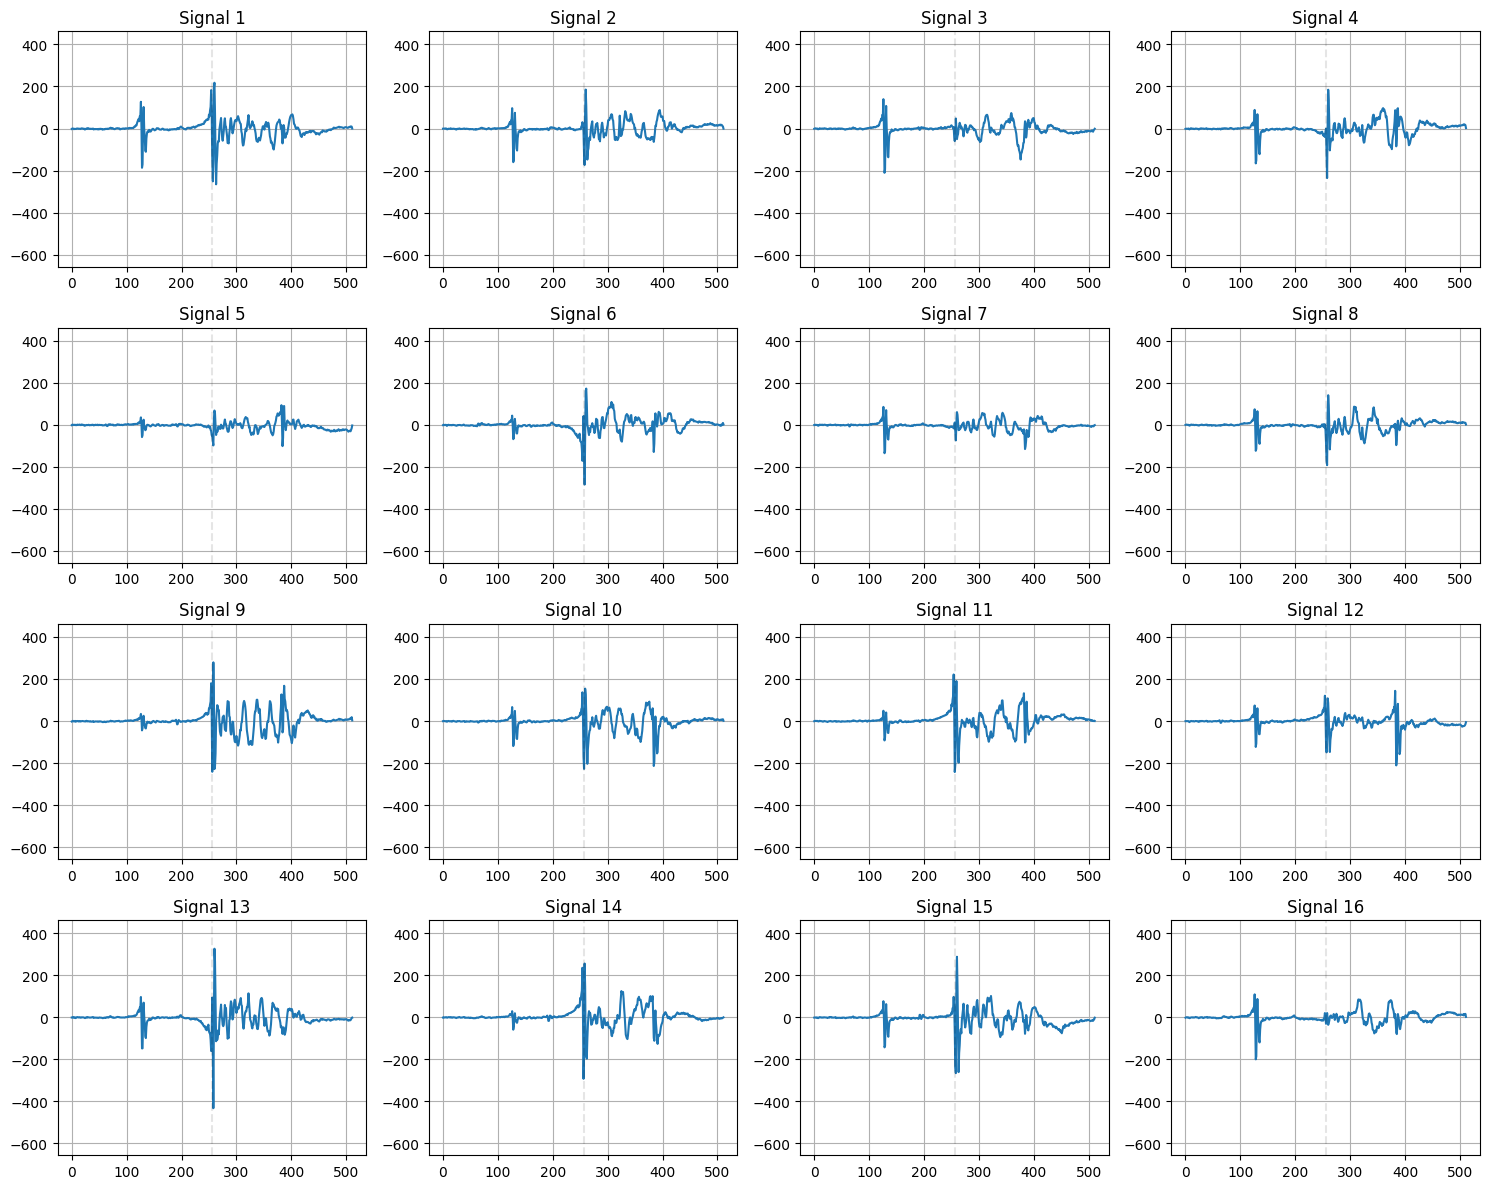

[16/32][0/188]	Loss_D: 0.7064	Loss_G: 2.1190	D(x): 0.1278	D(G(z)): 0.7560 / 0.8161
[16/32][50/188]	Loss_D: 0.7066	Loss_G: 1.5020	D(x): 0.1552	D(G(z)): 0.7985 / 0.7093
[16/32][100/188]	Loss_D: 0.6518	Loss_G: 2.0836	D(x): 0.1566	D(G(z)): 0.8205 / 0.7975
[16/32][150/188]	Loss_D: 0.6708	Loss_G: 1.8121	D(x): 0.1390	D(G(z)): 0.7586 / 0.7780
Epoch 16: SGD Discriminator lr 0.0000147 -> 0.0000143
Epoch 16: SGD Generator lr 0.0000147 -> 0.0000143


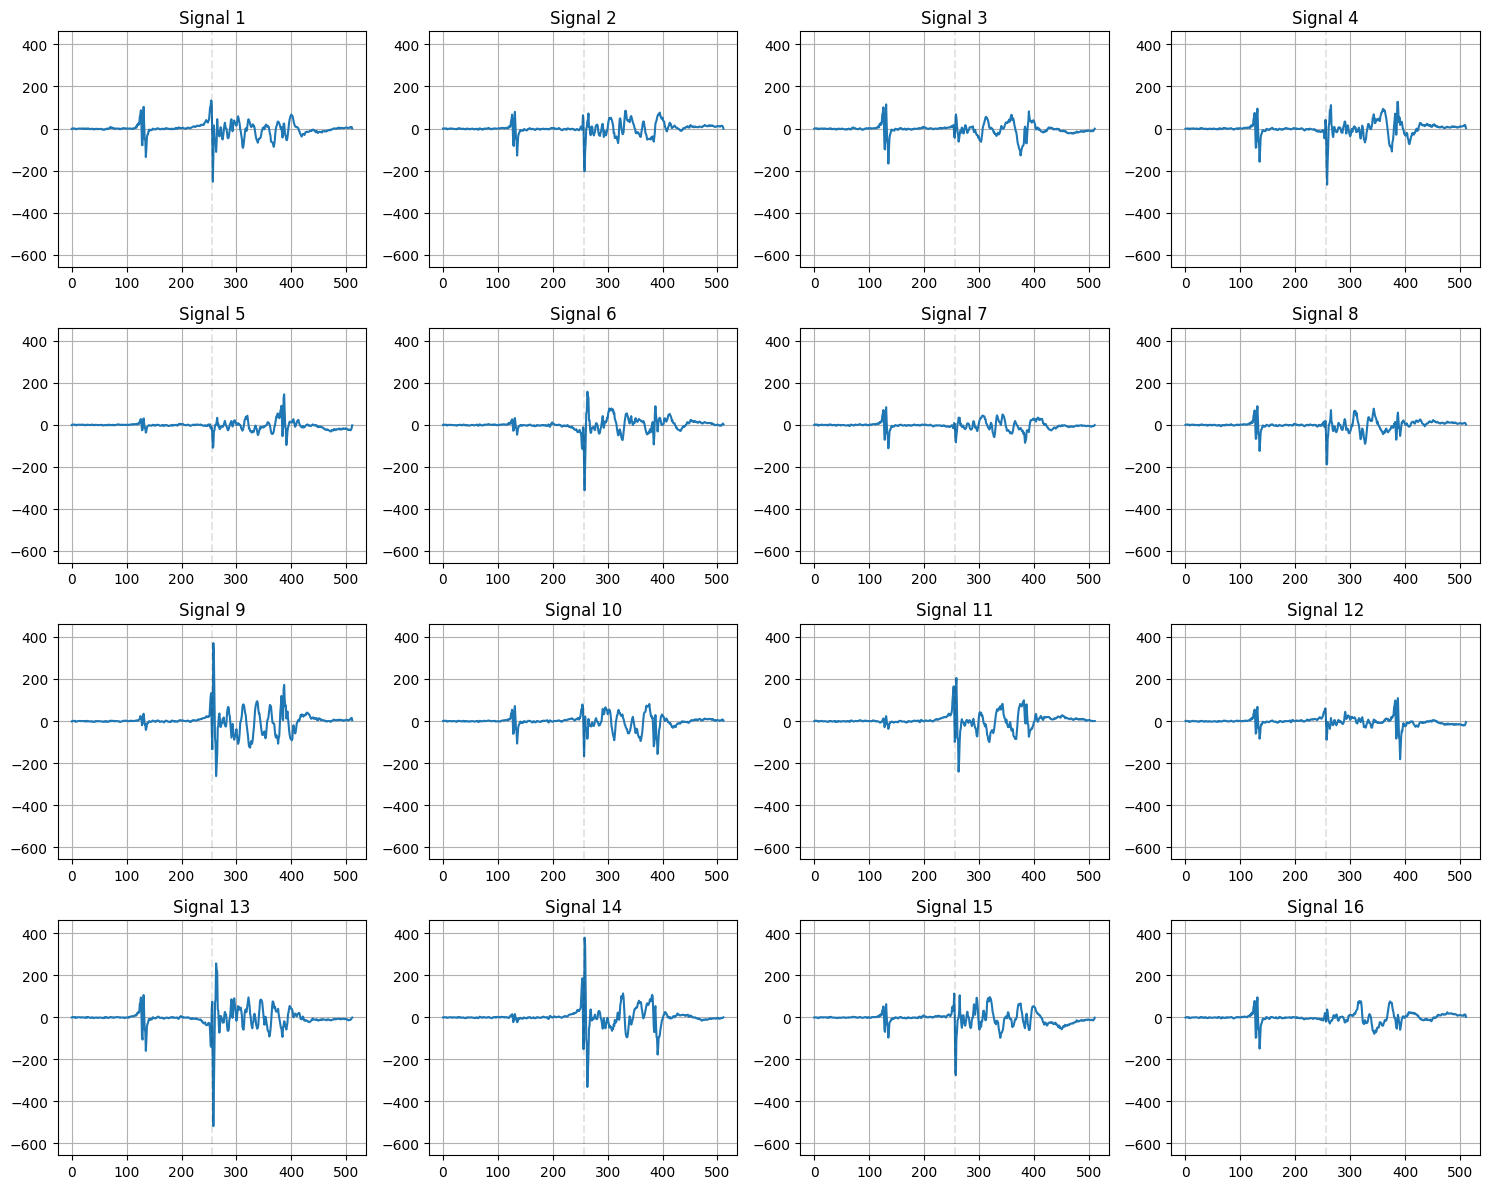

[17/32][0/188]	Loss_D: 0.5571	Loss_G: 2.0336	D(x): 0.0570	D(G(z)): 0.8115 / 0.8029
[17/32][50/188]	Loss_D: 0.5709	Loss_G: 1.8558	D(x): 0.1188	D(G(z)): 0.7756 / 0.7884
[17/32][100/188]	Loss_D: 0.6123	Loss_G: 1.7814	D(x): 0.1124	D(G(z)): 0.7390 / 0.7947
[17/32][150/188]	Loss_D: 0.5901	Loss_G: 1.5346	D(x): 0.0798	D(G(z)): 0.7647 / 0.7314
Epoch 17: SGD Discriminator lr 0.0000143 -> 0.0000140
Epoch 17: SGD Generator lr 0.0000143 -> 0.0000140


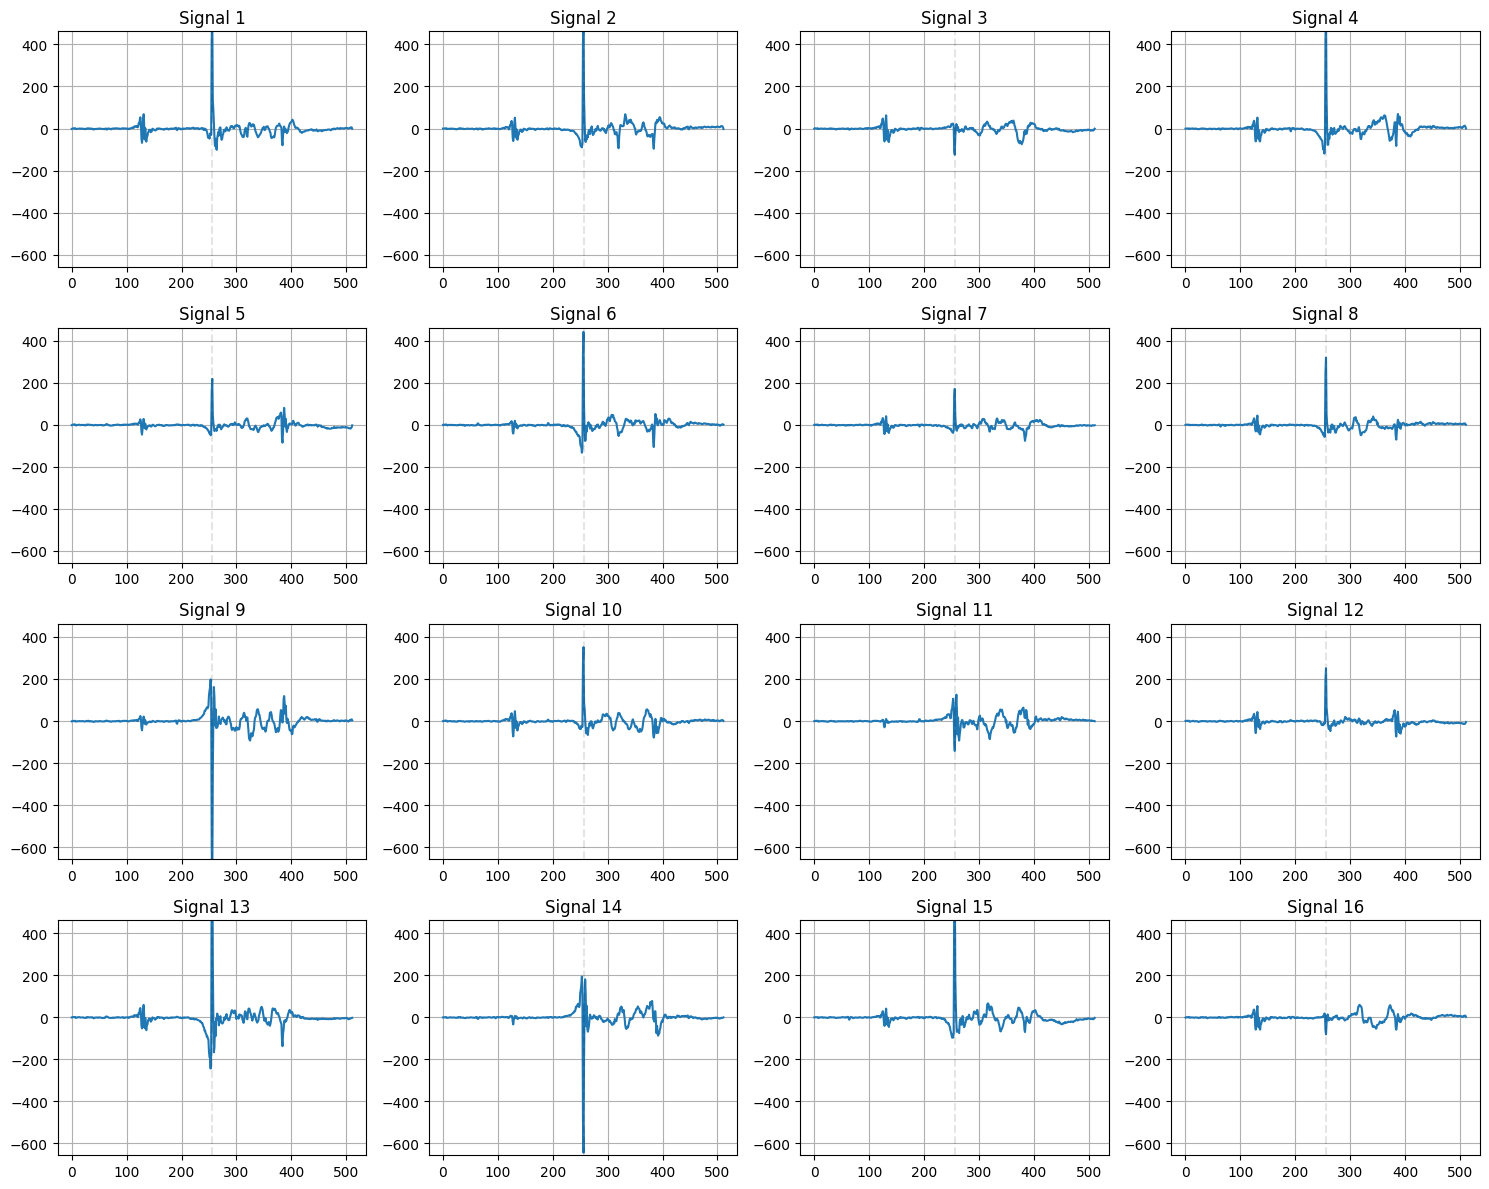

[18/32][0/188]	Loss_D: 0.5559	Loss_G: 1.5390	D(x): 0.1094	D(G(z)): 0.7637 / 0.7462
[18/32][50/188]	Loss_D: 0.5738	Loss_G: 1.7155	D(x): 0.0973	D(G(z)): 0.7934 / 0.7802
[18/32][100/188]	Loss_D: 0.5872	Loss_G: 1.2616	D(x): 0.1039	D(G(z)): 0.7565 / 0.6878
[18/32][150/188]	Loss_D: 0.6588	Loss_G: 1.7091	D(x): 0.1655	D(G(z)): 0.7667 / 0.7618
Epoch 18: SGD Discriminator lr 0.0000140 -> 0.0000137
Epoch 18: SGD Generator lr 0.0000140 -> 0.0000137


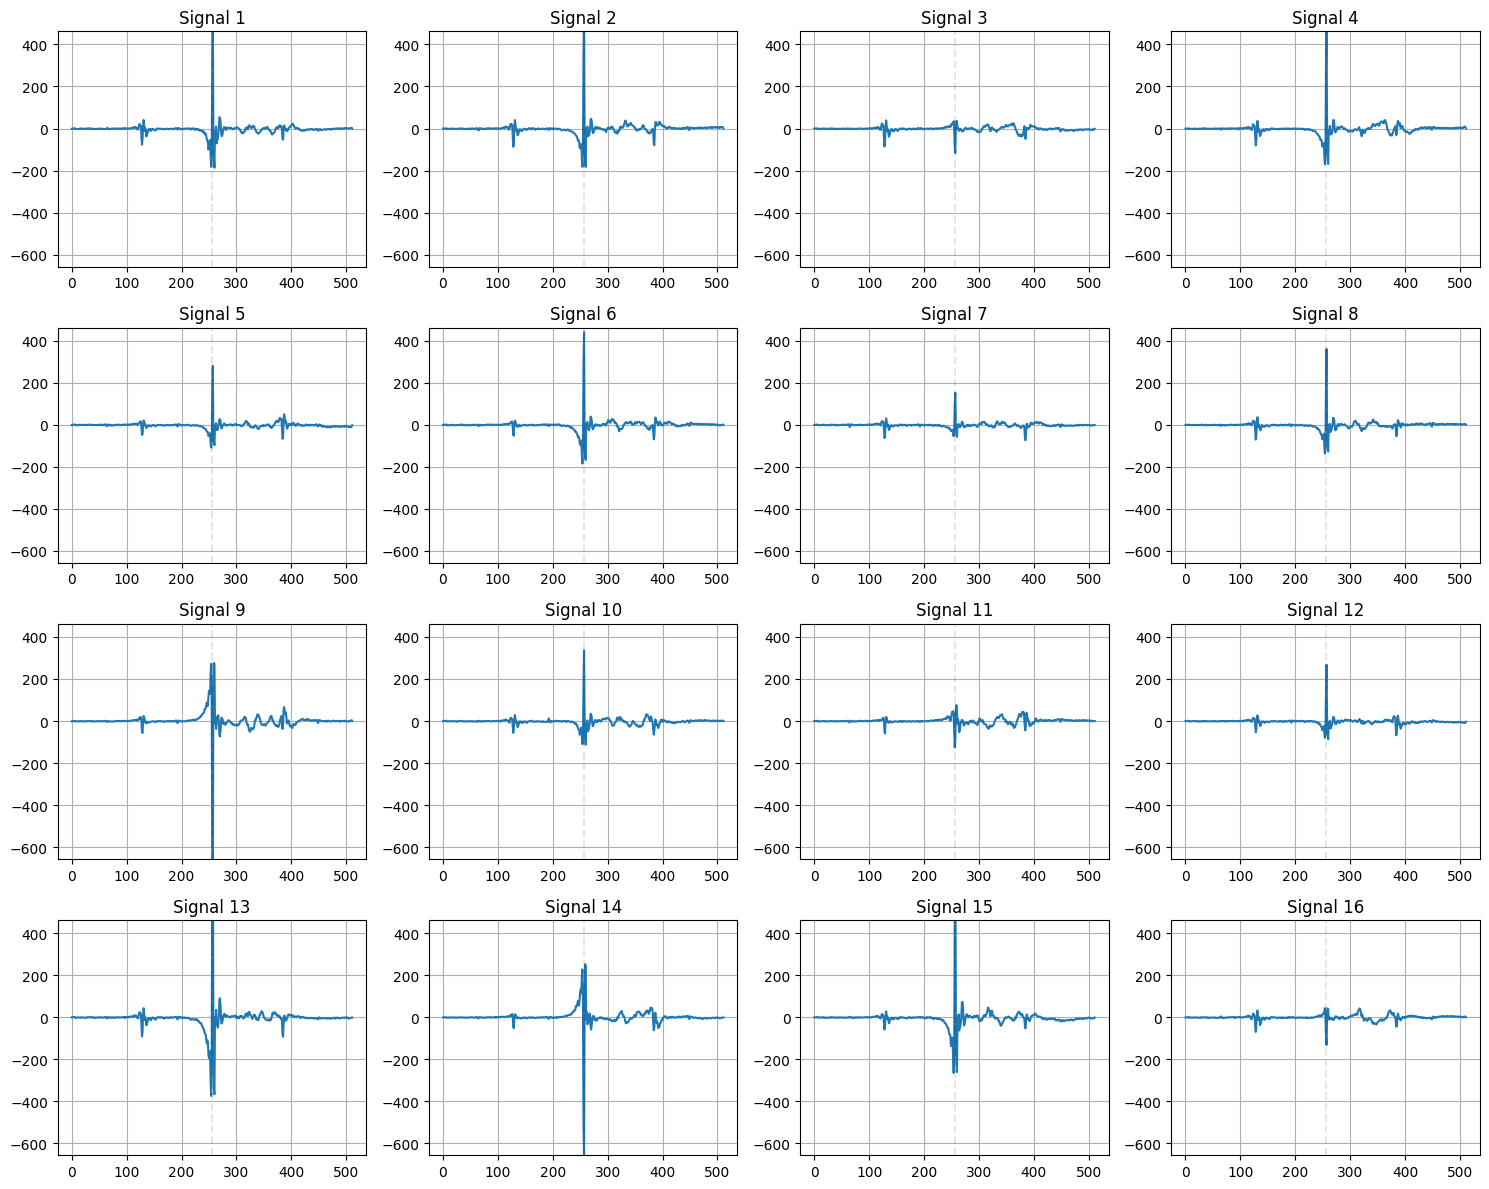

[19/32][0/188]	Loss_D: 0.6154	Loss_G: 1.5303	D(x): 0.1137	D(G(z)): 0.7425 / 0.7507
[19/32][50/188]	Loss_D: 0.5204	Loss_G: 1.9322	D(x): 0.0709	D(G(z)): 0.8138 / 0.8229
[19/32][100/188]	Loss_D: 0.7367	Loss_G: 2.0530	D(x): 0.1449	D(G(z)): 0.8492 / 0.7893
[19/32][150/188]	Loss_D: 0.5785	Loss_G: 2.1338	D(x): 0.1006	D(G(z)): 0.8673 / 0.8492
Epoch 19: SGD Discriminator lr 0.0000137 -> 0.0000133
Epoch 19: SGD Generator lr 0.0000137 -> 0.0000133


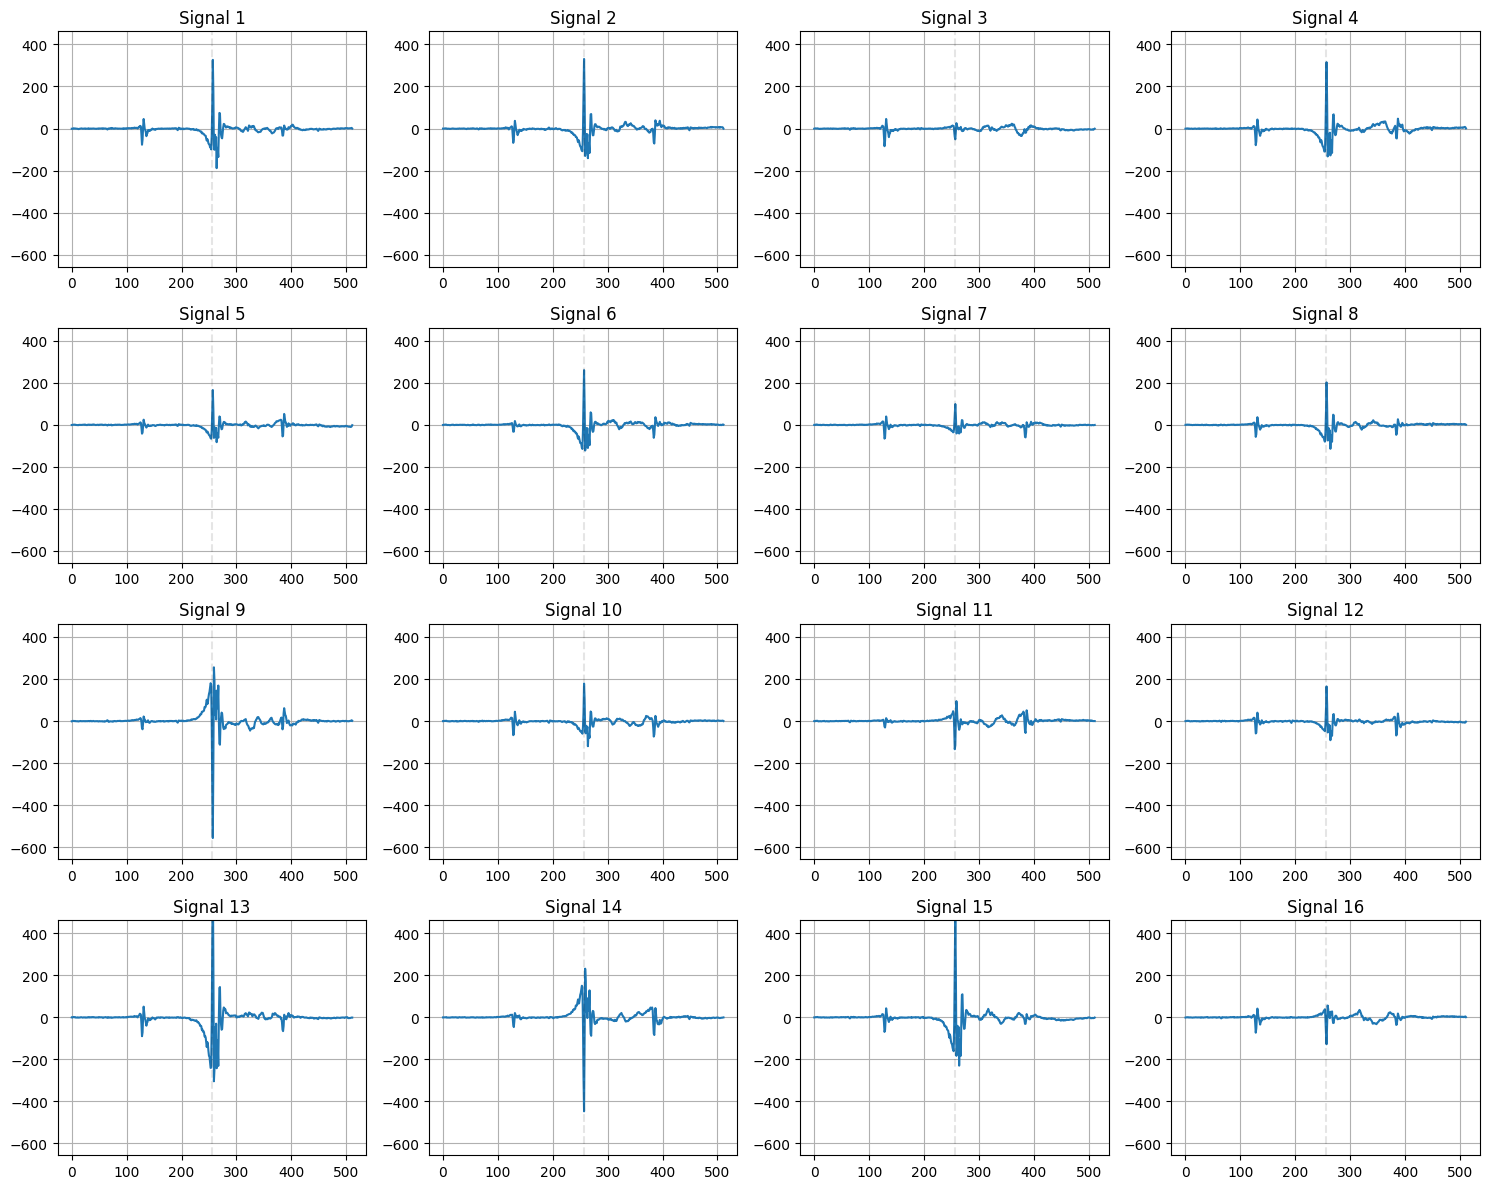

[20/32][0/188]	Loss_D: 0.6562	Loss_G: 1.7656	D(x): 0.1598	D(G(z)): 0.8170 / 0.7563
[20/32][50/188]	Loss_D: 0.6957	Loss_G: 2.3151	D(x): 0.1512	D(G(z)): 0.7971 / 0.8597
[20/32][100/188]	Loss_D: 0.6006	Loss_G: 1.9444	D(x): 0.1272	D(G(z)): 0.8149 / 0.8053
[20/32][150/188]	Loss_D: 0.6440	Loss_G: 1.8514	D(x): 0.0967	D(G(z)): 0.7308 / 0.8067
Epoch 20: SGD Discriminator lr 0.0000133 -> 0.0000130
Epoch 20: SGD Generator lr 0.0000133 -> 0.0000130


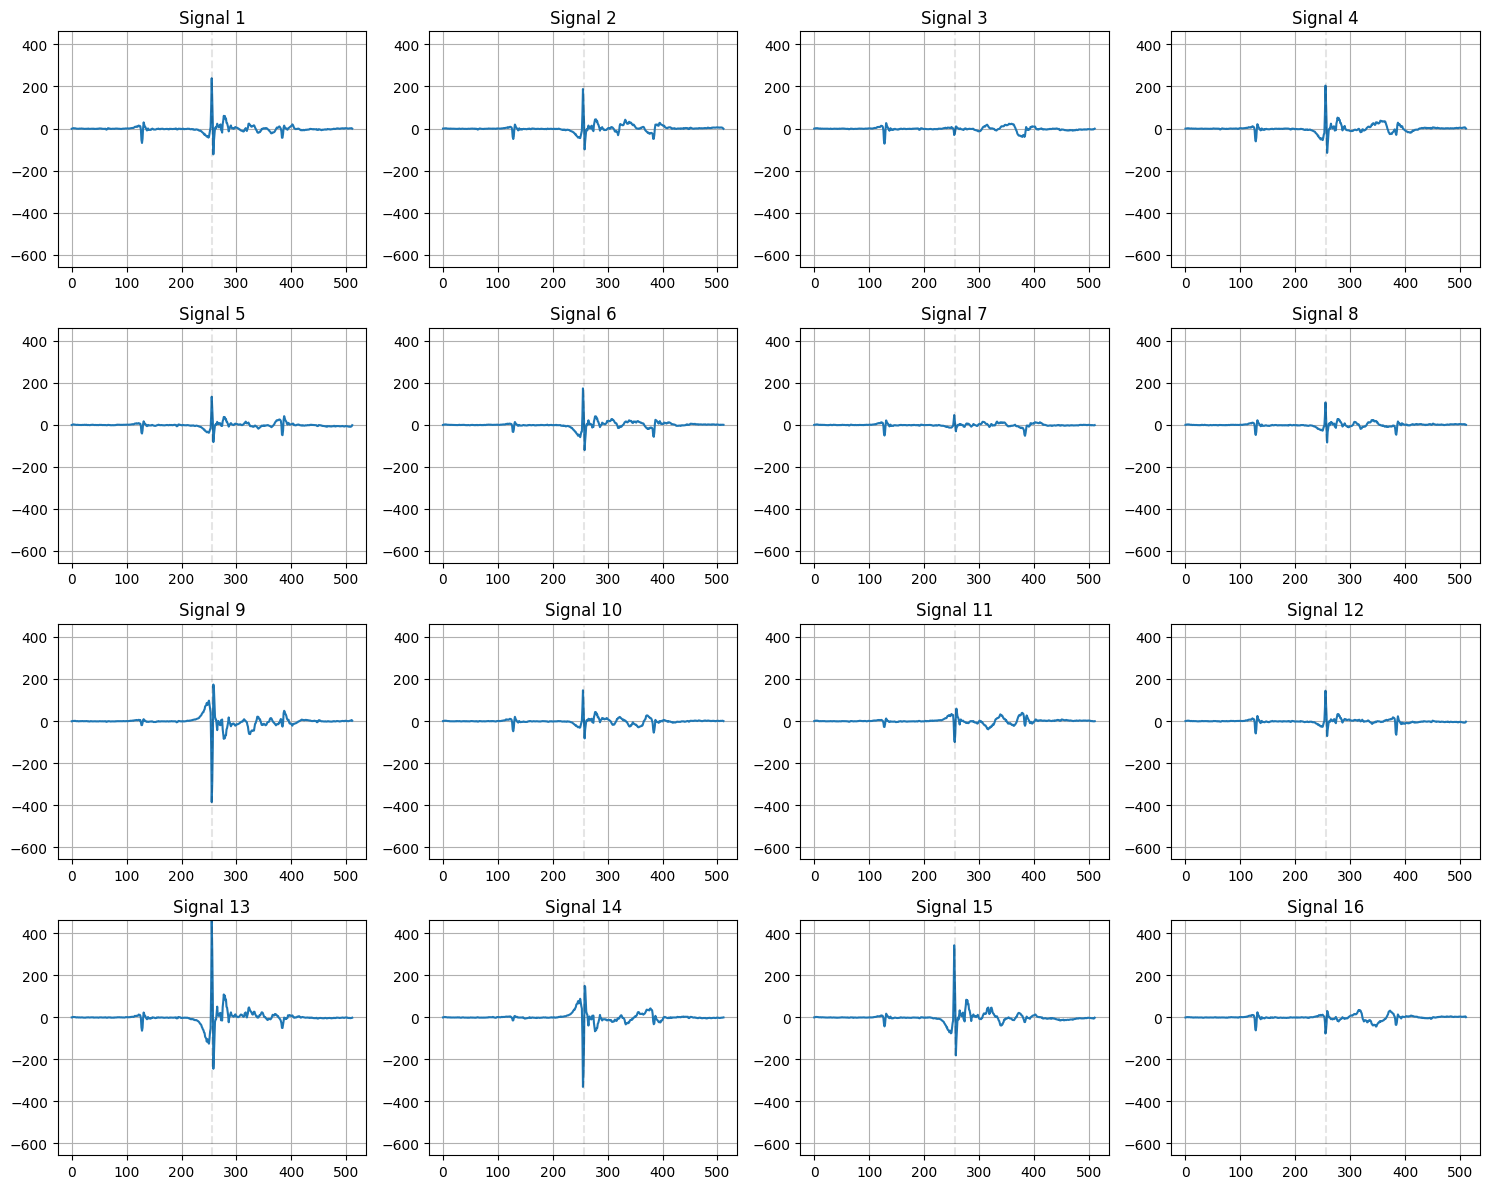

[21/32][0/188]	Loss_D: 0.5506	Loss_G: 2.3746	D(x): 0.0929	D(G(z)): 0.8367 / 0.8637
[21/32][50/188]	Loss_D: 0.5197	Loss_G: 2.2209	D(x): 0.0863	D(G(z)): 0.8343 / 0.8434
[21/32][100/188]	Loss_D: 0.5865	Loss_G: 2.3256	D(x): 0.0992	D(G(z)): 0.8032 / 0.8701
[21/32][150/188]	Loss_D: 0.6313	Loss_G: 2.3301	D(x): 0.1130	D(G(z)): 0.8085 / 0.8058
Epoch 21: SGD Discriminator lr 0.0000130 -> 0.0000127
Epoch 21: SGD Generator lr 0.0000130 -> 0.0000127


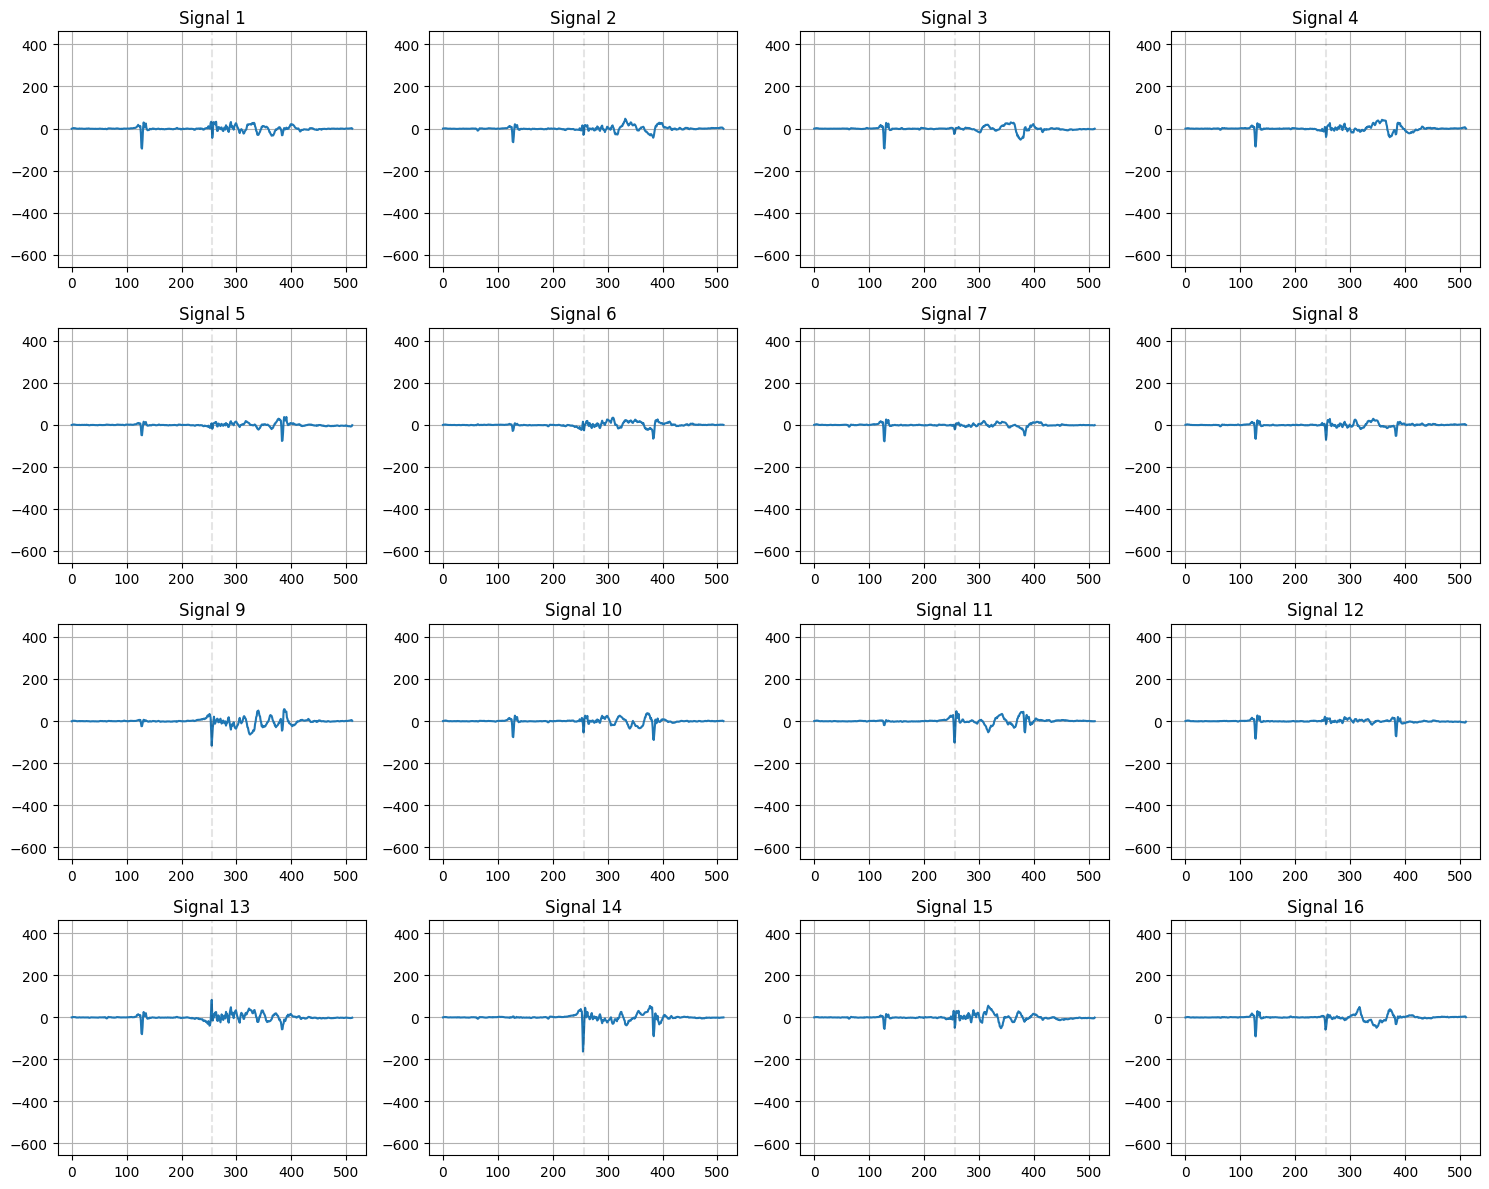

[22/32][0/188]	Loss_D: 0.7242	Loss_G: 2.7616	D(x): 0.1698	D(G(z)): 0.7592 / 0.8781
[22/32][50/188]	Loss_D: 0.6826	Loss_G: 2.1160	D(x): 0.0905	D(G(z)): 0.7603 / 0.7782
[22/32][100/188]	Loss_D: 0.7352	Loss_G: 2.1522	D(x): 0.1640	D(G(z)): 0.8101 / 0.8120
[22/32][150/188]	Loss_D: 0.5573	Loss_G: 2.0869	D(x): 0.0646	D(G(z)): 0.7453 / 0.7898
Epoch 22: SGD Discriminator lr 0.0000127 -> 0.0000123
Epoch 22: SGD Generator lr 0.0000127 -> 0.0000123


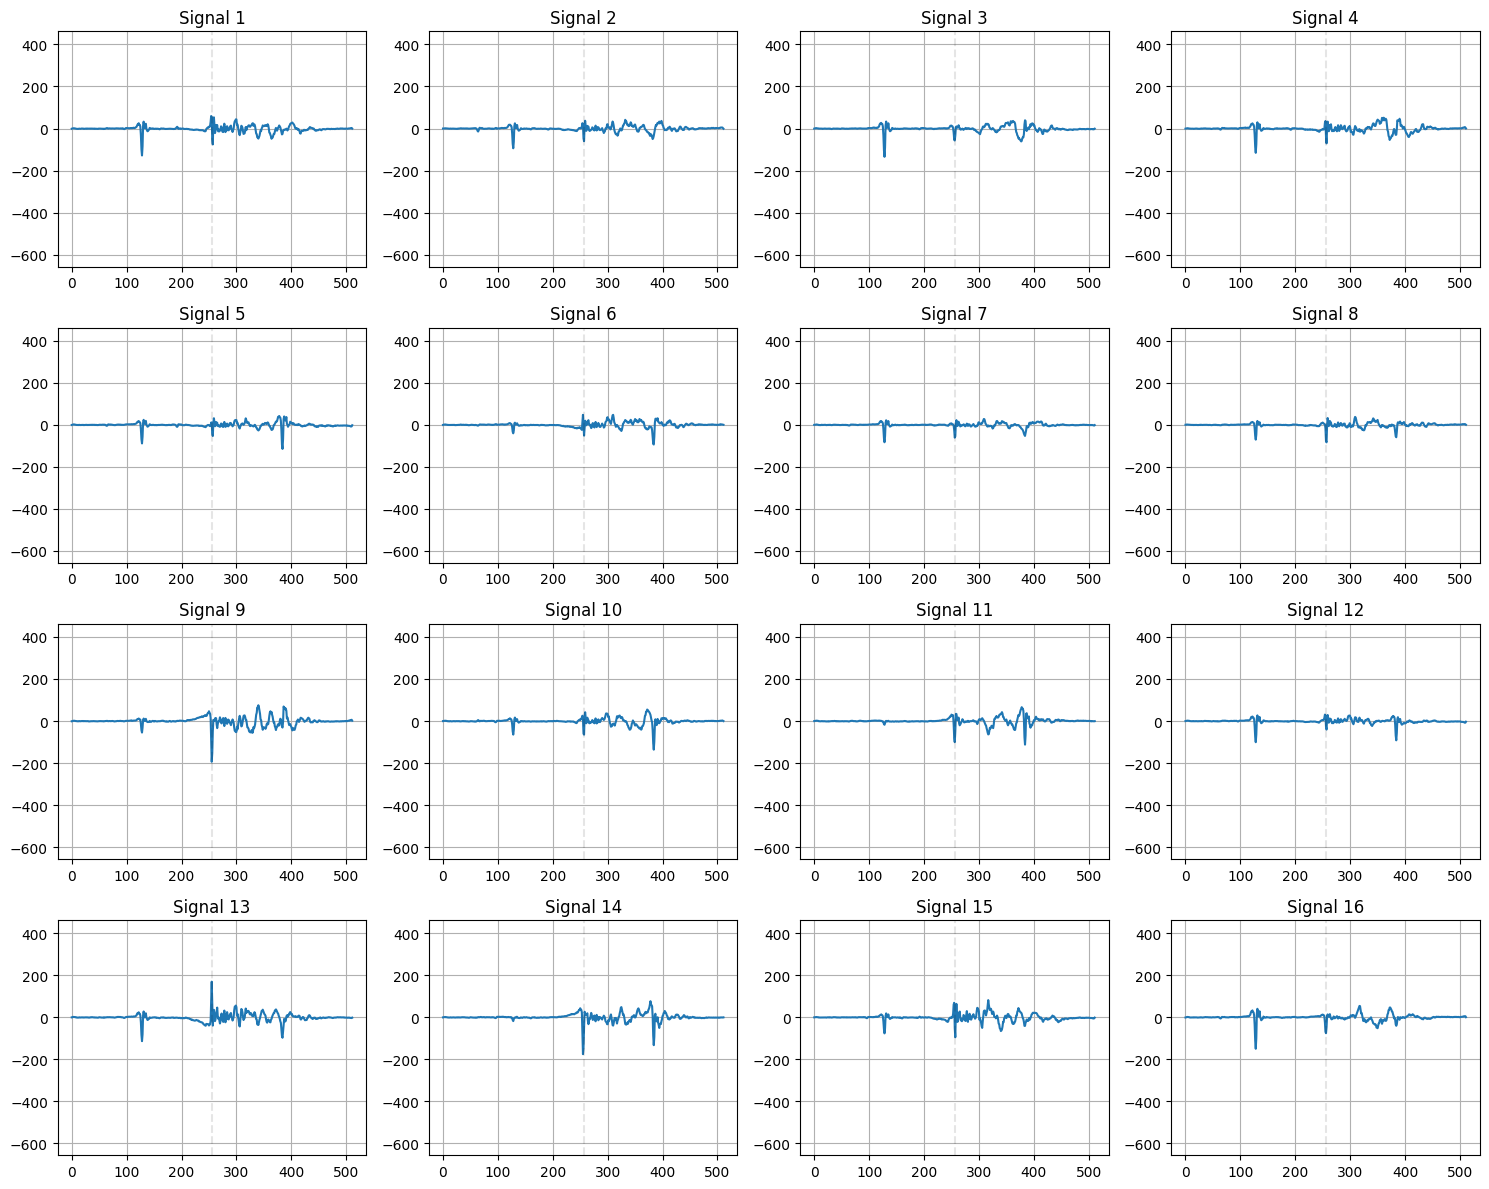

[23/32][0/188]	Loss_D: 0.5763	Loss_G: 2.1427	D(x): 0.0882	D(G(z)): 0.8172 / 0.8174
[23/32][50/188]	Loss_D: 0.5672	Loss_G: 2.0381	D(x): 0.1195	D(G(z)): 0.8481 / 0.8165
[23/32][100/188]	Loss_D: 0.5563	Loss_G: 2.1716	D(x): 0.0648	D(G(z)): 0.8153 / 0.8176
[23/32][150/188]	Loss_D: 0.6121	Loss_G: 2.0331	D(x): 0.0807	D(G(z)): 0.7704 / 0.7925
Epoch 23: SGD Discriminator lr 0.0000123 -> 0.0000120
Epoch 23: SGD Generator lr 0.0000123 -> 0.0000120


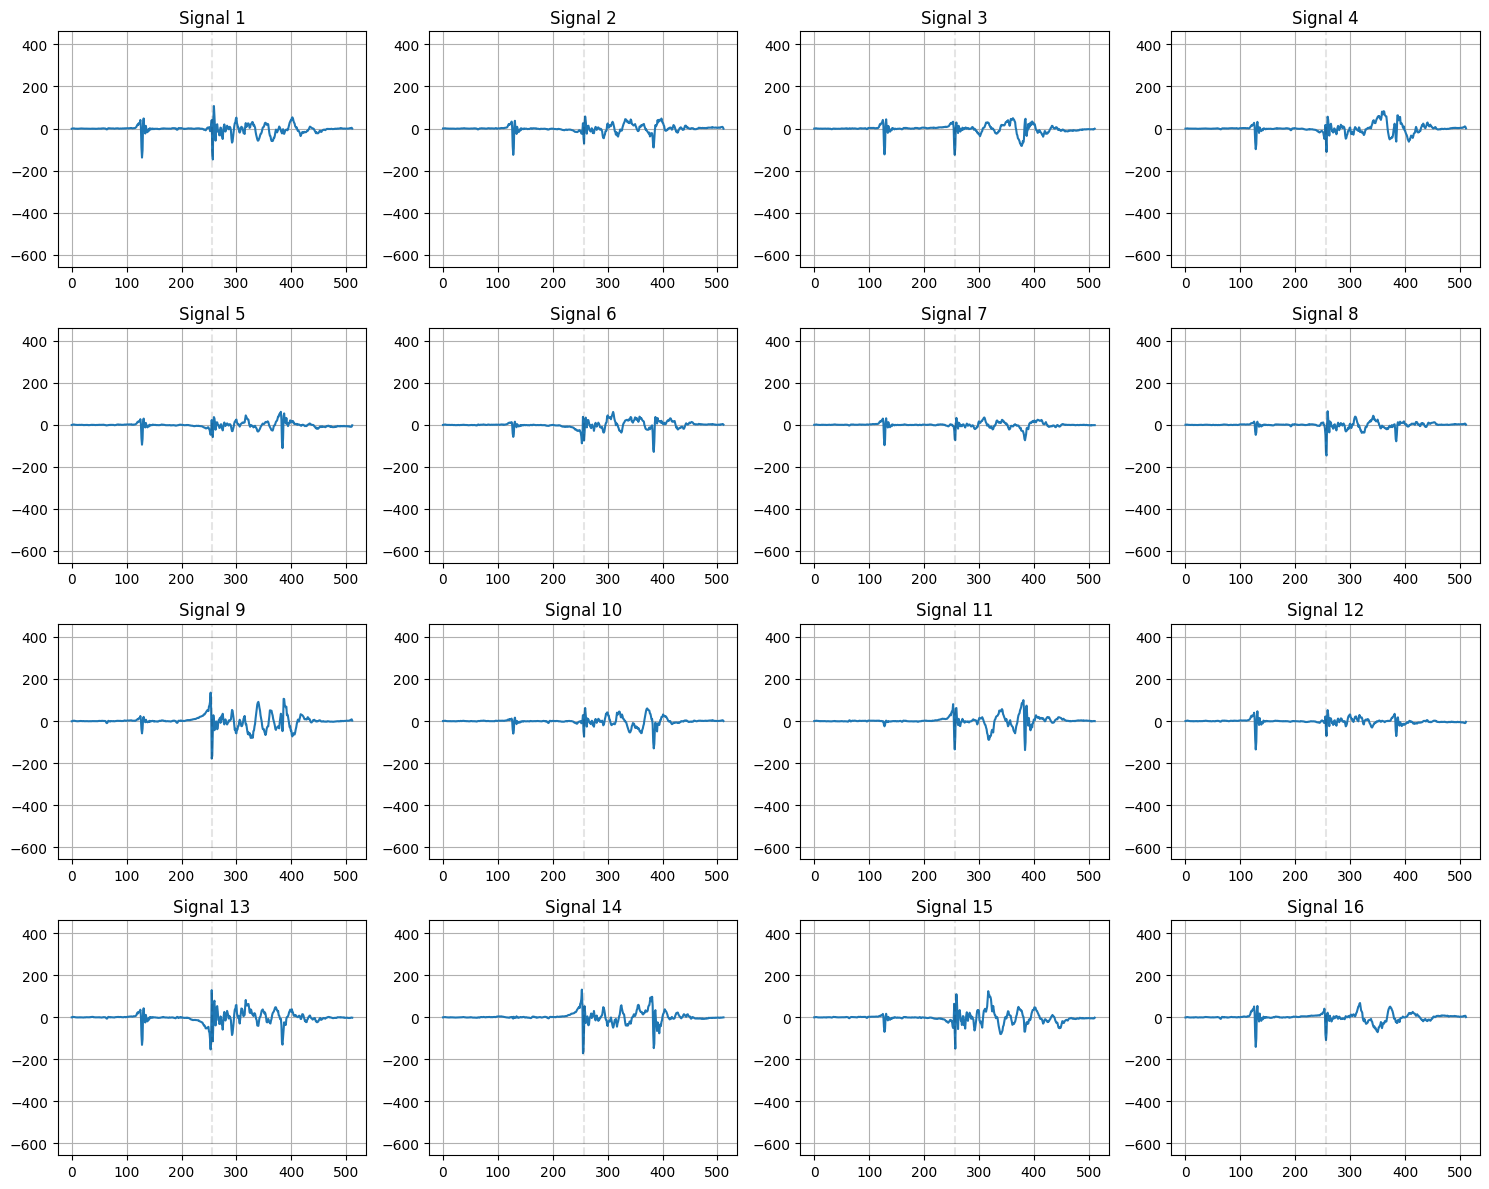

[24/32][0/188]	Loss_D: 0.6837	Loss_G: 1.8247	D(x): 0.1294	D(G(z)): 0.8284 / 0.7466
[24/32][50/188]	Loss_D: 0.5927	Loss_G: 1.9566	D(x): 0.0755	D(G(z)): 0.7201 / 0.7877
[24/32][100/188]	Loss_D: 0.6094	Loss_G: 1.8523	D(x): 0.0858	D(G(z)): 0.7835 / 0.7518
[24/32][150/188]	Loss_D: 0.7504	Loss_G: 2.0467	D(x): 0.1656	D(G(z)): 0.7984 / 0.8002
Epoch 24: SGD Discriminator lr 0.0000120 -> 0.0000117
Epoch 24: SGD Generator lr 0.0000120 -> 0.0000117


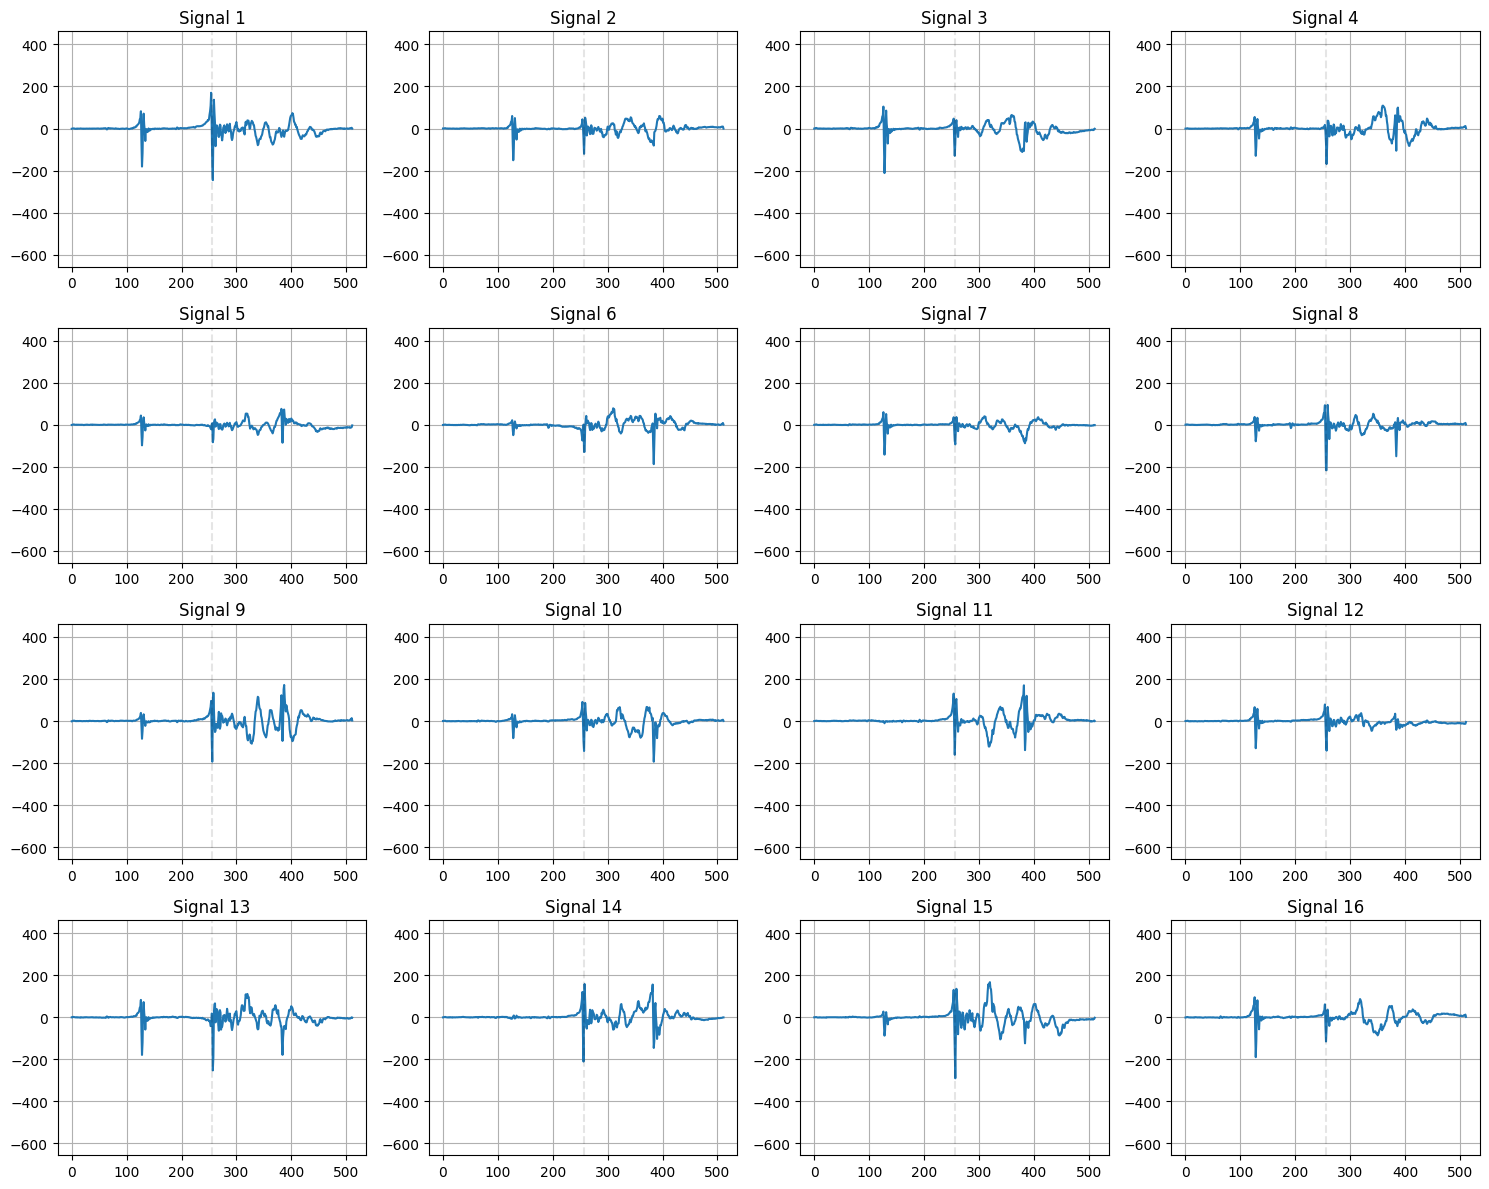

[25/32][0/188]	Loss_D: 0.6851	Loss_G: 1.8071	D(x): 0.1519	D(G(z)): 0.7793 / 0.7250
[25/32][50/188]	Loss_D: 0.6948	Loss_G: 1.9350	D(x): 0.1529	D(G(z)): 0.7709 / 0.7772
[25/32][100/188]	Loss_D: 0.6238	Loss_G: 2.3549	D(x): 0.1002	D(G(z)): 0.8028 / 0.8377
[25/32][150/188]	Loss_D: 0.5904	Loss_G: 1.7413	D(x): 0.1189	D(G(z)): 0.7977 / 0.7516
Epoch 25: SGD Discriminator lr 0.0000117 -> 0.0000113
Epoch 25: SGD Generator lr 0.0000117 -> 0.0000113


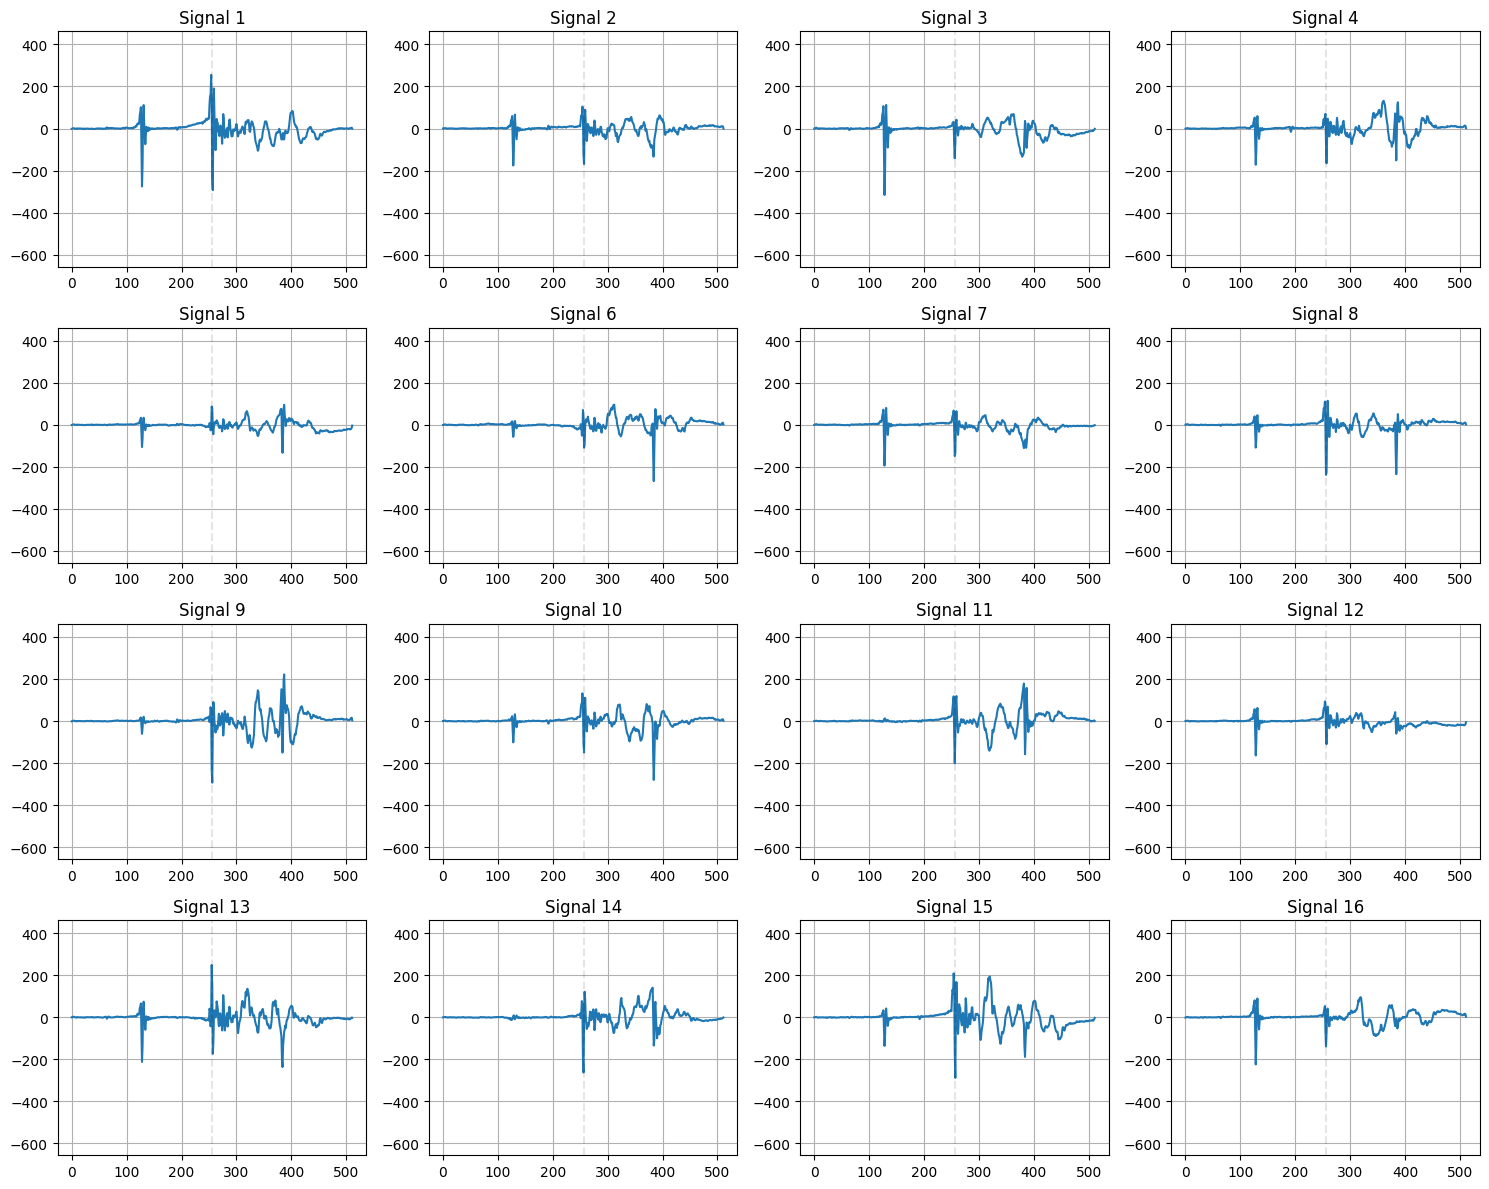

[26/32][0/188]	Loss_D: 0.5517	Loss_G: 1.7828	D(x): 0.0723	D(G(z)): 0.8124 / 0.7733
[26/32][50/188]	Loss_D: 0.6179	Loss_G: 2.1546	D(x): 0.0927	D(G(z)): 0.8558 / 0.8280
[26/32][100/188]	Loss_D: 0.6664	Loss_G: 1.5064	D(x): 0.1318	D(G(z)): 0.6882 / 0.7424
[26/32][150/188]	Loss_D: 0.6190	Loss_G: 1.7484	D(x): 0.1218	D(G(z)): 0.7576 / 0.7495
Epoch 26: SGD Discriminator lr 0.0000113 -> 0.0000110
Epoch 26: SGD Generator lr 0.0000113 -> 0.0000110


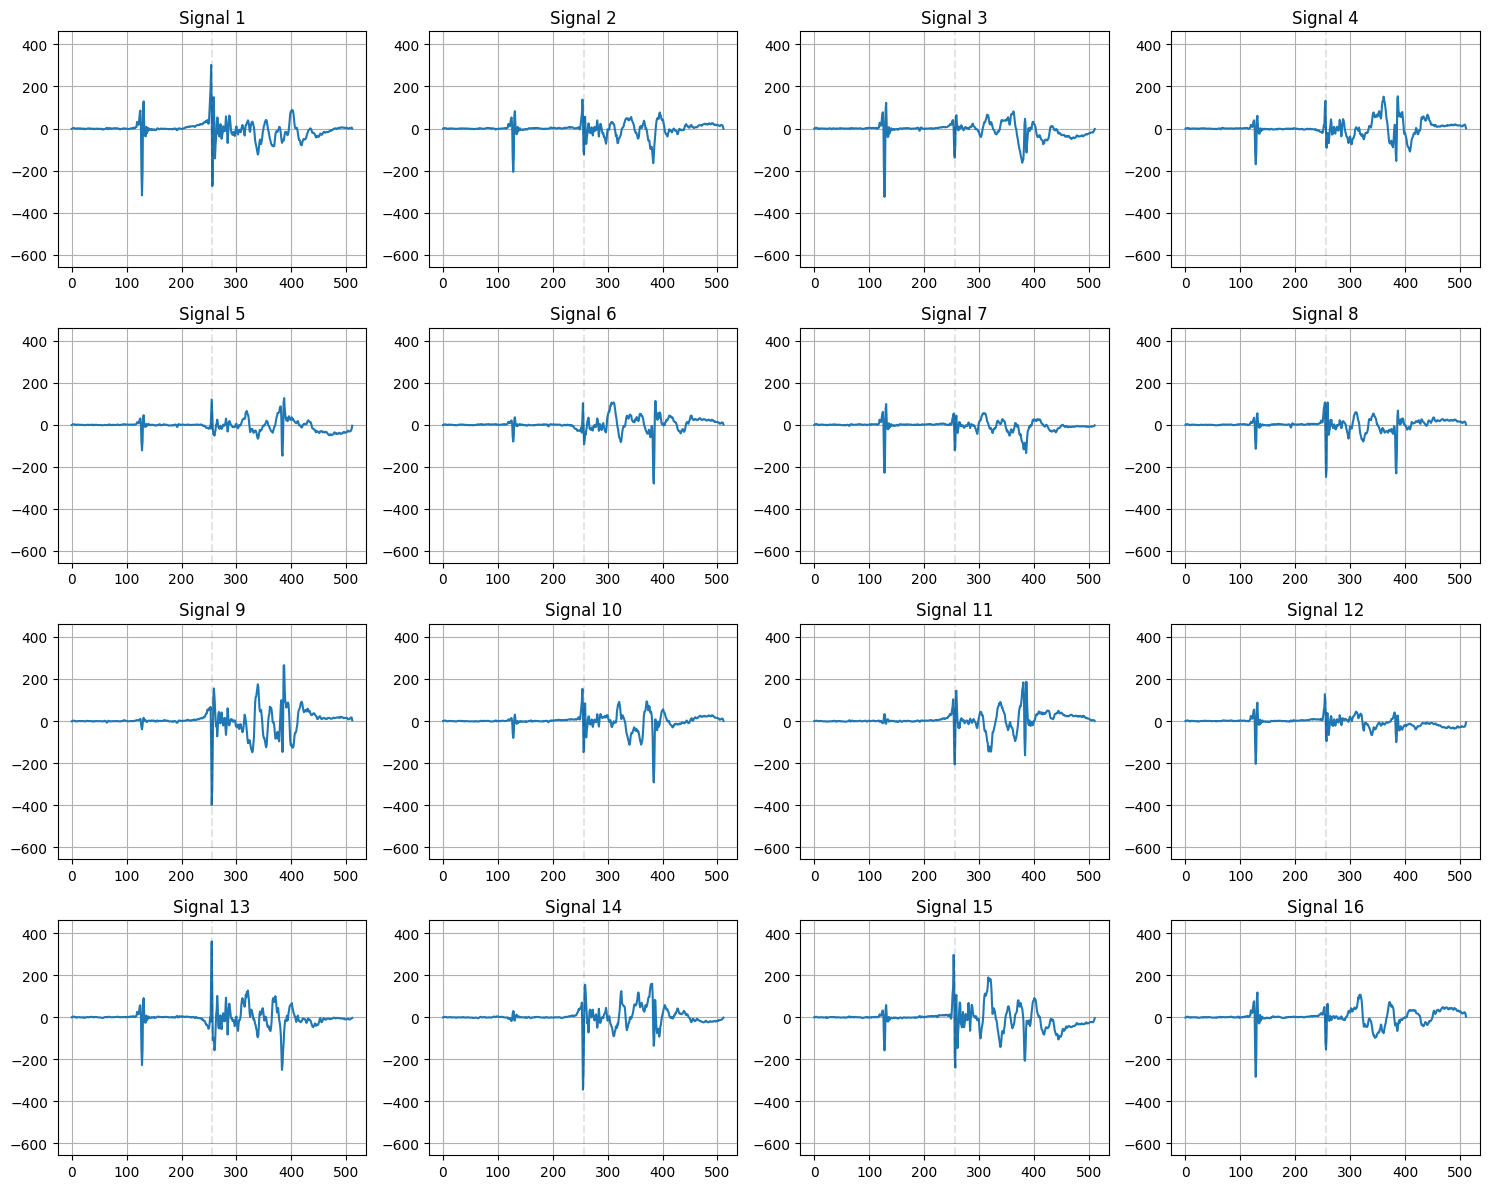

[27/32][0/188]	Loss_D: 0.5212	Loss_G: 2.1288	D(x): 0.0760	D(G(z)): 0.8022 / 0.8389
[27/32][50/188]	Loss_D: 0.4890	Loss_G: 2.3716	D(x): 0.1078	D(G(z)): 0.8765 / 0.8507
[27/32][100/188]	Loss_D: 0.6240	Loss_G: 2.3734	D(x): 0.1366	D(G(z)): 0.8197 / 0.8581
[27/32][150/188]	Loss_D: 0.6346	Loss_G: 1.8367	D(x): 0.1529	D(G(z)): 0.8286 / 0.7762
Epoch 27: SGD Discriminator lr 0.0000110 -> 0.0000107
Epoch 27: SGD Generator lr 0.0000110 -> 0.0000107


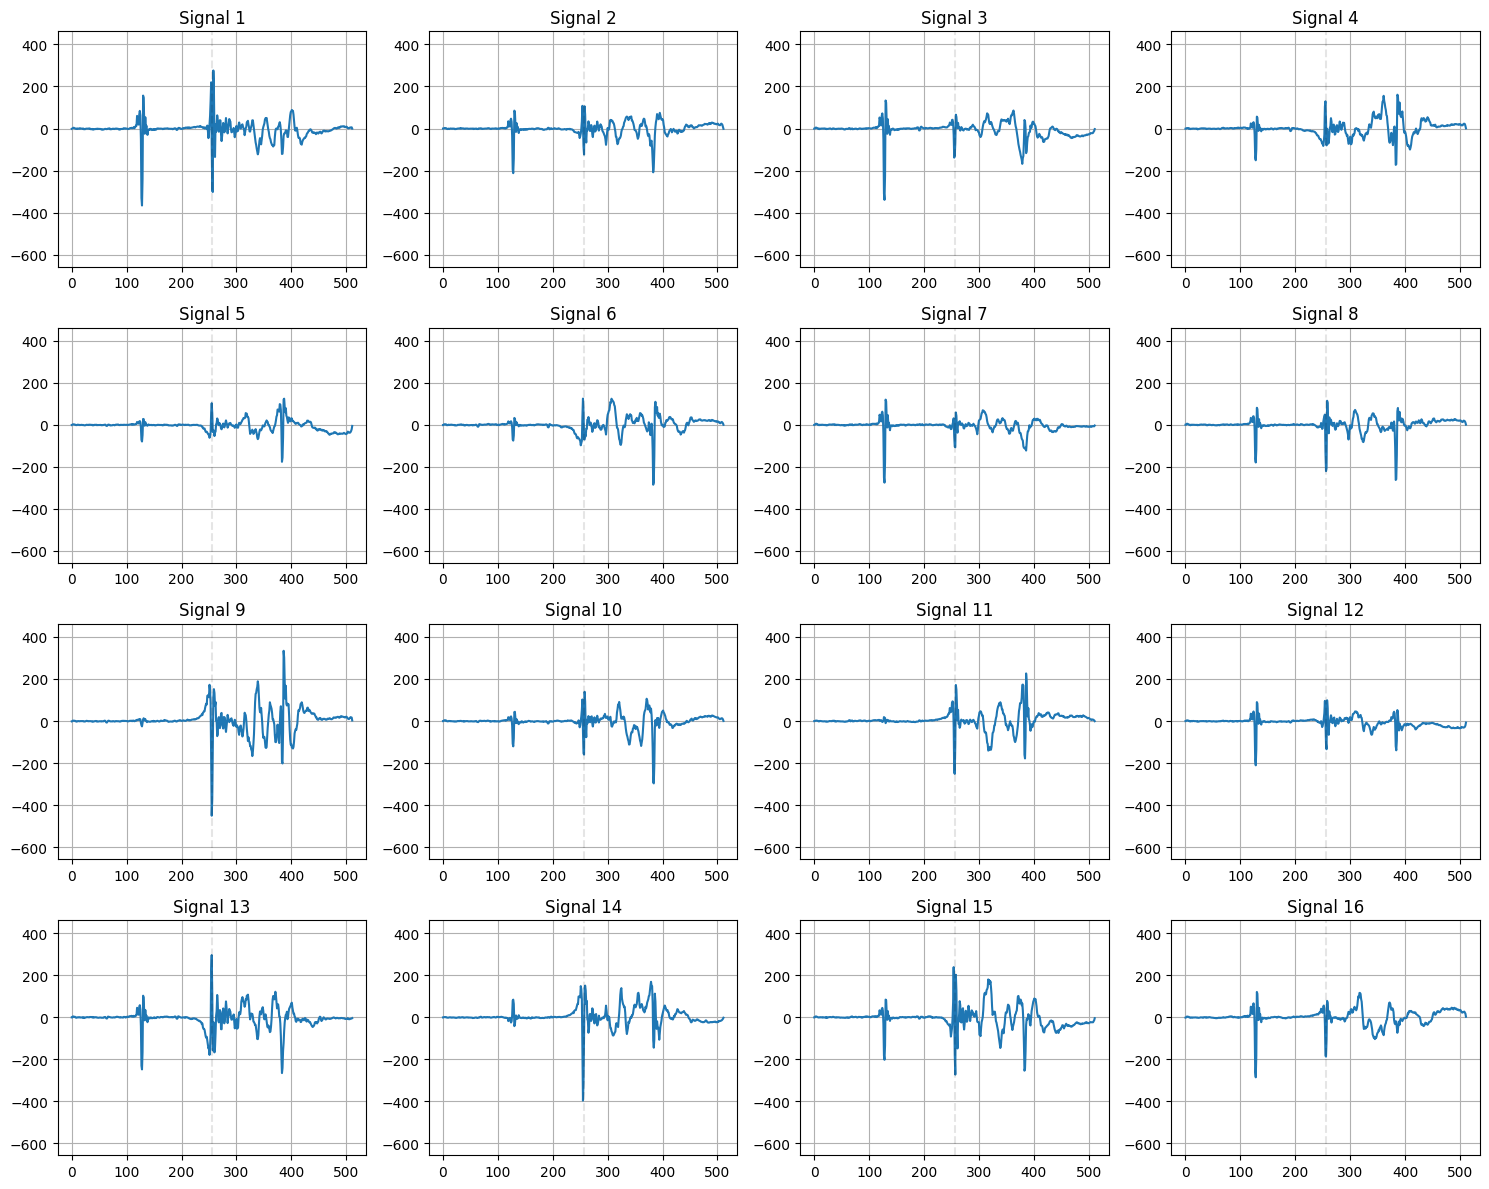

[28/32][0/188]	Loss_D: 0.7157	Loss_G: 2.2378	D(x): 0.1742	D(G(z)): 0.7646 / 0.8213
[28/32][50/188]	Loss_D: 0.6587	Loss_G: 1.7786	D(x): 0.1089	D(G(z)): 0.7650 / 0.7589
[28/32][100/188]	Loss_D: 0.6170	Loss_G: 2.0602	D(x): 0.1146	D(G(z)): 0.8256 / 0.8063
[28/32][150/188]	Loss_D: 0.6958	Loss_G: 1.7709	D(x): 0.1694	D(G(z)): 0.7510 / 0.7720
Epoch 28: SGD Discriminator lr 0.0000107 -> 0.0000103
Epoch 28: SGD Generator lr 0.0000107 -> 0.0000103


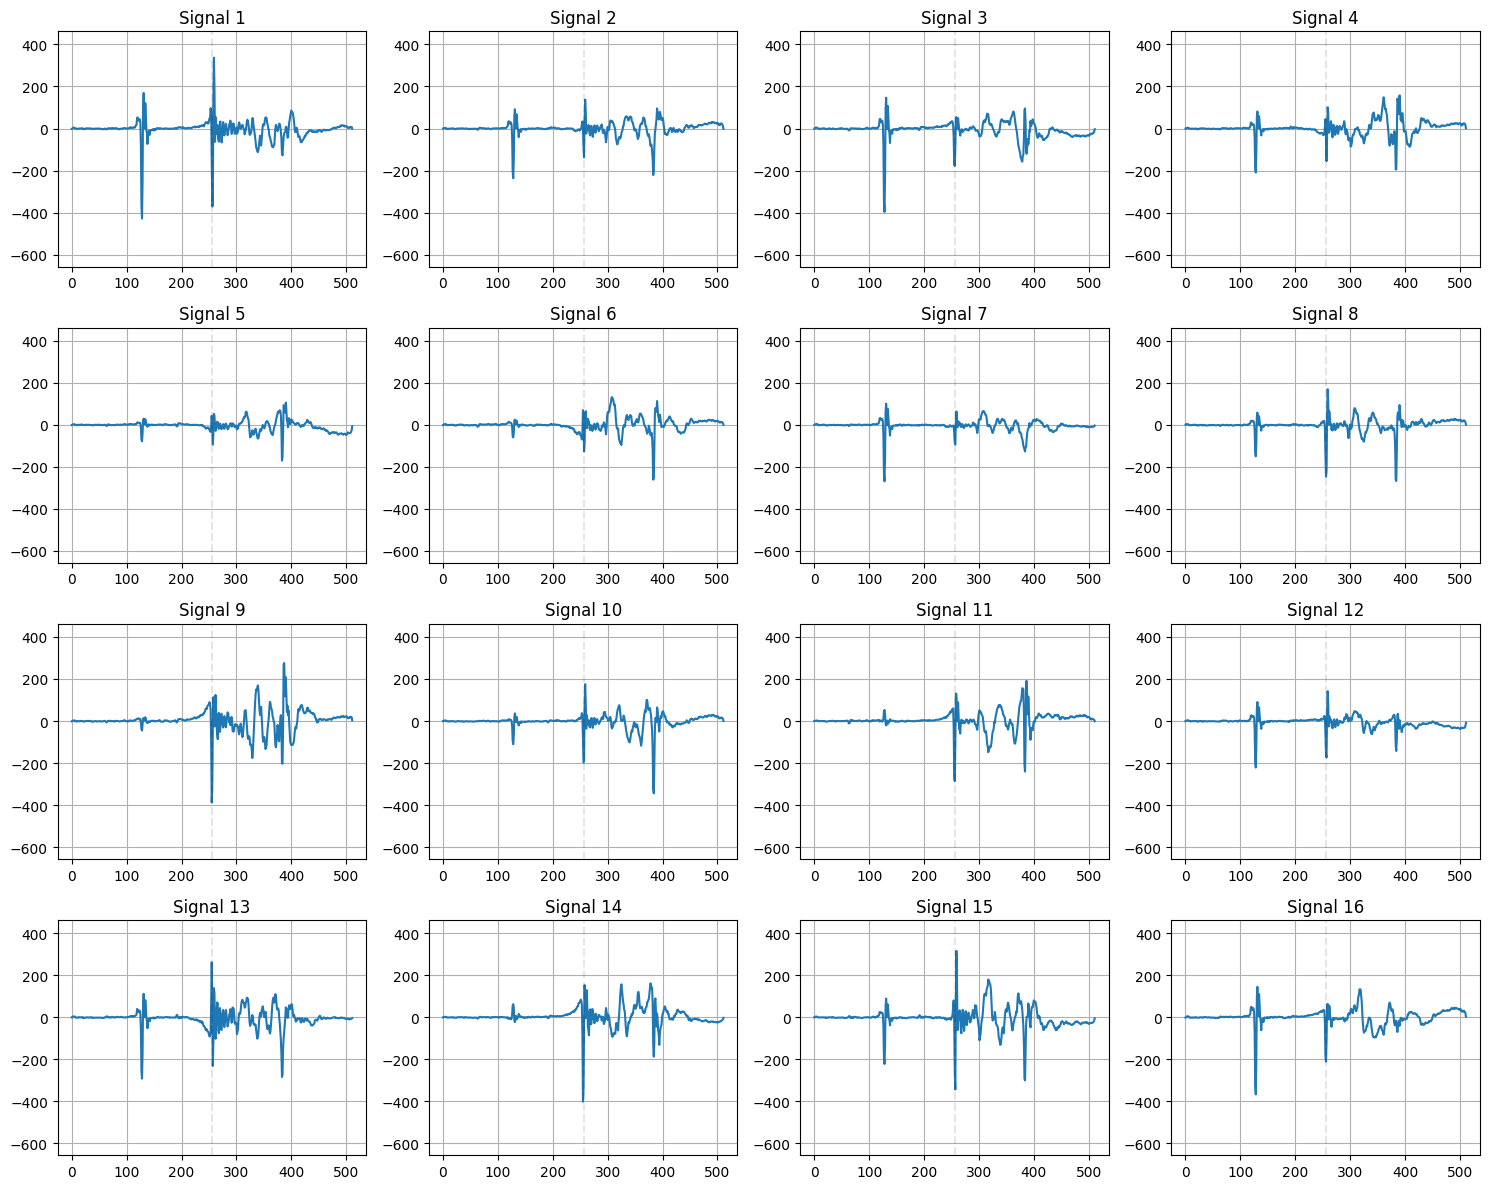

[29/32][0/188]	Loss_D: 0.6288	Loss_G: 2.1363	D(x): 0.1087	D(G(z)): 0.8263 / 0.8286
[29/32][50/188]	Loss_D: 0.7023	Loss_G: 2.2755	D(x): 0.1790	D(G(z)): 0.7918 / 0.8263
[29/32][100/188]	Loss_D: 0.5731	Loss_G: 1.9415	D(x): 0.0769	D(G(z)): 0.8178 / 0.8047
[29/32][150/188]	Loss_D: 0.6854	Loss_G: 2.6603	D(x): 0.1178	D(G(z)): 0.8065 / 0.8797
Epoch 29: SGD Discriminator lr 0.0000103 -> 0.0000100
Epoch 29: SGD Generator lr 0.0000103 -> 0.0000100


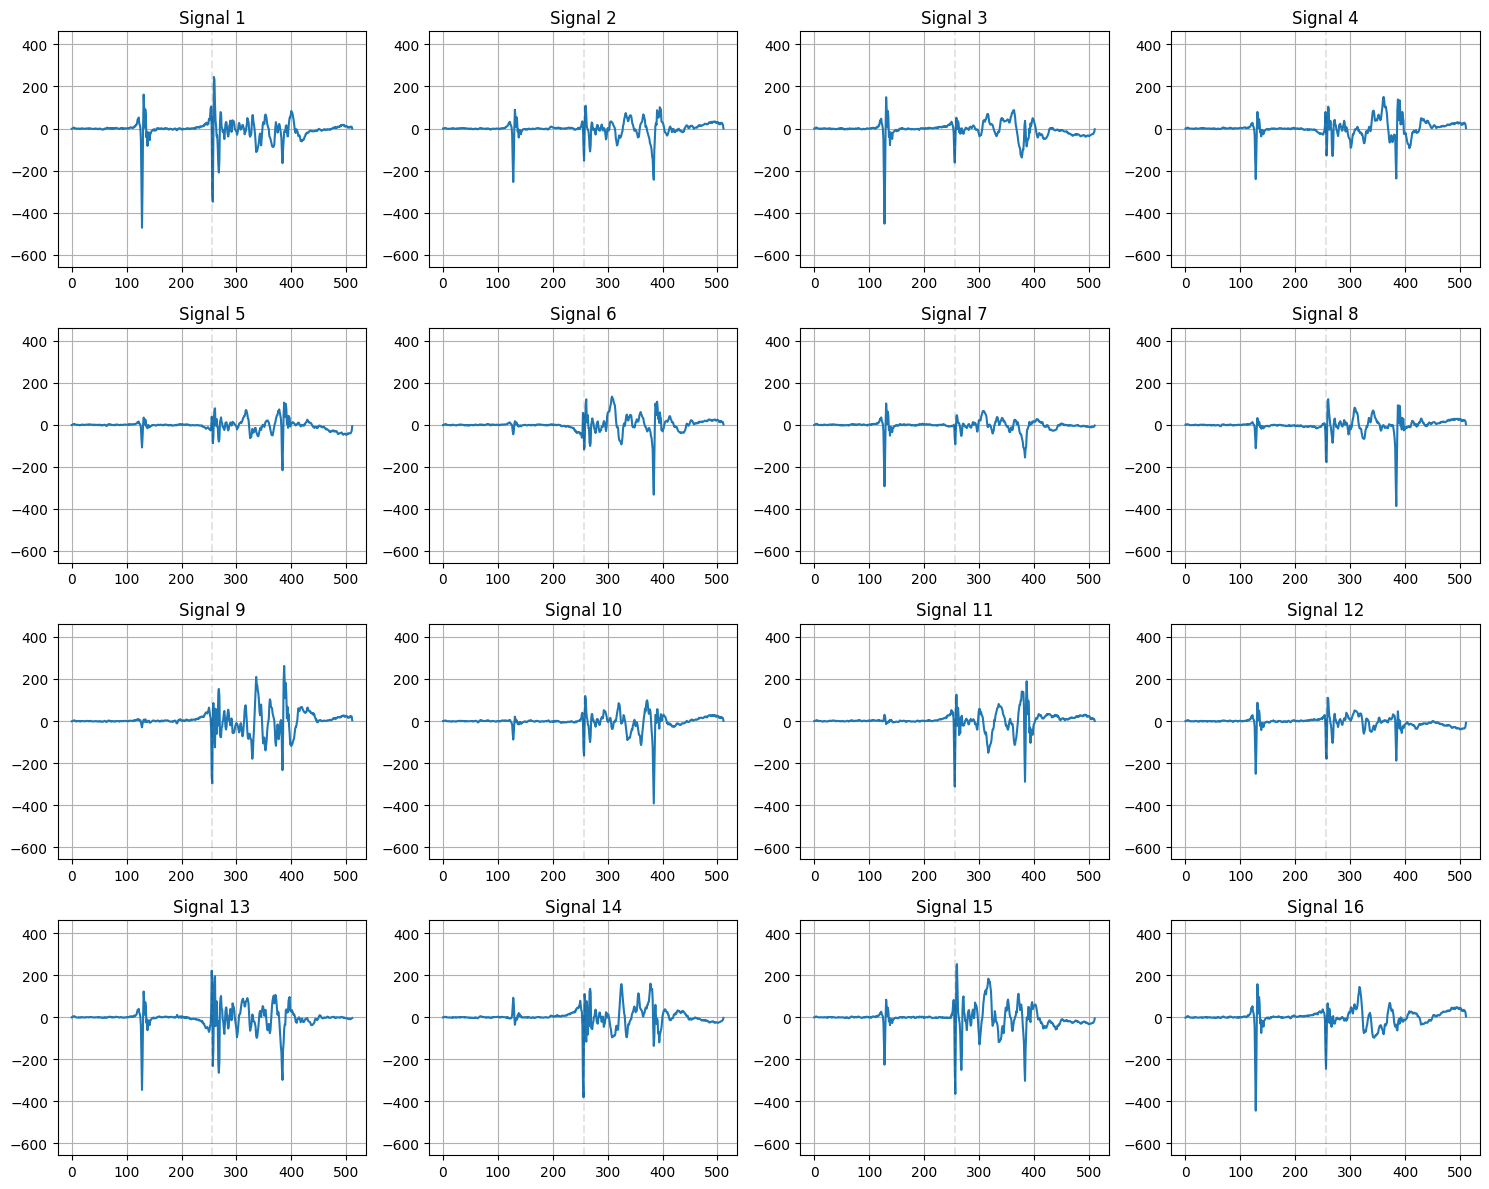

[30/32][0/188]	Loss_D: 0.6998	Loss_G: 1.8564	D(x): 0.1688	D(G(z)): 0.7348 / 0.7907
[30/32][50/188]	Loss_D: 0.6237	Loss_G: 1.9254	D(x): 0.0908	D(G(z)): 0.8045 / 0.7812
[30/32][100/188]	Loss_D: 0.6716	Loss_G: 2.2991	D(x): 0.1621	D(G(z)): 0.8193 / 0.8348
[30/32][150/188]	Loss_D: 0.6286	Loss_G: 1.8108	D(x): 0.1338	D(G(z)): 0.7645 / 0.7698
Epoch 30: SGD Discriminator lr 0.0000100 -> 0.0000100
Epoch 30: SGD Generator lr 0.0000100 -> 0.0000100


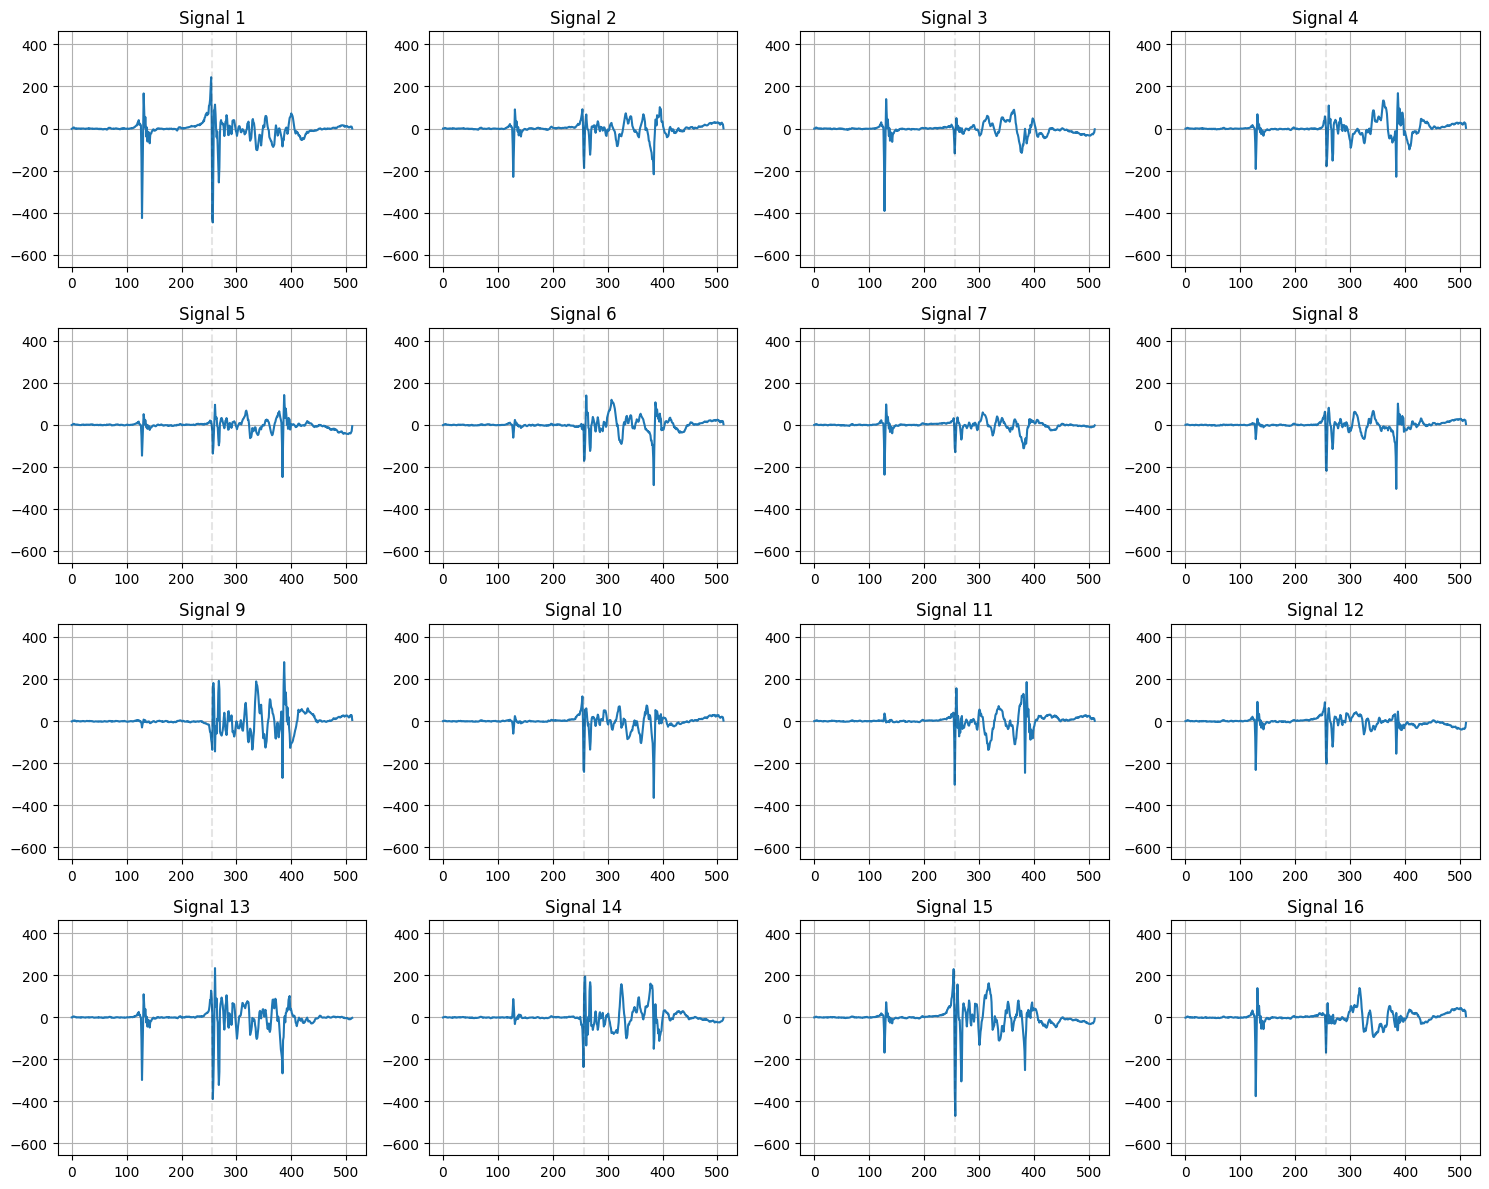

[31/32][0/188]	Loss_D: 0.6225	Loss_G: 2.0546	D(x): 0.1045	D(G(z)): 0.7629 / 0.7916
[31/32][50/188]	Loss_D: 0.5375	Loss_G: 2.1194	D(x): 0.0949	D(G(z)): 0.7925 / 0.8298
[31/32][100/188]	Loss_D: 0.5349	Loss_G: 1.9200	D(x): 0.0575	D(G(z)): 0.7977 / 0.7884
[31/32][150/188]	Loss_D: 0.7561	Loss_G: 2.0800	D(x): 0.1814	D(G(z)): 0.7758 / 0.7932
Epoch 31: SGD Discriminator lr 0.0000100 -> 0.0000100
Epoch 31: SGD Generator lr 0.0000100 -> 0.0000100


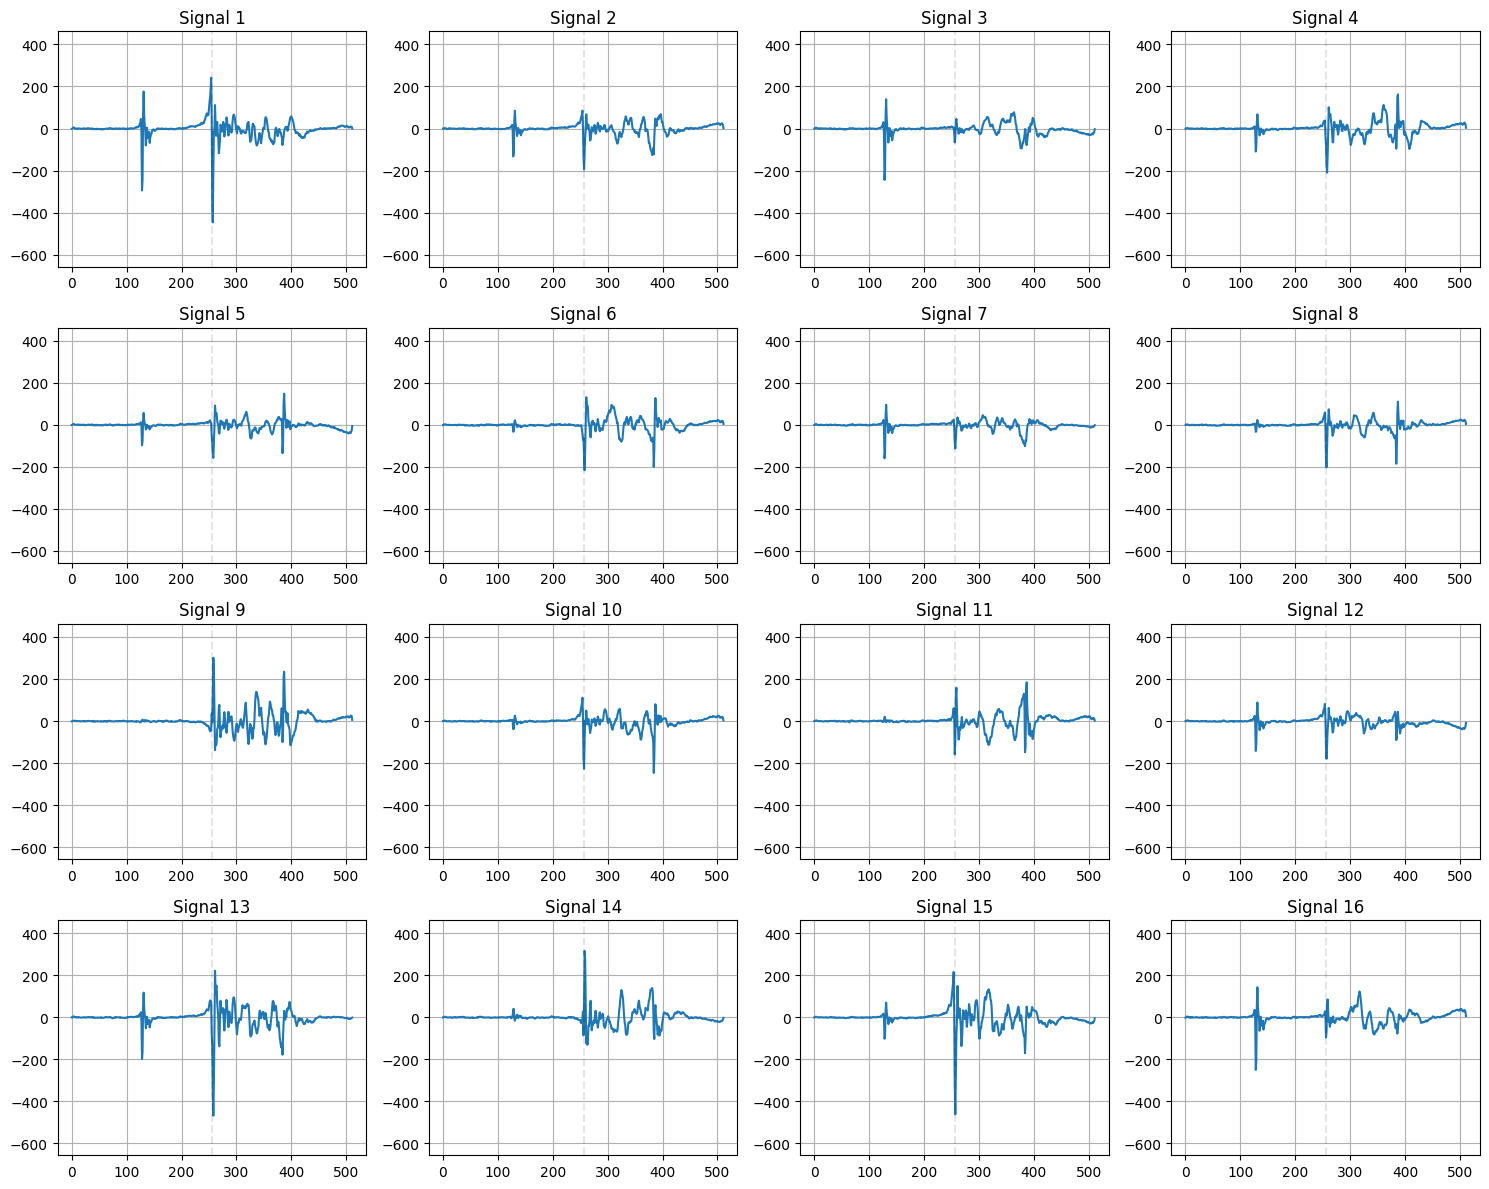

In [266]:
# Training Loop

# Lists to keep track of progress
signal_list = []
G_losses = []
D_losses = []
D_gradients = []
G_gradients = []
iters = 0

# label flip probability
flip_p = 1.0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_gpu = data[0].to(device)
        real_parameters_gpu = data[1].to(device)
        b_size = real_gpu.size(0)

        # determine which index of batch to flip on
        flip_mask = torch.rand(b_size) < flip_p

        # label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # soft labelling
        label = torch.FloatTensor(b_size).uniform_(1.0, 1.0)
        # flip selected labels
        label = torch.where(flip_mask, 1.0 - label, label).to(device)

        # Forward pass real batch through D
        output = netD(real_gpu).view(-1) # add parameters here!!!
        # output = netD(real_gpu, real_parameters_gpu).view(-1)
        # print(output)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, device=device) # do we increase nz by 3 for parameters?
        # Generate fake signal batch with G
        fake = netG(noise)
        # label.fill_(fake_label)
        label = torch.FloatTensor(b_size).uniform_(0.0, 0.25)
        label = torch.where(flip_mask, 1.0 - label, label).to(device)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()
        # Calculate gradients of discriminator parameters
        D_gradients.append([param.grad.norm().item() for param in netD.parameters()])

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        # label.fill_(real_label)  # fake labels are real for generator cost
        label = torch.FloatTensor(b_size).uniform_(1.0, 1.0)
        label = torch.where(flip_mask, 1.0 - label, label).to(device)
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        # Calculate gradients of generator parameters
        G_gradients.append([param.grad.norm().item() for param in netG.parameters()])

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        iters += 1 
    
    # learning-rate decay
    before_lr = optimizerD.param_groups[0]["lr"]
    schedulerD.step()
    after_lr = optimizerD.param_groups[0]["lr"]
    print("Epoch %d: SGD Discriminator lr %.7f -> %.7f" % (epoch, before_lr, after_lr))

    before_lr = optimizerG.param_groups[0]["lr"]
    schedulerG.step()
    after_lr = optimizerG.param_groups[0]["lr"]
    print("Epoch %d: SGD Generator lr %.7f -> %.7f" % (epoch, before_lr, after_lr))
    
    with torch.no_grad():
        fake_signals = netG(fixed_noise).detach().cpu()
        fig, axes = plt.subplots(4, 4, figsize=(15, 12))

        axes = axes.flatten()

        # plot each signal on a separate subplot
        for i, ax in enumerate(axes):
            x = np.arange(fake_signals.size(dim=2))
            y = fake_signals[i, :, :].flatten()
            y = y * dataset.scaling_factor
            y = y * dataset.std + dataset.mean
            ax.plot(x, y)

            ax.axvline(x=256, color='black', linestyle='--', alpha=0.1)
            ax.set_title(f'Signal {i+1}')
            ax.grid(True)
            ax.set_ylim(common_ylim_signal)

        for i in range(512, 8*4):
            fig.delaxes(axes[i])

        plt.tight_layout()
        plt.savefig('../data/gw-dcgans-images/gw-dcgans_epoch_%d.png' % epoch)
        plt.show()
    
    # print(time.time())
    signal_list.append(fake_signals)

### Gradients

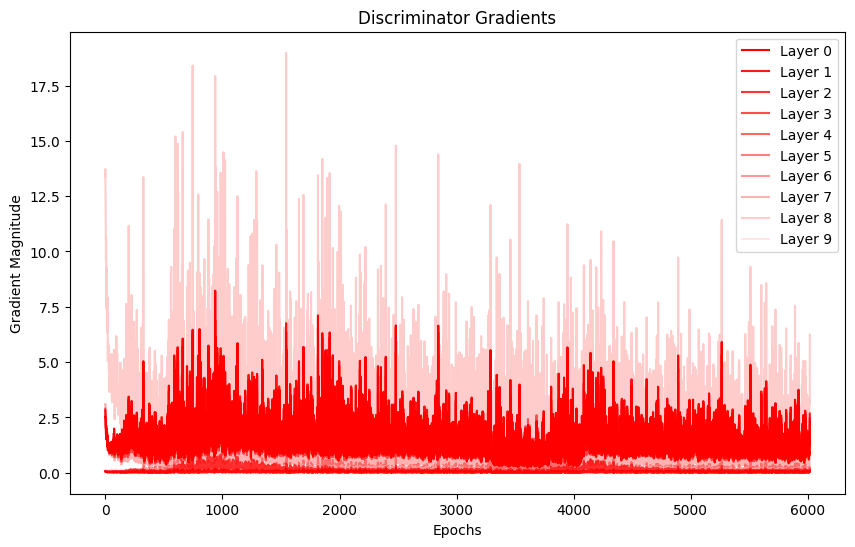

In [267]:
# Get the total number of layers in the discriminator
D_gradients = np.array(D_gradients)
num_layers = D_gradients.shape[1]

# Plot the gradients over training epochs
plt.figure(figsize=(10, 6))
for i in range(num_layers):
    # Calculate alpha value based on layer index
    alpha = 1 - (i / num_layers)  # Higher layers are more transparent
    plt.plot(D_gradients[:, i], label=f'Layer {i}', alpha=alpha, color=(1, 0, 0, alpha))

plt.xlabel('Epochs')
plt.ylabel('Gradient Magnitude')
plt.title('Discriminator Gradients')
plt.legend()
plt.show()

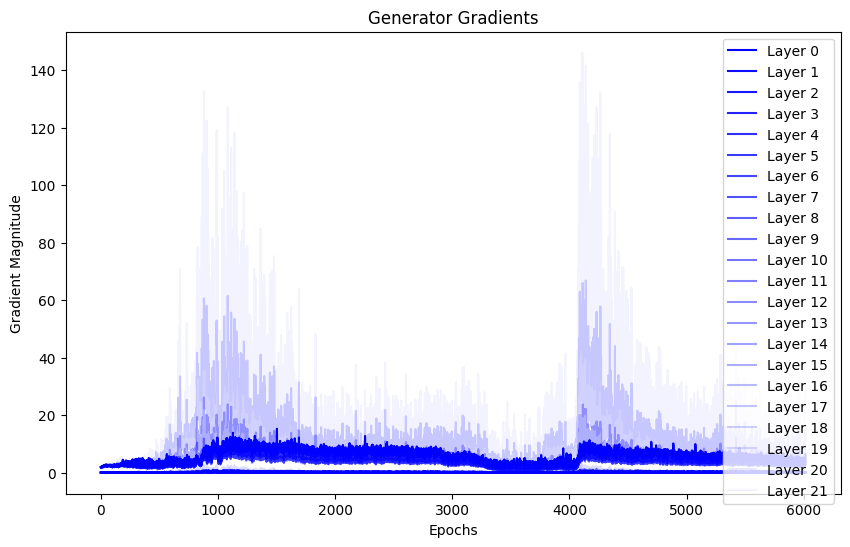

In [268]:
# Get the total number of layers in the discriminator
G_gradients = np.array(G_gradients)
num_layers = G_gradients.shape[1]

# Plot the gradients over training epochs
plt.figure(figsize=(10, 6))
for i in range(num_layers):
    # Calculate alpha value based on layer index
    alpha = 1 - (i / num_layers)  # Higher layers are more transparent
    plt.plot(G_gradients[:, i], label=f'Layer {i}', alpha=alpha, color=(0, 0, 1, alpha))

plt.xlabel('Epochs')
plt.ylabel('Gradient Magnitude')
plt.title('Generator Gradients')
plt.legend()
plt.show()

### Loss

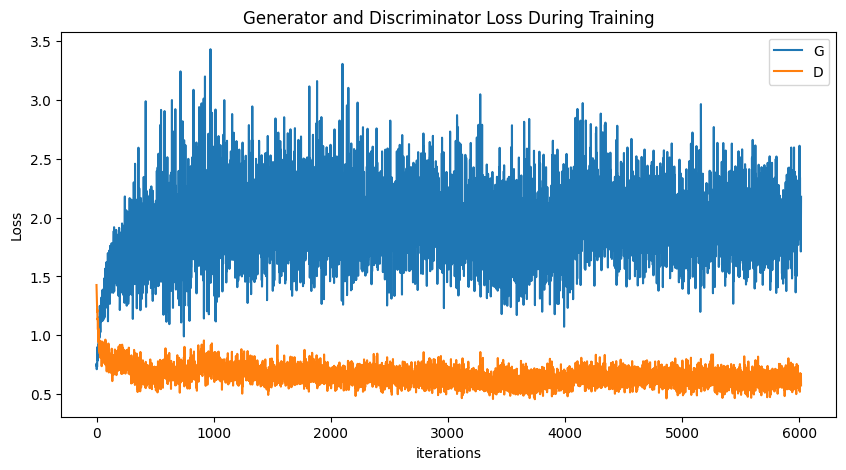

In [269]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Generated Signals

torch.Size([32, 1, 512])


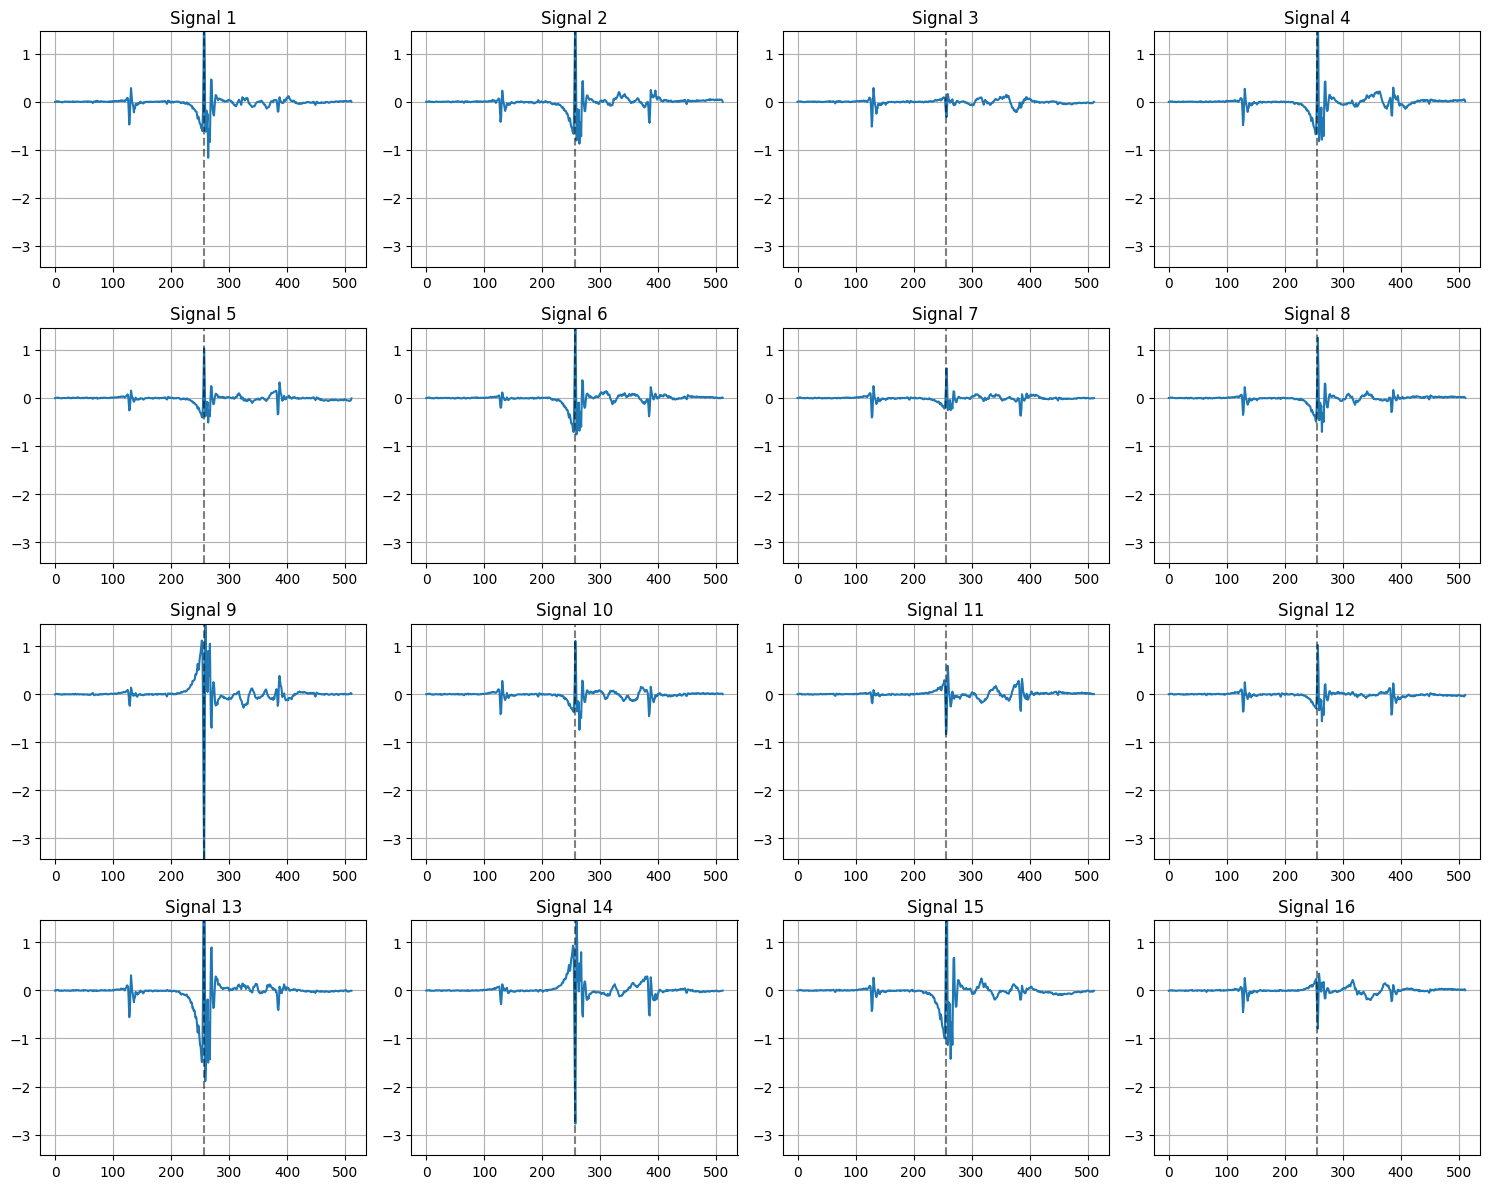

In [270]:
batch = signal_list[19]

# # plotting a single batch
# def plot_waveforms(batch):
#     fig, axs = plt.subplots(8, int(batch_size/8), figsize=(12, 12))
#     axs = axs.ravel()
    
#     for i in range(len(batch)):
#         signal = batch[i].squeeze()
#         axs[i].plot(signal)
#         axs[i].set_title(f'Signal {i+1}')
#         axs[i].axis('off')
    
#     plt.tight_layout()
#     plt.show()

# plot_waveforms(batch)

# Expecting: (32, 1, 512)
print(batch.shape)

# common_ylim = (batch[:,:,:].min(), batch[:,:,:].max())

fig, axes = plt.subplots(4, 4, figsize=(15, 12))

axes = axes.flatten()

# plot each signal on a separate subplot
for i, ax in enumerate(axes):
    x = np.arange(batch.size(dim=2))
    y = batch[i, :, :].flatten()
    ax.plot(x, y)

    ax.axvline(x=256, color='black', linestyle='--', alpha=0.5)
    ax.set_title(f'Signal {i+1}')
    ax.grid(True)
    ax.set_ylim(common_ylim)

for i in range(512, 8*4):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.savefig('../data/gw-dcgans-plots/generated_data.png')
plt.show()

In [271]:
# for signal processing
%store signal_list

Stored 'signal_list' (list)


### Evaluation Metrics for GANS